# New CVID data

### Analysis based on GEX and SoupX-denoised protein

DE analysis with DESeq2

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import seaborn as sns
import scanpy as sc
from glob import iglob
import anndata
# need to do 'pip3 install bbknn==1.3.8' to avoid incompatibility errors
import bbknn
# requires 'pip install scrublet'
#import scrublet as scr
import os
import sklearn
from sklearn.linear_model import LogisticRegression
import matplotlib as mpl
import scipy
import matplotlib.pyplot as plt
import pickle

In [2]:
np.random.seed(0)

In [3]:
%%bash

pip freeze

aiohttp==3.6.2
alembic==1.3.0
anndata==0.7.5
annoy==1.16.2
async-generator==1.10
async-timeout==3.0.1
attrs==19.3.0
backcall==0.1.0
bbknn==1.3.6
bleach==3.1.0
blinker==1.4
certifi==2019.9.11
certipy==0.1.3
cffi==1.13.2
chardet==3.0.4
Click==7.0
conda==4.7.12
conda-package-handling==1.6.0
cryptography==2.8
cycler==0.10.0
Cython==0.29.14
decorator==4.4.1
defusedxml==0.6.0
entrypoints==0.3
fbpca==1.0
geosketch==1.0
get-version==2.1
h5py==2.10.0
idna==2.8
importlib-metadata==0.23
intervaltree==2.1.0
ipykernel==5.1.3
ipython==7.9.0
ipython-genutils==0.2.0
jedi==0.15.1
Jinja2==2.10.3
joblib==0.14.0
json5==0.8.5
jsonschema==3.1.1
jupyter-client==5.3.3
jupyter-core==4.5.0
jupyter-rsession-proxy==1.0b6
jupyter-server-proxy==1.2.0
jupyterhub==1.0.0
jupyterlab==1.2.1
jupyterlab-server==1.0.6
kiwisolver==1.1.0
legacy-api-wrap==1.2
leidenalg==0.7.0
llvmlite==0.30.0
loompy==3.0.6
louvain==0.6.1
Mako==1.1.0
MarkupSafe==1.1.1
matplotlib==3.3.3
mistune==0.8.4
more-itertools==7.2.0
multidict==4.5.2
nats

In [4]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

-----
anndata     0.7.5
scanpy      1.6.0
sinfo       0.3.1
-----
PIL                 8.1.0
anndata             0.7.5
annoy               NA
attr                19.3.0
backcall            0.1.0
bbknn               NA
cffi                1.13.2
constants           NA
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.1
decorator           4.4.1
get_version         2.1
h5py                2.10.0
highs_wrapper       NA
igraph              0.7.1
importlib_metadata  0.23
ipykernel           5.1.3
ipython_genutils    0.2.0
jedi                0.15.1
joblib              0.14.0
kiwisolver          1.1.0
legacy_api_wrap     1.2
leidenalg           0.7.0
llvmlite            0.30.0
louvain             0.6.1
matplotlib          3.3.3
more_itertools      NA
mpl_toolkits        NA
natsort             6.2.0
numba               0.46.0
numexpr             2.7.0
numpy               1.17.4
packaging           19.2
pandas              0.25.3
parso               0.5.1
pexpect        

In [5]:
save_path = '/lustre/scratch117/cellgen/team292/aa22/adata_objects/202009_CVID_revision/'

## Reding the fully analysed object


In [6]:
# reading the fully analysed object, final annotation in 'cell_type_final', normalised, log tr and scaled in .X (HVG-subsetted)
# norm, log tr in .raw.X, all genes
adata_hvg = sc.read(save_path+'adata_hvg_bbknn_by_sample_nodoublets_20_PCs_GEX_and_SoupX_denoised_protein_all_samples_cleaned_up_final_20210111.h5ad')

In [7]:
adata_hvg.var['feature_types-0'].value_counts()

Gene Expression     2553
Antibody Capture     137
nan                    6
Name: feature_types-0, dtype: int64

In [8]:
adata_hvg

AnnData object with n_obs × n_vars = 145823 × 2696
    obs: 'n_genes', 'stimulation', 'sample', 'cell_id', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'cell_type_final', 'S_score', 'G2M_score', 'phase', 'louvain', 'n_counts_protein', 'n_counts_protein_lognorm', 'donor', 'Age', 'Sex', 'Age of disease onset', 'Autoimmunity', 'Gastrointestinal disease', 'Lung disease (bronchiectasis)', 'Lymphoadenopathy ', 'Splenomegaly', 'History of hypogammaglobulinemia, IgA deficiency or immunodeficiency in other family members', 'CVID_status'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-10', 'feature_types-10', 'genome-10', 'n_cells-10', 'gene_ids-11', 'feature_types-11', 'genome-11', 'n_cells-11', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'f

Reading table with predictions of GC-like (and not) phenotype to then use in DE analysis

In [9]:
# reading GC phenotype predictions for B cells
predictions = pd.read_csv(save_path + 'table_predictions_GC_B_cells_GEX_and_SoupX_denoised_protein_all_samples_20210113.csv', index_col=0)

In [10]:
predictions

GC_celltype_predictions_all_genes  \
AAACCTGAGAATGTGT-1                                 NaN   
AAACCTGAGACTAAGT-1                                 NaN   
AAACCTGAGCCGCCTA-1                                 NaN   
AAACCTGAGCGCCTCA-1                                 NaN   
AAACCTGAGGATGTAT-1                                 NaN   
...                                                ...   
TTTGTCATCCGTACAA-1-1                               NaN   
TTTGTCATCGCATGGC-1                                 NaN   
TTTGTCATCGTCACGG-1-1                               NaN   
TTTGTCATCGTCTGCT-1-1                               NaN   
TTTGTCATCTCTTATG-1                                 NaN   

                      probabilities_GC_all_genes  
AAACCTGAGAATGTGT-1                           0.0  
AAACCTGAGACTAAGT-1                           0.0  
AAACCTGAGCCGCCTA-1                           0.0  
AAACCTGAGCGCCTCA-1                           0.0  
AAACCTGAGGATGTAT-1                           0.0  
...                                          ...  
TTTGTCATCCGTACAA-1-1                         0.0  
TTTGTCATCGCATGGC-1                           0.0  
TTTGTCATCGTCACGG-1-1                         0.0  
TTTGTCATCGTCTGCT-1-1                         0.0  
TTTGTCATCTCTTATG-1                           0.0  

[145823 rows x 2 columns]

In [11]:
predictions['GC_celltype_predictions_all_genes'] = predictions['GC_celltype_predictions_all_genes'].astype(str)

In [12]:
np.unique(predictions['GC_celltype_predictions_all_genes'], return_counts=True)

(array(['GC_B_cells', 'Other_B_cells', 'nan'], dtype=object),
 array([  6793,   8069, 130961]))

In [13]:
for col in ['GC_celltype_predictions_all_genes', 'probabilities_GC_all_genes']:
    print(col)
    adata_hvg.obs[col] = predictions.loc[adata_hvg.obs_names, col]

GC_celltype_predictions_all_genes
probabilities_GC_all_genes


In [14]:
adata_hvg

AnnData object with n_obs × n_vars = 145823 × 2696
    obs: 'n_genes', 'stimulation', 'sample', 'cell_id', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'cell_type_final', 'S_score', 'G2M_score', 'phase', 'louvain', 'n_counts_protein', 'n_counts_protein_lognorm', 'donor', 'Age', 'Sex', 'Age of disease onset', 'Autoimmunity', 'Gastrointestinal disease', 'Lung disease (bronchiectasis)', 'Lymphoadenopathy ', 'Splenomegaly', 'History of hypogammaglobulinemia, IgA deficiency or immunodeficiency in other family members', 'CVID_status', 'GC_celltype_predictions_all_genes', 'probabilities_GC_all_genes'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-10', 'feature_types-10', 'genome-10', 'n_cells-10', 'gene_ids-11', 'feature_types-11', 'genome-11', 'n_cells-11', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_i

_____________________________________________________________________________________________________________________________________________________________

# Plotting

In [19]:
adata_hvg

AnnData object with n_obs × n_vars = 145823 × 2696
    obs: 'n_genes', 'stimulation', 'sample', 'cell_id', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'cell_type_final', 'S_score', 'G2M_score', 'phase', 'louvain', 'n_counts_protein', 'n_counts_protein_lognorm', 'donor', 'Age', 'Sex', 'Age of disease onset', 'Autoimmunity', 'Gastrointestinal disease', 'Lung disease (bronchiectasis)', 'Lymphoadenopathy ', 'Splenomegaly', 'History of hypogammaglobulinemia, IgA deficiency or immunodeficiency in other family members', 'CVID_status', 'GC_celltype_predictions_all_genes', 'probabilities_GC_all_genes'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-10', 'feature_types-10', 'genome-10', 'n_cells-10', 'gene_ids-11', 'feature_types-11', 'genome-11', 'n_cells-11', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_i

In [20]:
markers = ['CD4','CD3G', 'FOXJ1', 'IL2R', 'TRDV2', 'CD8', # T cells
                             'CD19', 'MS4A1', # B cells
                              'CD27', 'CD38', 'JCHAIN', # Plasma B cells
                             'NCAM1', 'FCGR3A', # NK celss
                             'HBB', # Erythrocytes
                             'FCGR3B', # Neutrophils
                             'CD14', 'S100A12', # Monocytes
                             'FLT3', # Dendritic cells
                             'IRF4', 'CLEC9A', # cDC1
                             'CD1C', # cDC2
                             'TNFRSF21', # pDC and IRF4
                             'CD34', # Precursors
                             'PPBP', 'TUBB1', 'PF4', # Platelets
                             'MI67', # cycling
                            ]

... storing 'GC_celltype_predictions_all_genes' as categorical


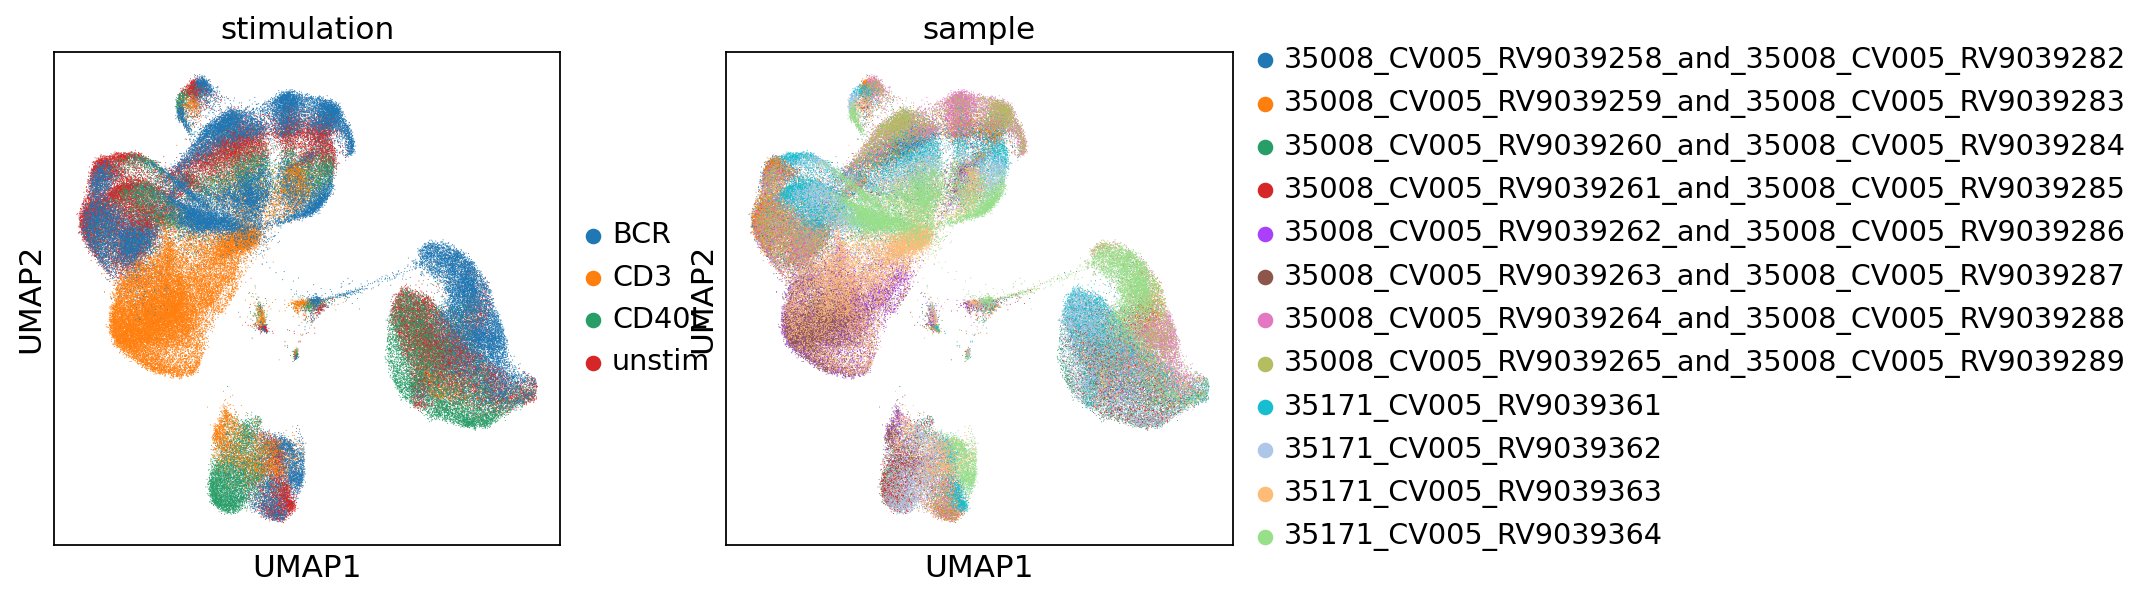

In [21]:
sc.pl.umap(adata_hvg, color=['stimulation','sample'])

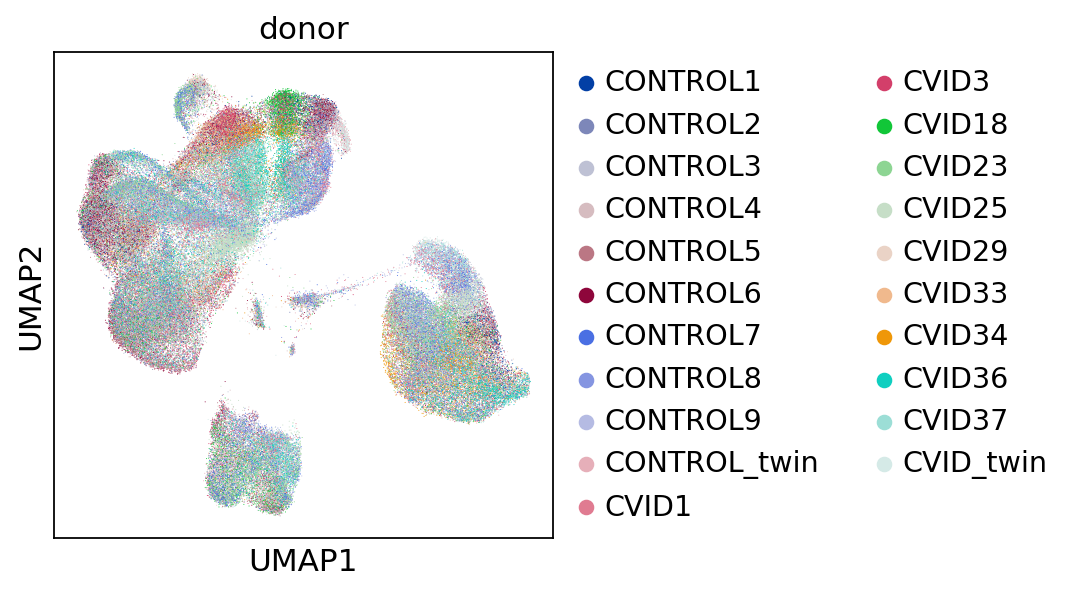

In [22]:
sc.pl.umap(adata_hvg, color=['donor'])

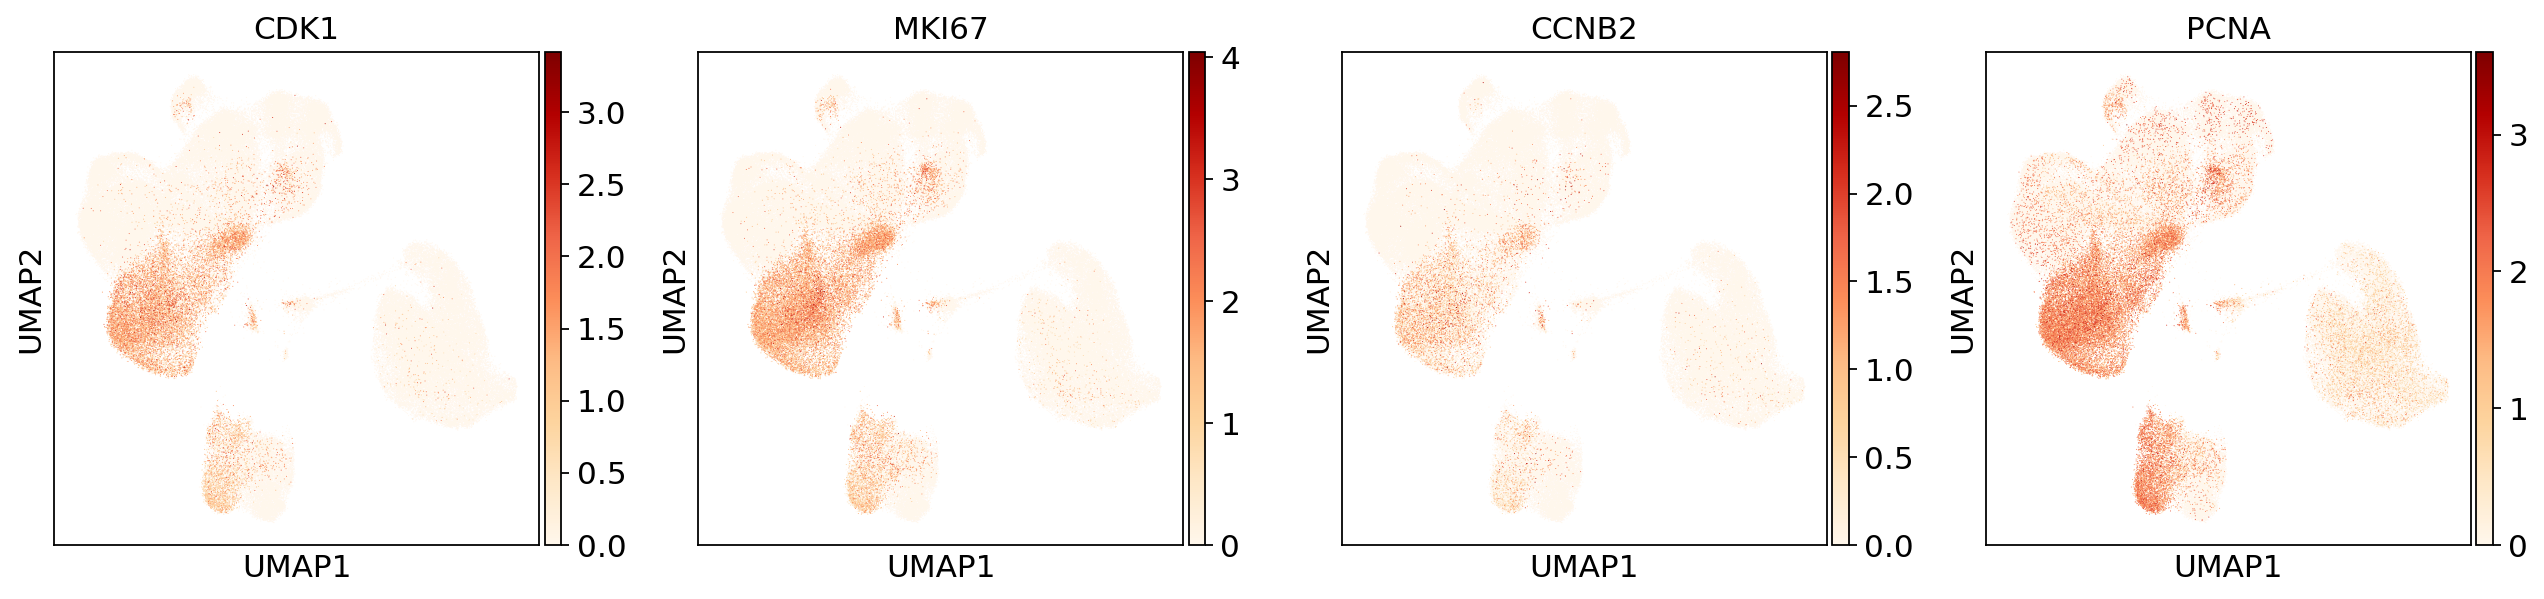

In [23]:
sc.pl.umap(adata_hvg, color=['CDK1','MKI67','CCNB2','PCNA'], cmap='OrRd')

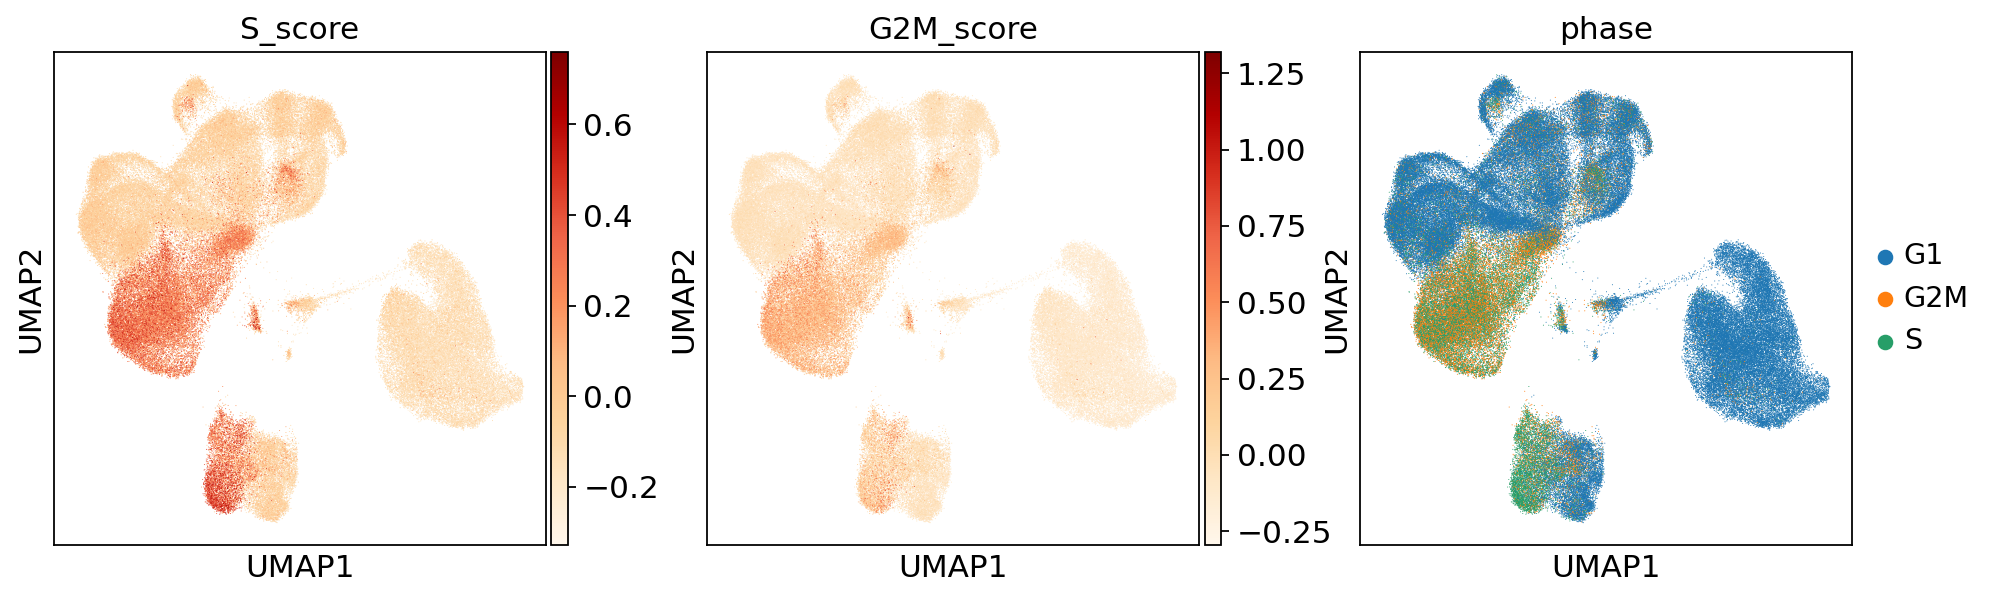

In [24]:
sc.pl.umap(adata_hvg, color=['S_score','G2M_score','phase'], cmap='OrRd')

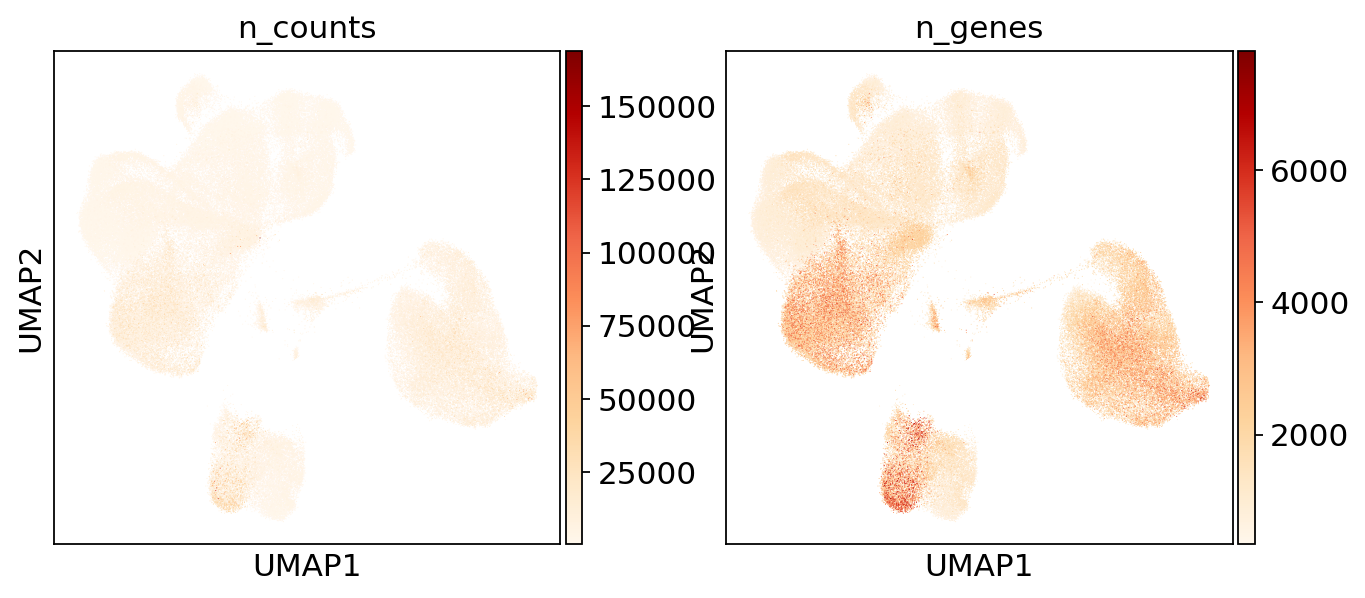

In [25]:
sc.pl.umap(adata_hvg, color=['n_counts',
                             'n_genes'], cmap='OrRd')

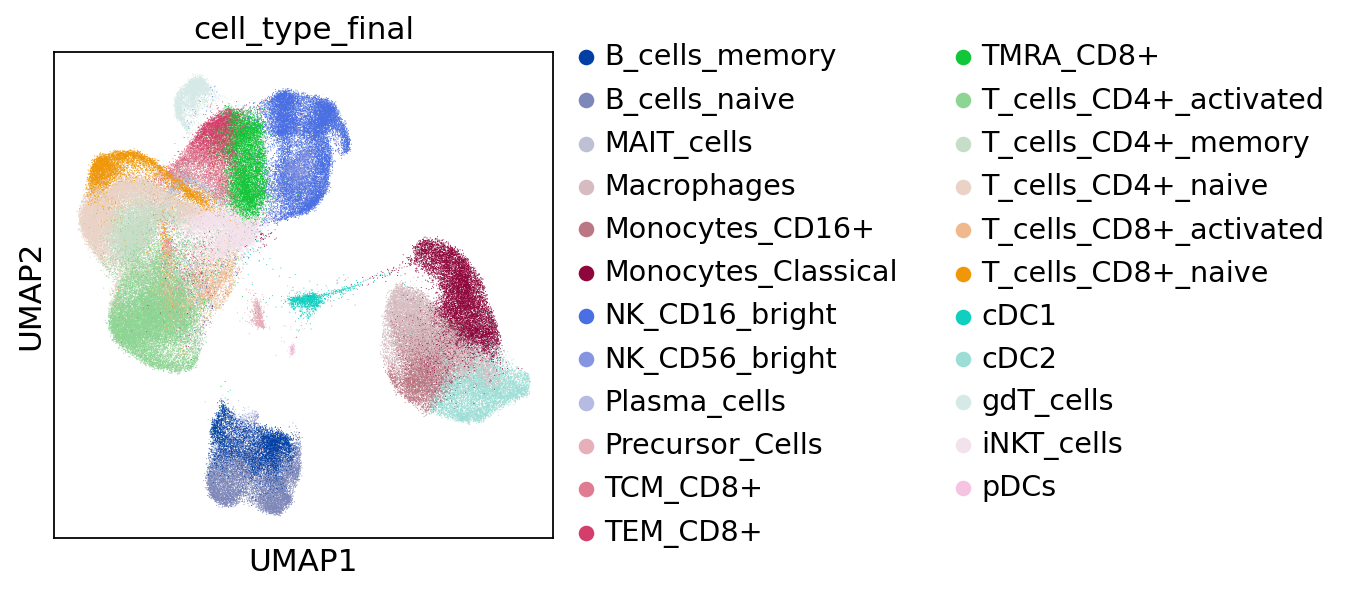

In [26]:
sc.pl.umap(adata_hvg, color=['cell_type_final'],
           #cmap='OrRd'
          )

In [27]:
adata_hvg

AnnData object with n_obs × n_vars = 145823 × 2696
    obs: 'n_genes', 'stimulation', 'sample', 'cell_id', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'cell_type_final', 'S_score', 'G2M_score', 'phase', 'louvain', 'n_counts_protein', 'n_counts_protein_lognorm', 'donor', 'Age', 'Sex', 'Age of disease onset', 'Autoimmunity', 'Gastrointestinal disease', 'Lung disease (bronchiectasis)', 'Lymphoadenopathy ', 'Splenomegaly', 'History of hypogammaglobulinemia, IgA deficiency or immunodeficiency in other family members', 'CVID_status', 'GC_celltype_predictions_all_genes', 'probabilities_GC_all_genes'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-10', 'feature_types-10', 'genome-10', 'n_cells-10', 'gene_ids-11', 'feature_types-11', 'genome-11', 'n_cells-11', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_i

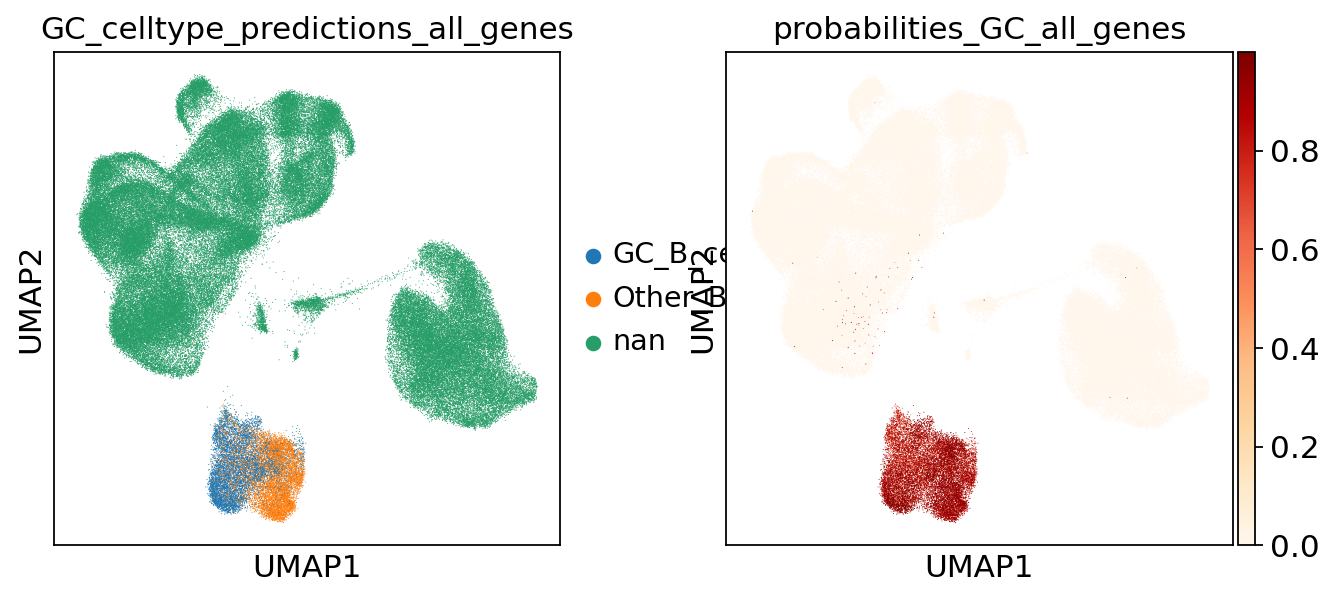

In [28]:
sc.pl.umap(adata_hvg, color=['GC_celltype_predictions_all_genes', 'probabilities_GC_all_genes'],
           cmap='OrRd'
          )

# TODO: make a pretty colormap for these cell states

# DE with DESeq2

In [15]:
np.unique(adata_hvg.obs['cell_type_final'])

array(['B_cells_memory', 'B_cells_naive', 'MAIT_cells', 'Macrophages',
       'Monocytes_CD16+', 'Monocytes_Classical', 'NK_CD16_bright',
       'NK_CD56_bright', 'Plasma_cells', 'Precursor_Cells', 'TCM_CD8+',
       'TEM_CD8+', 'TMRA_CD8+', 'T_cells_CD4+_activated',
       'T_cells_CD4+_memory', 'T_cells_CD4+_naive',
       'T_cells_CD8+_activated', 'T_cells_CD8+_naive', 'cDC1', 'cDC2',
       'gdT_cells', 'iNKT_cells', 'pDCs'], dtype=object)

In [16]:
adata_hvg

AnnData object with n_obs × n_vars = 145823 × 2696
    obs: 'n_genes', 'stimulation', 'sample', 'cell_id', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'cell_type_final', 'S_score', 'G2M_score', 'phase', 'louvain', 'n_counts_protein', 'n_counts_protein_lognorm', 'donor', 'Age', 'Sex', 'Age of disease onset', 'Autoimmunity', 'Gastrointestinal disease', 'Lung disease (bronchiectasis)', 'Lymphoadenopathy ', 'Splenomegaly', 'History of hypogammaglobulinemia, IgA deficiency or immunodeficiency in other family members', 'CVID_status', 'GC_celltype_predictions_all_genes', 'probabilities_GC_all_genes'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-10', 'feature_types-10', 'genome-10', 'n_cells-10', 'gene_ids-11', 'feature_types-11', 'genome-11', 'n_cells-11', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_i

In [17]:
np.unique(adata_hvg.obs['sample']) # corresponding to the samples / batch

array(['35008_CV005_RV9039258_and_35008_CV005_RV9039282',
       '35008_CV005_RV9039259_and_35008_CV005_RV9039283',
       '35008_CV005_RV9039260_and_35008_CV005_RV9039284',
       '35008_CV005_RV9039261_and_35008_CV005_RV9039285',
       '35008_CV005_RV9039262_and_35008_CV005_RV9039286',
       '35008_CV005_RV9039263_and_35008_CV005_RV9039287',
       '35008_CV005_RV9039264_and_35008_CV005_RV9039288',
       '35008_CV005_RV9039265_and_35008_CV005_RV9039289',
       '35171_CV005_RV9039361', '35171_CV005_RV9039362',
       '35171_CV005_RV9039363', '35171_CV005_RV9039364'], dtype=object)

In [18]:
# reading the raw count data
adata_raw = sc.read(save_path+'adata_raw_filtered_all_samples.h5ad')

In [19]:
# subsetting to selected cells 
adata_raw = adata_raw[adata_hvg.obs_names,:].copy()

In [20]:
# checking that the values are integer - yes
np.unique(adata_raw[adata_raw.obs['sample'] == '35008_CV005_RV9039258_and_35008_CV005_RV9039282'].X.todense())

matrix([[    0.,     0.,     0., ..., 32580., 35153., 36678.]],
       dtype=float32)

In [21]:
np.unique(adata_raw.obs_names == adata_hvg.obs_names)

array([ True])

In [22]:
# to rerun
adata_raw.obs['cell_type_final'] = adata_hvg.obs.loc[adata_raw.obs_names, 'cell_type_final']
adata_raw.obs['celltype_condition'] = [i + '_' + j for i,j in zip(adata_hvg.obs['cell_type_final'], adata_hvg.obs['CVID_status'])]

In [23]:
np.unique(adata_raw.obs['celltype_condition'])

array(['B_cells_memory_CONTROL', 'B_cells_memory_CVID',
       'B_cells_naive_CONTROL', 'B_cells_naive_CVID',
       'MAIT_cells_CONTROL', 'MAIT_cells_CVID', 'Macrophages_CONTROL',
       'Macrophages_CVID', 'Monocytes_CD16+_CONTROL',
       'Monocytes_CD16+_CVID', 'Monocytes_Classical_CONTROL',
       'Monocytes_Classical_CVID', 'NK_CD16_bright_CONTROL',
       'NK_CD16_bright_CVID', 'NK_CD56_bright_CONTROL',
       'NK_CD56_bright_CVID', 'Plasma_cells_CONTROL', 'Plasma_cells_CVID',
       'Precursor_Cells_CONTROL', 'Precursor_Cells_CVID',
       'TCM_CD8+_CONTROL', 'TCM_CD8+_CVID', 'TEM_CD8+_CONTROL',
       'TEM_CD8+_CVID', 'TMRA_CD8+_CONTROL', 'TMRA_CD8+_CVID',
       'T_cells_CD4+_activated_CONTROL', 'T_cells_CD4+_activated_CVID',
       'T_cells_CD4+_memory_CONTROL', 'T_cells_CD4+_memory_CVID',
       'T_cells_CD4+_naive_CONTROL', 'T_cells_CD4+_naive_CVID',
       'T_cells_CD8+_activated_CONTROL', 'T_cells_CD8+_activated_CVID',
       'T_cells_CD8+_naive_CONTROL', 'T_cells_CD8+_n

In [24]:
adata_raw_copy = adata_raw.copy()

# normalise and log transform
sc.pp.normalize_per_cell(adata_raw_copy, counts_per_cell_after=1e4)
sc.pp.log1p(adata_raw_copy)

normalizing by total count per cell
    finished (0:00:38): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [25]:
adata_raw_copy.var_names

Index(['A1BG', 'A1BG-AS1', 'A2M', 'A2M-AS1', 'A2ML1', 'A4GALT', 'A4GNT',
       'AAAS', 'AACS', 'AADAT',
       ...
       'ZZEF1', 'ZZZ3', 'anti-Tau-Phospho', 'anti-c-Met', 'bP-21264C1.2',
       'bP-2189O9.3', 'humanCD207', 'humanMac-2(Galectin-3)',
       'mouse/ratCD278(ICOS)', 'mouseintegrinB7'],
      dtype='object', length=22144)

In [26]:
adata_raw_copy.X[0].todense()

matrix([[0.        , 0.        , 0.        , ..., 0.86362475, 0.        ,
         0.86362475]], dtype=float32)

In [27]:
adata_raw_copy.raw.X[0].todense()

matrix([[0., 0., 0., ..., 1., 0., 1.]], dtype=float32)

In [28]:
adata_raw

AnnData object with n_obs × n_vars = 145823 × 22144
    obs: 'n_genes', 'stimulation', 'sample', 'cell_id', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'cell_type_final', 'celltype_condition'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-10', 'feature_types-10', 'genome-10', 'n_cells-10', 'gene_ids-11', 'feature_types-11', 'genome-11', 'n_cells-11', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'genome-5', 'n_cells-5', 'gene_ids-6', 'feature_types-6', 'genome-6', 'n_cells-6', 'gene_ids-7', 'feature_types-7', 'genome-7', 'n_cells-7', 'gene_ids-8', 'feature_types-8', 'genome-8', 'n_cells-8', 'gene_ids-9', 'feature_types-9', 'genome-9', 'n_cells-9'
    layers

In [29]:
# to filter genes with < 0.1 average logCPM expression
expr_mtx_df_normlog = pd.DataFrame(adata_raw_copy.X.todense(),
                           index = adata_raw_copy.obs_names,
                           columns = adata_raw_copy.var_names)

In [30]:
expr_mtx_df_normlog.shape

(145823, 22144)

In [31]:
expr_mtx_df_normlog

A1BG  A1BG-AS1       A2M  A2M-AS1  A2ML1  A4GALT  A4GNT  \
AAACCTGAGAATGTGT-1     0.0       0.0  0.000000      0.0    0.0     0.0    0.0   
AAACCTGAGACTAAGT-1     0.0       0.0  1.870824      0.0    0.0     0.0    0.0   
AAACCTGAGCCGCCTA-1     0.0       0.0  0.000000      0.0    0.0     0.0    0.0   
AAACCTGAGCGCCTCA-1     0.0       0.0  0.000000      0.0    0.0     0.0    0.0   
AAACCTGAGGATGTAT-1     0.0       0.0  0.000000      0.0    0.0     0.0    0.0   
...                    ...       ...       ...      ...    ...     ...    ...   
TTTGTCATCCGTACAA-1-1   0.0       0.0  0.000000      0.0    0.0     0.0    0.0   
TTTGTCATCGCATGGC-1     0.0       0.0  0.000000      0.0    0.0     0.0    0.0   
TTTGTCATCGTCACGG-1-1   0.0       0.0  0.000000      0.0    0.0     0.0    0.0   
TTTGTCATCGTCTGCT-1-1   0.0       0.0  0.000000      0.0    0.0     0.0    0.0   
TTTGTCATCTCTTATG-1     0.0       0.0  0.000000      0.0    0.0     0.0    0.0   

                          AAAS     AACS  AADAT  ...     ZZEF1      ZZZ3  \
AAACCTGAGAATGTGT-1    0.863625  0.00000    0.0  ...  0.000000  0.000000   
AAACCTGAGACTAAGT-1    0.000000  0.57931    0.0  ...  0.579310  0.000000   
AAACCTGAGCCGCCTA-1    0.000000  0.00000    0.0  ...  0.000000  0.000000   
AAACCTGAGCGCCTCA-1    0.000000  0.00000    0.0  ...  0.000000  0.000000   
AAACCTGAGGATGTAT-1    0.000000  0.00000    0.0  ...  0.000000  0.000000   
...                        ...      ...    ...  ...       ...       ...   
TTTGTCATCCGTACAA-1-1  0.000000  0.00000    0.0  ...  0.000000  0.000000   
TTTGTCATCGCATGGC-1    0.000000  0.00000    0.0  ...  1.375002  0.000000   
TTTGTCATCGTCACGG-1-1  0.000000  0.00000    0.0  ...  0.000000  0.000000   
TTTGTCATCGTCTGCT-1-1  0.000000  0.00000    0.0  ...  0.000000  0.000000   
TTTGTCATCTCTTATG-1    0.000000  0.00000    0.0  ...  0.000000  1.270912   

                      anti-Tau-Phospho  anti-c-Met  bP-21264C1.2  bP-2189O9.3  \
AAACCTGAGAATGTGT-1            0.000000    1.320017           0.0          0.0   
AAACCTGAGACTAAGT-1            2.861111    2.343504           0.0          0.0   
AAACCTGAGCCGCCTA-1            2.180338    2.815324           0.0          0.0   
AAACCTGAGCGCCTCA-1            3.806115    2.281880           0.0          0.0   
AAACCTGAGGATGTAT-1            0.000000    3.002646           0.0          0.0   
...                                ...         ...           ...          ...   
TTTGTCATCCGTACAA-1-1          3.659395    3.509526           0.0          0.0   
TTTGTCATCGCATGGC-1            3.596243    3.076648           0.0          0.0   
TTTGTCATCGTCACGG-1-1          2.982079    3.039717           0.0          0.0   
TTTGTCATCGTCTGCT-1-1          3.062384    2.275586           0.0          0.0   
TTTGTCATCTCTTATG-1            3.374344    2.796343           0.0          0.0   

                      humanCD207  humanMac-2(Galectin-3)  \
AAACCTGAGAATGTGT-1      1.632222                0.863625   
AAACCTGAGACTAAGT-1      2.087317                3.063623   
AAACCTGAGCCGCCTA-1      2.180338                2.815324   
AAACCTGAGCGCCTCA-1      2.922632                3.806115   
AAACCTGAGGATGTAT-1      2.357961                3.391421   
...                          ...                     ...   
TTTGTCATCCGTACAA-1-1    3.789703                4.385511   
TTTGTCATCGCATGGC-1      3.076648                3.746468   
TTTGTCATCGTCACGG-1-1    2.630163                3.195033   
TTTGTCATCGTCTGCT-1-1    2.537249                3.862398   
TTTGTCATCTCTTATG-1      3.536117                3.675327   

                      mouse/ratCD278(ICOS)  mouseintegrinB7  
AAACCTGAGAATGTGT-1                0.000000         0.863625  
AAACCTGAGACTAAGT-1                2.087317         1.870824  
AAACCTGAGCCGCCTA-1                2.180338         0.000000  
AAACCTGAGCGCCTCA-1                0.000000         2.281880  
AAACCTGAGGATGTAT-1                2.357961         0.000000  
...                                    ...              ...  
TTTGTCATCCGTACAA-1-1

In [32]:
adata_raw.obs['donor'] = adata_hvg.obs.loc[adata_raw.obs_names,'donor']

In [33]:
np.unique(adata_raw.obs['donor'])

array(['CONTROL1', 'CONTROL2', 'CONTROL3', 'CONTROL4', 'CONTROL5',
       'CONTROL6', 'CONTROL7', 'CONTROL8', 'CONTROL9', 'CONTROL_twin',
       'CVID1', 'CVID18', 'CVID23', 'CVID25', 'CVID29', 'CVID3', 'CVID33',
       'CVID34', 'CVID36', 'CVID37', 'CVID_twin'], dtype=object)

In [34]:
# all donors except twins (aka validation_cohort here and further)
adata_raw_validation_cohort = adata_raw[(adata_raw.obs['donor'] != 'CONTROL_twin')
                                        & (adata_raw.obs['donor'] != 'CVID_twin')].copy()
# twins only
adata_raw_twins = adata_raw[adata_raw.obs['donor'].isin(['CONTROL_twin','CVID_twin'])].copy()

In [54]:
%%time

# filtering genes on a per cell_type basis
# for all donors except twins (aka validation_cohort here and further)
filtered_genes_validation_cohort = {}

for celltype in np.unique(adata_raw.obs['cell_type_final']):
    print(celltype)
    curr_expr_mtx = expr_mtx_df_normlog.loc[adata_raw_validation_cohort[adata_raw_validation_cohort.obs['cell_type_final'] == celltype].obs.index,:]
    curr_expr_mtx.loc['mean'] = curr_expr_mtx.mean()
    # for easier filtering
    curr_expr_mtx = curr_expr_mtx.T
    filtered_genes_validation_cohort[celltype] = list(curr_expr_mtx[curr_expr_mtx['mean'] > 0.1].index)
    print('filtered genes:', len(filtered_genes_validation_cohort[celltype]))

B_cells_memory
filtered genes: 4533
B_cells_naive
filtered genes: 4847
MAIT_cells
filtered genes: 3972
Macrophages
filtered genes: 4588
Monocytes_CD16+
filtered genes: 4591
Monocytes_Classical
filtered genes: 4906
NK_CD16_bright
filtered genes: 3439
NK_CD56_bright
filtered genes: 4178
Plasma_cells
filtered genes: 5696
Precursor_Cells
filtered genes: 5328
TCM_CD8+
filtered genes: 3797
TEM_CD8+
filtered genes: 3929
TMRA_CD8+
filtered genes: 3371
T_cells_CD4+_activated
filtered genes: 5074
T_cells_CD4+_memory
filtered genes: 3920
T_cells_CD4+_naive
filtered genes: 3570
T_cells_CD8+_activated
filtered genes: 4852
T_cells_CD8+_naive
filtered genes: 3668
cDC1
filtered genes: 4167
cDC2
filtered genes: 5095
gdT_cells
filtered genes: 3765
iNKT_cells
filtered genes: 4242
pDCs
filtered genes: 4555
CPU times: user 19 s, sys: 8.99 s, total: 28 s
Wall time: 28 s


In [55]:
adata_raw_validation_cohort

AnnData object with n_obs × n_vars = 133818 × 22144
    obs: 'n_genes', 'stimulation', 'sample', 'cell_id', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'cell_type_final', 'celltype_condition', 'donor'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-10', 'feature_types-10', 'genome-10', 'n_cells-10', 'gene_ids-11', 'feature_types-11', 'genome-11', 'n_cells-11', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'genome-5', 'n_cells-5', 'gene_ids-6', 'feature_types-6', 'genome-6', 'n_cells-6', 'gene_ids-7', 'feature_types-7', 'genome-7', 'n_cells-7', 'gene_ids-8', 'feature_types-8', 'genome-8', 'n_cells-8', 'gene_ids-9', 'feature_types-9', 'genome-9', 'n_cells-9'
 

In [35]:
expr_mtx_df = pd.DataFrame(adata_raw.X.todense(),
                           index = adata_raw.obs_names,
                           columns = adata_raw.var_names)

In [36]:
expr_mtx_df

A1BG  A1BG-AS1  A2M  A2M-AS1  A2ML1  A4GALT  A4GNT  \
AAACCTGAGAATGTGT-1     0.0       0.0  0.0      0.0    0.0     0.0    0.0   
AAACCTGAGACTAAGT-1     0.0       0.0  7.0      0.0    0.0     0.0    0.0   
AAACCTGAGCCGCCTA-1     0.0       0.0  0.0      0.0    0.0     0.0    0.0   
AAACCTGAGCGCCTCA-1     0.0       0.0  0.0      0.0    0.0     0.0    0.0   
AAACCTGAGGATGTAT-1     0.0       0.0  0.0      0.0    0.0     0.0    0.0   
...                    ...       ...  ...      ...    ...     ...    ...   
TTTGTCATCCGTACAA-1-1   0.0       0.0  0.0      0.0    0.0     0.0    0.0   
TTTGTCATCGCATGGC-1     0.0       0.0  0.0      0.0    0.0     0.0    0.0   
TTTGTCATCGTCACGG-1-1   0.0       0.0  0.0      0.0    0.0     0.0    0.0   
TTTGTCATCGTCTGCT-1-1   0.0       0.0  0.0      0.0    0.0     0.0    0.0   
TTTGTCATCTCTTATG-1     0.0       0.0  0.0      0.0    0.0     0.0    0.0   

                      AAAS  AACS  AADAT  ...  ZZEF1  ZZZ3  anti-Tau-Phospho  \
AAACCTGAGAATGTGT-1     1.0   0.0    0.0  ...    0.0   0.0               0.0   
AAACCTGAGACTAAGT-1     0.0   1.0    0.0  ...    1.0   0.0              21.0   
AAACCTGAGCCGCCTA-1     0.0   0.0    0.0  ...    0.0   0.0               1.0   
AAACCTGAGCGCCTCA-1     0.0   0.0    0.0  ...    0.0   0.0               5.0   
AAACCTGAGGATGTAT-1     0.0   0.0    0.0  ...    0.0   0.0               0.0   
...                    ...   ...    ...  ...    ...   ...               ...   
TTTGTCATCCGTACAA-1-1   0.0   0.0    0.0  ...    0.0   0.0              21.0   
TTTGTCATCGCATGGC-1     0.0   0.0    0.0  ...    1.0   0.0              12.0   
TTTGTCATCGTCACGG-1-1   0.0   0.0    0.0  ...    0.0   0.0              16.0   
TTTGTCATCGTCTGCT-1-1   0.0   0.0    0.0  ...    0.0   0.0               7.0   
TTTGTCATCTCTTATG-1     0.0   0.0    0.0  ...    0.0   1.0              11.0   

                      anti-c-Met  bP-21264C1.2  bP-2189O9.3  humanCD207  \
AAACCTGAGAATGTGT-1           2.0           0.0          0.0         3.0   
AAACCTGAGACTAAGT-1          12.0           0.0          0.0         9.0   
AAACCTGAGCCGCCTA-1           2.0           0.0          0.0         1.0   
AAACCTGAGCGCCTCA-1           1.0           0.0          0.0         2.0   
AAACCTGAGGATGTAT-1           2.0           0.0          0.0         1.0   
...                          ...           ...          ...         ...   
TTTGTCATCCGTACAA-1-1        18.0           0.0          0.0        24.0   
TTTGTCATCGCATGGC-1           7.0           0.0          0.0         7.0   
TTTGTCATCGTCACGG-1-1        17.0           0.0          0.0        11.0   
TTTGTCATCGTCTGCT-1-1         3.0           0.0          0.0         4.0   
TTTGTCATCTCTTATG-1           6.0           0.0          0.0        13.0   

                      humanMac-2(Galectin-3)  mouse/ratCD278(ICOS)  \
AAACCTGAGAATGTGT-1                       1.0                   0.0   
AAACCTGAGACTAAGT-1                      26.0                   9.0   
AAACCTGAGCCGCCTA-1                       2.0                   1.0   
AAACCTGAGCGCCTCA-1                       5.0                   0.0   
AAACCTGAGGATGTAT-1                       3.0                   1.0   
...                                      ...                   ...   
TTTGTCATCCGTACAA-1-1                    44.0                  10.0   
TTTGTCATCGCATGGC-1                      14.0                   4.0   
TTTGTCATCGTCACGG-1-1                    20.0                   5.0   
TTTGTCATCGTCTGCT-1-1                    16.0                   4.0   
TTTGTCATCTCTTATG-1                      15.0                   3.0   

                      mouseintegrinB7  
AAACCTGAGAATGTGT-1                1.0  
AAACCTGAGACTAAGT-1                7.0  
AAACCTGAGCCGCCTA-1                0.0  
AAACCTGAGCGCCTCA-1                1.0  
AAACCTGAGGATGTAT-1                0.0  
...                               ...  
TTTGTCATCCGTACAA-1-1             12.0  
TTTGTCATCGCATGGC-1               10.0  
TTTGTCATCGTCACGG-1-1              7.0  
TTTGTCATCGTCTGCT-1

In [37]:
np.unique(adata_raw.obs['cell_type_final'])

array(['B_cells_memory', 'B_cells_naive', 'MAIT_cells', 'Macrophages',
       'Monocytes_CD16+', 'Monocytes_Classical', 'NK_CD16_bright',
       'NK_CD56_bright', 'Plasma_cells', 'Precursor_Cells', 'TCM_CD8+',
       'TEM_CD8+', 'TMRA_CD8+', 'T_cells_CD4+_activated',
       'T_cells_CD4+_memory', 'T_cells_CD4+_naive',
       'T_cells_CD8+_activated', 'T_cells_CD8+_naive', 'cDC1', 'cDC2',
       'gdT_cells', 'iNKT_cells', 'pDCs'], dtype=object)

In [38]:
len(np.unique(adata_raw.obs['cell_type_final']))

23

In [39]:
np.unique(adata_raw.obs['celltype_condition'])

array(['B_cells_memory_CONTROL', 'B_cells_memory_CVID',
       'B_cells_naive_CONTROL', 'B_cells_naive_CVID',
       'MAIT_cells_CONTROL', 'MAIT_cells_CVID', 'Macrophages_CONTROL',
       'Macrophages_CVID', 'Monocytes_CD16+_CONTROL',
       'Monocytes_CD16+_CVID', 'Monocytes_Classical_CONTROL',
       'Monocytes_Classical_CVID', 'NK_CD16_bright_CONTROL',
       'NK_CD16_bright_CVID', 'NK_CD56_bright_CONTROL',
       'NK_CD56_bright_CVID', 'Plasma_cells_CONTROL', 'Plasma_cells_CVID',
       'Precursor_Cells_CONTROL', 'Precursor_Cells_CVID',
       'TCM_CD8+_CONTROL', 'TCM_CD8+_CVID', 'TEM_CD8+_CONTROL',
       'TEM_CD8+_CVID', 'TMRA_CD8+_CONTROL', 'TMRA_CD8+_CVID',
       'T_cells_CD4+_activated_CONTROL', 'T_cells_CD4+_activated_CVID',
       'T_cells_CD4+_memory_CONTROL', 'T_cells_CD4+_memory_CVID',
       'T_cells_CD4+_naive_CONTROL', 'T_cells_CD4+_naive_CVID',
       'T_cells_CD8+_activated_CONTROL', 'T_cells_CD8+_activated_CVID',
       'T_cells_CD8+_naive_CONTROL', 'T_cells_CD8+_n

In [40]:
len(np.unique(adata_raw.obs['celltype_condition']))

46

In [41]:
expr_mtx_df

A1BG  A1BG-AS1  A2M  A2M-AS1  A2ML1  A4GALT  A4GNT  \
AAACCTGAGAATGTGT-1     0.0       0.0  0.0      0.0    0.0     0.0    0.0   
AAACCTGAGACTAAGT-1     0.0       0.0  7.0      0.0    0.0     0.0    0.0   
AAACCTGAGCCGCCTA-1     0.0       0.0  0.0      0.0    0.0     0.0    0.0   
AAACCTGAGCGCCTCA-1     0.0       0.0  0.0      0.0    0.0     0.0    0.0   
AAACCTGAGGATGTAT-1     0.0       0.0  0.0      0.0    0.0     0.0    0.0   
...                    ...       ...  ...      ...    ...     ...    ...   
TTTGTCATCCGTACAA-1-1   0.0       0.0  0.0      0.0    0.0     0.0    0.0   
TTTGTCATCGCATGGC-1     0.0       0.0  0.0      0.0    0.0     0.0    0.0   
TTTGTCATCGTCACGG-1-1   0.0       0.0  0.0      0.0    0.0     0.0    0.0   
TTTGTCATCGTCTGCT-1-1   0.0       0.0  0.0      0.0    0.0     0.0    0.0   
TTTGTCATCTCTTATG-1     0.0       0.0  0.0      0.0    0.0     0.0    0.0   

                      AAAS  AACS  AADAT  ...  ZZEF1  ZZZ3  anti-Tau-Phospho  \
AAACCTGAGAATGTGT-1     1.0   0.0    0.0  ...    0.0   0.0               0.0   
AAACCTGAGACTAAGT-1     0.0   1.0    0.0  ...    1.0   0.0              21.0   
AAACCTGAGCCGCCTA-1     0.0   0.0    0.0  ...    0.0   0.0               1.0   
AAACCTGAGCGCCTCA-1     0.0   0.0    0.0  ...    0.0   0.0               5.0   
AAACCTGAGGATGTAT-1     0.0   0.0    0.0  ...    0.0   0.0               0.0   
...                    ...   ...    ...  ...    ...   ...               ...   
TTTGTCATCCGTACAA-1-1   0.0   0.0    0.0  ...    0.0   0.0              21.0   
TTTGTCATCGCATGGC-1     0.0   0.0    0.0  ...    1.0   0.0              12.0   
TTTGTCATCGTCACGG-1-1   0.0   0.0    0.0  ...    0.0   0.0              16.0   
TTTGTCATCGTCTGCT-1-1   0.0   0.0    0.0  ...    0.0   0.0               7.0   
TTTGTCATCTCTTATG-1     0.0   0.0    0.0  ...    0.0   1.0              11.0   

                      anti-c-Met  bP-21264C1.2  bP-2189O9.3  humanCD207  \
AAACCTGAGAATGTGT-1           2.0           0.0          0.0         3.0   
AAACCTGAGACTAAGT-1          12.0           0.0          0.0         9.0   
AAACCTGAGCCGCCTA-1           2.0           0.0          0.0         1.0   
AAACCTGAGCGCCTCA-1           1.0           0.0          0.0         2.0   
AAACCTGAGGATGTAT-1           2.0           0.0          0.0         1.0   
...                          ...           ...          ...         ...   
TTTGTCATCCGTACAA-1-1        18.0           0.0          0.0        24.0   
TTTGTCATCGCATGGC-1           7.0           0.0          0.0         7.0   
TTTGTCATCGTCACGG-1-1        17.0           0.0          0.0        11.0   
TTTGTCATCGTCTGCT-1-1         3.0           0.0          0.0         4.0   
TTTGTCATCTCTTATG-1           6.0           0.0          0.0        13.0   

                      humanMac-2(Galectin-3)  mouse/ratCD278(ICOS)  \
AAACCTGAGAATGTGT-1                       1.0                   0.0   
AAACCTGAGACTAAGT-1                      26.0                   9.0   
AAACCTGAGCCGCCTA-1                       2.0                   1.0   
AAACCTGAGCGCCTCA-1                       5.0                   0.0   
AAACCTGAGGATGTAT-1                       3.0                   1.0   
...                                      ...                   ...   
TTTGTCATCCGTACAA-1-1                    44.0                  10.0   
TTTGTCATCGCATGGC-1                      14.0                   4.0   
TTTGTCATCGTCACGG-1-1                    20.0                   5.0   
TTTGTCATCGTCTGCT-1-1                    16.0                   4.0   
TTTGTCATCTCTTATG-1                      15.0                   3.0   

                      mouseintegrinB7  
AAACCTGAGAATGTGT-1                1.0  
AAACCTGAGACTAAGT-1                7.0  
AAACCTGAGCCGCCTA-1                0.0  
AAACCTGAGCGCCTCA-1                1.0  
AAACCTGAGGATGTAT-1                0.0  
...                               ...  
TTTGTCATCCGTACAA-1-1             12.0  
TTTGTCATCGCATGGC-1               10.0  
TTTGTCATCGTCACGG-1-1              7.0  
TTTGTCATCGTCTGCT-1

In [42]:
def generate_deseq2_tables(expr_mtx, adata_obj, group_col, 
                           group_A, # cluster_CVID 
                           group_B, # cluster_CONTROL
                           batch_key,
                           mode = 'all_donors', # 'all_donors' or 'twins' for twins-only analysis
                           min_cells_per_minibatch = 10,
                          ):
    
    print('comparing groups', group_A, 'and', group_B)
    
    # we only want to consider batches that contain cells from both group_A and group_B AND 
    adata_obj_subset_group_A = adata_obj[adata_obj.obs[group_col] == group_A].copy()
    adata_obj_subset_group_B = adata_obj[adata_obj.obs[group_col] == group_B].copy()
    
    batches_group_A = list(np.unique(adata_obj[adata_obj.obs[group_col] == group_A].obs[batch_key]))
    batches_group_B = list(np.unique(adata_obj[adata_obj.obs[group_col] == group_B].obs[batch_key]))
    
    print('samples in', group_A, 'group:', batches_group_A)
    print('samples in', group_B, 'group:', batches_group_B)
    
    if mode == 'all_donors':
        # if we're working with all donors, we will take only samples present in both the CVID and CONTROL comparison groups
        # labels of batches with > 0 cells from both the comparison groups
        batches = list(set(batches_group_A) & set(batches_group_B))
        print('all donors mode, common samples:', batches)
        
        # discarding batch labels that contain < 10 cells in either of the comparison groups
        batches2drop = []
        for batch in batches:
            cells_in_batch_group_A = adata_obj_subset_group_A[adata_obj_subset_group_A.obs[batch_key] == batch].X.shape[0]
            cells_in_batch_group_B = adata_obj_subset_group_B[adata_obj_subset_group_B.obs[batch_key] == batch].X.shape[0]
            if cells_in_batch_group_A < min_cells_per_minibatch or cells_in_batch_group_B < min_cells_per_minibatch:
                batches2drop.append(batch)
        
    elif mode == 'twins':
        # if it's twins, there are no common samples fro them, so just using the union of samples across both comparison groups
        batches = list(set(batches_group_A + batches_group_B))
        print('twin mode, union of samples:', batches)
        
        # discarding batch labels that contain < 10 cells in either of the comparison groups, separately for twin scenario
        batches2drop = []
        for batch in batches_group_A:
            cells_in_batch_group_A = adata_obj_subset_group_A[adata_obj_subset_group_A.obs[batch_key] == batch].X.shape[0]
            if cells_in_batch_group_A < min_cells_per_minibatch:
                batches2drop.append(batch)
        for batch in batches_group_B:
            cells_in_batch_group_B = adata_obj_subset_group_B[adata_obj_subset_group_B.obs[batch_key] == batch].X.shape[0]
            if cells_in_batch_group_B < min_cells_per_minibatch:
                batches2drop.append(batch)
    else:
        print("invalid mode argument, mode needs to be either 'all_donors' or 'twins', smth is going to break")
    
    
    batches = [batch for batch in batches if batch not in batches2drop]
    
    print('samples in this run with > ', min_cells_per_minibatch, ' cells in each condition:', len(batches), batches)
    
    count_table_colnames = ['group_' + group_A + '_batch_' + b for b in batches] + ['group_' + group_B + '_batch_' + b for b in batches]
    
    count_table = pd.DataFrame(index = expr_mtx.columns,
                               columns = count_table_colnames)
    
    for group_batch in count_table.columns:
        
        curr_group = group_batch.split('_batch_')[0][6:]
        curr_batch = group_batch.split('_batch_')[1]
        
        #print(curr_group, curr_batch)
        
        selected_cells = adata_obj[(adata_obj.obs[group_col] == curr_group) & (adata_obj.obs[batch_key] == curr_batch)].obs_names
                
        expr_mtx_subset = expr_mtx.loc[selected_cells,:]
        
        #print(expr_mtx_subset.shape)
        
        expr_mtx_subset.loc['sum'] = expr_mtx_subset.sum()
        
        #print(expr_mtx_subset.loc['mean'].shape)
        #print(count_table.shape)

                
        count_table[group_batch] = list(expr_mtx_subset.loc['sum'])
        
    
    count_table.index = count_table.index.rename('Gene')
    
    coldata_data = [group_A for b in batches] + [group_B for b in batches]
    
    coldata_table = pd.DataFrame(index = count_table.columns, data = {'group': coldata_data})
    
    
    results = {'cnt_table': count_table,
               'coldata': coldata_table} 
    
    return(results)
    
        

In [64]:
np.unique(adata_raw_validation_cohort.obs['celltype_condition'])

array(['B_cells_memory_CONTROL', 'B_cells_memory_CVID',
       'B_cells_naive_CONTROL', 'B_cells_naive_CVID',
       'MAIT_cells_CONTROL', 'MAIT_cells_CVID', 'Macrophages_CONTROL',
       'Macrophages_CVID', 'Monocytes_CD16+_CONTROL',
       'Monocytes_CD16+_CVID', 'Monocytes_Classical_CONTROL',
       'Monocytes_Classical_CVID', 'NK_CD16_bright_CONTROL',
       'NK_CD16_bright_CVID', 'NK_CD56_bright_CONTROL',
       'NK_CD56_bright_CVID', 'Plasma_cells_CONTROL', 'Plasma_cells_CVID',
       'Precursor_Cells_CONTROL', 'Precursor_Cells_CVID',
       'TCM_CD8+_CONTROL', 'TCM_CD8+_CVID', 'TEM_CD8+_CONTROL',
       'TEM_CD8+_CVID', 'TMRA_CD8+_CONTROL', 'TMRA_CD8+_CVID',
       'T_cells_CD4+_activated_CONTROL', 'T_cells_CD4+_activated_CVID',
       'T_cells_CD4+_memory_CONTROL', 'T_cells_CD4+_memory_CVID',
       'T_cells_CD4+_naive_CONTROL', 'T_cells_CD4+_naive_CVID',
       'T_cells_CD8+_activated_CONTROL', 'T_cells_CD8+_activated_CVID',
       'T_cells_CD8+_naive_CONTROL', 'T_cells_CD8+_n

In [65]:
np.unique(adata_raw_validation_cohort.obs['cell_type_final'])

array(['B_cells_memory', 'B_cells_naive', 'MAIT_cells', 'Macrophages',
       'Monocytes_CD16+', 'Monocytes_Classical', 'NK_CD16_bright',
       'NK_CD56_bright', 'Plasma_cells', 'Precursor_Cells', 'TCM_CD8+',
       'TEM_CD8+', 'TMRA_CD8+', 'T_cells_CD4+_activated',
       'T_cells_CD4+_memory', 'T_cells_CD4+_naive',
       'T_cells_CD8+_activated', 'T_cells_CD8+_naive', 'cDC1', 'cDC2',
       'gdT_cells', 'iNKT_cells', 'pDCs'], dtype=object)

In [66]:
adata_raw_validation_cohort

AnnData object with n_obs × n_vars = 133818 × 22144
    obs: 'n_genes', 'stimulation', 'sample', 'cell_id', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'cell_type_final', 'celltype_condition', 'donor'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-10', 'feature_types-10', 'genome-10', 'n_cells-10', 'gene_ids-11', 'feature_types-11', 'genome-11', 'n_cells-11', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'genome-5', 'n_cells-5', 'gene_ids-6', 'feature_types-6', 'genome-6', 'n_cells-6', 'gene_ids-7', 'feature_types-7', 'genome-7', 'n_cells-7', 'gene_ids-8', 'feature_types-8', 'genome-8', 'n_cells-8', 'gene_ids-9', 'feature_types-9', 'genome-9', 'n_cells-9'
 

In [67]:
expr_mtx_df

A1BG  A1BG-AS1  A2M  A2M-AS1  A2ML1  A4GALT  A4GNT  \
AAACCTGAGAATGTGT-1     0.0       0.0  0.0      0.0    0.0     0.0    0.0   
AAACCTGAGACTAAGT-1     0.0       0.0  7.0      0.0    0.0     0.0    0.0   
AAACCTGAGCCGCCTA-1     0.0       0.0  0.0      0.0    0.0     0.0    0.0   
AAACCTGAGCGCCTCA-1     0.0       0.0  0.0      0.0    0.0     0.0    0.0   
AAACCTGAGGATGTAT-1     0.0       0.0  0.0      0.0    0.0     0.0    0.0   
...                    ...       ...  ...      ...    ...     ...    ...   
TTTGTCATCCGTACAA-1-1   0.0       0.0  0.0      0.0    0.0     0.0    0.0   
TTTGTCATCGCATGGC-1     0.0       0.0  0.0      0.0    0.0     0.0    0.0   
TTTGTCATCGTCACGG-1-1   0.0       0.0  0.0      0.0    0.0     0.0    0.0   
TTTGTCATCGTCTGCT-1-1   0.0       0.0  0.0      0.0    0.0     0.0    0.0   
TTTGTCATCTCTTATG-1     0.0       0.0  0.0      0.0    0.0     0.0    0.0   

                      AAAS  AACS  AADAT  ...  ZZEF1  ZZZ3  anti-Tau-Phospho  \
AAACCTGAGAATGTGT-1     1.0   0.0    0.0  ...    0.0   0.0               0.0   
AAACCTGAGACTAAGT-1     0.0   1.0    0.0  ...    1.0   0.0              21.0   
AAACCTGAGCCGCCTA-1     0.0   0.0    0.0  ...    0.0   0.0               1.0   
AAACCTGAGCGCCTCA-1     0.0   0.0    0.0  ...    0.0   0.0               5.0   
AAACCTGAGGATGTAT-1     0.0   0.0    0.0  ...    0.0   0.0               0.0   
...                    ...   ...    ...  ...    ...   ...               ...   
TTTGTCATCCGTACAA-1-1   0.0   0.0    0.0  ...    0.0   0.0              21.0   
TTTGTCATCGCATGGC-1     0.0   0.0    0.0  ...    1.0   0.0              12.0   
TTTGTCATCGTCACGG-1-1   0.0   0.0    0.0  ...    0.0   0.0              16.0   
TTTGTCATCGTCTGCT-1-1   0.0   0.0    0.0  ...    0.0   0.0               7.0   
TTTGTCATCTCTTATG-1     0.0   0.0    0.0  ...    0.0   1.0              11.0   

                      anti-c-Met  bP-21264C1.2  bP-2189O9.3  humanCD207  \
AAACCTGAGAATGTGT-1           2.0           0.0          0.0         3.0   
AAACCTGAGACTAAGT-1          12.0           0.0          0.0         9.0   
AAACCTGAGCCGCCTA-1           2.0           0.0          0.0         1.0   
AAACCTGAGCGCCTCA-1           1.0           0.0          0.0         2.0   
AAACCTGAGGATGTAT-1           2.0           0.0          0.0         1.0   
...                          ...           ...          ...         ...   
TTTGTCATCCGTACAA-1-1        18.0           0.0          0.0        24.0   
TTTGTCATCGCATGGC-1           7.0           0.0          0.0         7.0   
TTTGTCATCGTCACGG-1-1        17.0           0.0          0.0        11.0   
TTTGTCATCGTCTGCT-1-1         3.0           0.0          0.0         4.0   
TTTGTCATCTCTTATG-1           6.0           0.0          0.0        13.0   

                      humanMac-2(Galectin-3)  mouse/ratCD278(ICOS)  \
AAACCTGAGAATGTGT-1                       1.0                   0.0   
AAACCTGAGACTAAGT-1                      26.0                   9.0   
AAACCTGAGCCGCCTA-1                       2.0                   1.0   
AAACCTGAGCGCCTCA-1                       5.0                   0.0   
AAACCTGAGGATGTAT-1                       3.0                   1.0   
...                                      ...                   ...   
TTTGTCATCCGTACAA-1-1                    44.0                  10.0   
TTTGTCATCGCATGGC-1                      14.0                   4.0   
TTTGTCATCGTCACGG-1-1                    20.0                   5.0   
TTTGTCATCGTCTGCT-1-1                    16.0                   4.0   
TTTGTCATCTCTTATG-1                      15.0                   3.0   

                      mouseintegrinB7  
AAACCTGAGAATGTGT-1                1.0  
AAACCTGAGACTAAGT-1                7.0  
AAACCTGAGCCGCCTA-1                0.0  
AAACCTGAGCGCCTCA-1                1.0  
AAACCTGAGGATGTAT-1                0.0  
...                               ...  
TTTGTCATCCGTACAA-1-1             12.0  
TTTGTCATCGCATGGC-1               10.0  
TTTGTCATCGTCACGG-1-1              7.0  
TTTGTCATCGTCTGCT-1

In [68]:
# generating tables to use in DESeq2 of cells from all donors

DE_tables_validation_cohort = {}

for cell_type in np.unique(adata_raw_validation_cohort.obs['cell_type_final']):
    
    # cell type-specific filtered genes
    curr_filtered_genes = filtered_genes_validation_cohort[cell_type]
    
    print(cell_type)
    
    cluster_CVID = cell_type + '_CVID'
    cluster_CONTROL = cell_type + '_CONTROL'
    
    curr_key = cluster_CVID + '_vs_' + cluster_CONTROL
    
    # only filtered genes
    curr_expr_mtx_subset = expr_mtx_df.loc[:,curr_filtered_genes]
    
    DE_tables_validation_cohort[curr_key] = generate_deseq2_tables(curr_expr_mtx_subset, adata_raw_validation_cohort, 
                                                                       'celltype_condition', cluster_CVID, cluster_CONTROL,
                                                                       'sample')
    
    DE_tables_validation_cohort[curr_key]['cnt_table'].to_csv('./DESeq2_data/input_tables/cnt_table_' + cluster_CVID + '_vs_' + cluster_CONTROL + '_validation_cohort.csv')
    DE_tables_validation_cohort[curr_key]['coldata'].to_csv('./DESeq2_data/input_tables/coldata_table_' + cluster_CVID + '_vs_' + cluster_CONTROL + '_validation_cohort.csv')
    

B_cells_memory
comparing groups B_cells_memory_CVID and B_cells_memory_CONTROL
samples in B_cells_memory_CVID group: ['35008_CV005_RV9039258_and_35008_CV005_RV9039282', '35008_CV005_RV9039259_and_35008_CV005_RV9039283', '35008_CV005_RV9039260_and_35008_CV005_RV9039284', '35008_CV005_RV9039261_and_35008_CV005_RV9039285', '35008_CV005_RV9039262_and_35008_CV005_RV9039286', '35008_CV005_RV9039263_and_35008_CV005_RV9039287', '35008_CV005_RV9039264_and_35008_CV005_RV9039288', '35008_CV005_RV9039265_and_35008_CV005_RV9039289', '35171_CV005_RV9039361', '35171_CV005_RV9039362', '35171_CV005_RV9039363', '35171_CV005_RV9039364']
samples in B_cells_memory_CONTROL group: ['35008_CV005_RV9039258_and_35008_CV005_RV9039282', '35008_CV005_RV9039259_and_35008_CV005_RV9039283', '35008_CV005_RV9039260_and_35008_CV005_RV9039284', '35008_CV005_RV9039261_and_35008_CV005_RV9039285', '35008_CV005_RV9039262_and_35008_CV005_RV9039286', '35008_CV005_RV9039263_and_35008_CV005_RV9039287', '35008_CV005_RV9039264_and

In [96]:
%load_ext rpy2.ipython

In [97]:
%%R
library('DESeq2')

R[write to console]: Loading required package: S4Vectors

R[write to console]: Loading required package: stats4

R[write to console]: Loading required package: BiocGenerics

R[write to console]: Loading required package: parallel

R[write to console]: 
Attaching package: ‘BiocGenerics’


R[write to console]: The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


R[write to console]: The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


R[write to console]: The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, 

In [71]:
np.unique(adata_raw.obs['cell_type_final'])

array(['B_cells_memory', 'B_cells_naive', 'MAIT_cells', 'Macrophages',
       'Monocytes_CD16+', 'Monocytes_Classical', 'NK_CD16_bright',
       'NK_CD56_bright', 'Plasma_cells', 'Precursor_Cells', 'TCM_CD8+',
       'TEM_CD8+', 'TMRA_CD8+', 'T_cells_CD4+_activated',
       'T_cells_CD4+_memory', 'T_cells_CD4+_naive',
       'T_cells_CD8+_activated', 'T_cells_CD8+_naive', 'cDC1', 'cDC2',
       'gdT_cells', 'iNKT_cells', 'pDCs'], dtype=object)

In [72]:
%%R
# all donors
celltypes = list('B_cells_memory', 'B_cells_naive', 'MAIT_cells', 'Macrophages',
       'Monocytes_CD16+', 'Monocytes_Classical', 'NK_CD16_bright',
       'NK_CD56_bright', 'Plasma_cells', 'Precursor_Cells', 'TCM_CD8+',
       'TEM_CD8+', 'TMRA_CD8+', 'T_cells_CD4+_activated',
       'T_cells_CD4+_memory', 'T_cells_CD4+_naive',
       'T_cells_CD8+_activated', 'T_cells_CD8+_naive', 'cDC1', 'cDC2',
       'gdT_cells', 'iNKT_cells', 'pDCs')

for (celltype in celltypes)
{
    print(sample)
    cts <- read.csv(file = paste('./DESeq2_data/input_tables/cnt_table_', celltype, '_CVID_vs_', celltype, '_CONTROL_validation_cohort.csv', sep=''))
    coldata <- read.csv(file = paste('./DESeq2_data/input_tables/coldata_table_', celltype, '_CVID_vs_', celltype, '_CONTROL_validation_cohort.csv', sep=''))
    rownames(cts) <- cts$Gene
    cts <- within(cts, rm(Gene))
    dds <- DESeqDataSetFromMatrix(countData = cts,
                              colData = coldata,
                              design= ~ group)
    
    dds <- DESeq(dds)
    
    # these 3 following commands do DESeq(dds), I had to change an argument in estimateSizeFactors, so running them one by one instead of this 1 command)
    #dds <- estimateSizeFactors(dds, type='iterate'
    #                          )
    #dds <- estimateDispersions(dds)
    #dds <- nbinomWaldTest(dds)
    
    
    res <- results(dds,contrast=c("group",
                                  paste(celltype, '_CVID', sep=''),
                                  paste(celltype, '_CONTROL', sep='')))
    
    write.table(res, paste('./DESeq2_data/results/all_donors/20210112_DESeq2_DEG_', celltype, '_CVID_vs_', celltype, '_CONTROL_validation_cohort.csv', sep=''),
                append = FALSE, sep = ",",
                row.names = TRUE, col.names = TRUE)
}                  

function (x, size, replace = FALSE, prob = NULL) 
{
    if (length(x) == 1L && is.numeric(x) && is.finite(x) && x >= 
        1) {
        if (missing(size)) 
            size <- x
        sample.int(x, size, replace, prob)
    }
    else {
        if (missing(size)) 
            size <- length(x)
        x[sample.int(length(x), size, replace, prob)]
    }
}
<bytecode: 0x56477d662d38>
<environment: namespace:base>


R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 12 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



function (x, size, replace = FALSE, prob = NULL) 
{
    if (length(x) == 1L && is.numeric(x) && is.finite(x) && x >= 
        1) {
        if (missing(size)) 
            size <- x
        sample.int(x, size, replace, prob)
    }
    else {
        if (missing(size)) 
            size <- length(x)
        x[sample.int(length(x), size, replace, prob)]
    }
}
<bytecode: 0x56477d662d38>
<environment: namespace:base>


R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 13 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



function (x, size, replace = FALSE, prob = NULL) 
{
    if (length(x) == 1L && is.numeric(x) && is.finite(x) && x >= 
        1) {
        if (missing(size)) 
            size <- x
        sample.int(x, size, replace, prob)
    }
    else {
        if (missing(size)) 
            size <- length(x)
        x[sample.int(length(x), size, replace, prob)]
    }
}
<bytecode: 0x56477d662d38>
<environment: namespace:base>


R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 17 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



function (x, size, replace = FALSE, prob = NULL) 
{
    if (length(x) == 1L && is.numeric(x) && is.finite(x) && x >= 
        1) {
        if (missing(size)) 
            size <- x
        sample.int(x, size, replace, prob)
    }
    else {
        if (missing(size)) 
            size <- length(x)
        x[sample.int(length(x), size, replace, prob)]
    }
}
<bytecode: 0x56477d662d38>
<environment: namespace:base>


R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 22 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



function (x, size, replace = FALSE, prob = NULL) 
{
    if (length(x) == 1L && is.numeric(x) && is.finite(x) && x >= 
        1) {
        if (missing(size)) 
            size <- x
        sample.int(x, size, replace, prob)
    }
    else {
        if (missing(size)) 
            size <- length(x)
        x[sample.int(length(x), size, replace, prob)]
    }
}
<bytecode: 0x56477d662d38>
<environment: namespace:base>


R[write to console]: converting counts to integer mode

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not an warning or error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not an warning or error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   

function (x, size, replace = FALSE, prob = NULL) 
{
    if (length(x) == 1L && is.numeric(x) && is.finite(x) && x >= 
        1) {
        if (missing(size)) 
            size <- x
        sample.int(x, size, replace, prob)
    }
    else {
        if (missing(size)) 
            size <- length(x)
        x[sample.int(length(x), size, replace, prob)]
    }
}
<bytecode: 0x56477d662d38>
<environment: namespace:base>


R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 24 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



function (x, size, replace = FALSE, prob = NULL) 
{
    if (length(x) == 1L && is.numeric(x) && is.finite(x) && x >= 
        1) {
        if (missing(size)) 
            size <- x
        sample.int(x, size, replace, prob)
    }
    else {
        if (missing(size)) 
            size <- length(x)
        x[sample.int(length(x), size, replace, prob)]
    }
}
<bytecode: 0x56477d662d38>
<environment: namespace:base>


R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 7 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



function (x, size, replace = FALSE, prob = NULL) 
{
    if (length(x) == 1L && is.numeric(x) && is.finite(x) && x >= 
        1) {
        if (missing(size)) 
            size <- x
        sample.int(x, size, replace, prob)
    }
    else {
        if (missing(size)) 
            size <- length(x)
        x[sample.int(length(x), size, replace, prob)]
    }
}
<bytecode: 0x56477d662d38>
<environment: namespace:base>


R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 13 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



function (x, size, replace = FALSE, prob = NULL) 
{
    if (length(x) == 1L && is.numeric(x) && is.finite(x) && x >= 
        1) {
        if (missing(size)) 
            size <- x
        sample.int(x, size, replace, prob)
    }
    else {
        if (missing(size)) 
            size <- length(x)
        x[sample.int(length(x), size, replace, prob)]
    }
}
<bytecode: 0x56477d662d38>
<environment: namespace:base>


R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



function (x, size, replace = FALSE, prob = NULL) 
{
    if (length(x) == 1L && is.numeric(x) && is.finite(x) && x >= 
        1) {
        if (missing(size)) 
            size <- x
        sample.int(x, size, replace, prob)
    }
    else {
        if (missing(size)) 
            size <- length(x)
        x[sample.int(length(x), size, replace, prob)]
    }
}
<bytecode: 0x56477d662d38>
<environment: namespace:base>


R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 16 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



function (x, size, replace = FALSE, prob = NULL) 
{
    if (length(x) == 1L && is.numeric(x) && is.finite(x) && x >= 
        1) {
        if (missing(size)) 
            size <- x
        sample.int(x, size, replace, prob)
    }
    else {
        if (missing(size)) 
            size <- length(x)
        x[sample.int(length(x), size, replace, prob)]
    }
}
<bytecode: 0x56477d662d38>
<environment: namespace:base>


R[write to console]: converting counts to integer mode

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not an warning or error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not an warning or error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   

function (x, size, replace = FALSE, prob = NULL) 
{
    if (length(x) == 1L && is.numeric(x) && is.finite(x) && x >= 
        1) {
        if (missing(size)) 
            size <- x
        sample.int(x, size, replace, prob)
    }
    else {
        if (missing(size)) 
            size <- length(x)
        x[sample.int(length(x), size, replace, prob)]
    }
}
<bytecode: 0x56477d662d38>
<environment: namespace:base>


R[write to console]: converting counts to integer mode

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not an warning or error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not an warning or error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   

function (x, size, replace = FALSE, prob = NULL) 
{
    if (length(x) == 1L && is.numeric(x) && is.finite(x) && x >= 
        1) {
        if (missing(size)) 
            size <- x
        sample.int(x, size, replace, prob)
    }
    else {
        if (missing(size)) 
            size <- length(x)
        x[sample.int(length(x), size, replace, prob)]
    }
}
<bytecode: 0x56477d662d38>
<environment: namespace:base>


R[write to console]: converting counts to integer mode

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not an warning or error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not an warning or error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   

function (x, size, replace = FALSE, prob = NULL) 
{
    if (length(x) == 1L && is.numeric(x) && is.finite(x) && x >= 
        1) {
        if (missing(size)) 
            size <- x
        sample.int(x, size, replace, prob)
    }
    else {
        if (missing(size)) 
            size <- length(x)
        x[sample.int(length(x), size, replace, prob)]
    }
}
<bytecode: 0x56477d662d38>
<environment: namespace:base>


R[write to console]: converting counts to integer mode

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not an warning or error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not an warning or error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   

function (x, size, replace = FALSE, prob = NULL) 
{
    if (length(x) == 1L && is.numeric(x) && is.finite(x) && x >= 
        1) {
        if (missing(size)) 
            size <- x
        sample.int(x, size, replace, prob)
    }
    else {
        if (missing(size)) 
            size <- length(x)
        x[sample.int(length(x), size, replace, prob)]
    }
}
<bytecode: 0x56477d662d38>
<environment: namespace:base>


R[write to console]: converting counts to integer mode

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not an warning or error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not an warning or error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   

function (x, size, replace = FALSE, prob = NULL) 
{
    if (length(x) == 1L && is.numeric(x) && is.finite(x) && x >= 
        1) {
        if (missing(size)) 
            size <- x
        sample.int(x, size, replace, prob)
    }
    else {
        if (missing(size)) 
            size <- length(x)
        x[sample.int(length(x), size, replace, prob)]
    }
}
<bytecode: 0x56477d662d38>
<environment: namespace:base>


R[write to console]: converting counts to integer mode

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not an warning or error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not an warning or error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   

function (x, size, replace = FALSE, prob = NULL) 
{
    if (length(x) == 1L && is.numeric(x) && is.finite(x) && x >= 
        1) {
        if (missing(size)) 
            size <- x
        sample.int(x, size, replace, prob)
    }
    else {
        if (missing(size)) 
            size <- length(x)
        x[sample.int(length(x), size, replace, prob)]
    }
}
<bytecode: 0x56477d662d38>
<environment: namespace:base>


R[write to console]: converting counts to integer mode

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not an warning or error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not an warning or error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers

function (x, size, replace = FALSE, prob = NULL) 
{
    if (length(x) == 1L && is.numeric(x) && is.finite(x) && x >= 
        1) {
        if (missing(size)) 
            size <- x
        sample.int(x, size, replace, prob)
    }
    else {
        if (missing(size)) 
            size <- length(x)
        x[sample.int(length(x), size, replace, prob)]
    }
}
<bytecode: 0x56477d662d38>
<environment: namespace:base>


R[write to console]: converting counts to integer mode

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not an warning or error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not an warning or error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   

function (x, size, replace = FALSE, prob = NULL) 
{
    if (length(x) == 1L && is.numeric(x) && is.finite(x) && x >= 
        1) {
        if (missing(size)) 
            size <- x
        sample.int(x, size, replace, prob)
    }
    else {
        if (missing(size)) 
            size <- length(x)
        x[sample.int(length(x), size, replace, prob)]
    }
}
<bytecode: 0x56477d662d38>
<environment: namespace:base>


R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 20 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



function (x, size, replace = FALSE, prob = NULL) 
{
    if (length(x) == 1L && is.numeric(x) && is.finite(x) && x >= 
        1) {
        if (missing(size)) 
            size <- x
        sample.int(x, size, replace, prob)
    }
    else {
        if (missing(size)) 
            size <- length(x)
        x[sample.int(length(x), size, replace, prob)]
    }
}
<bytecode: 0x56477d662d38>
<environment: namespace:base>


R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 4 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



function (x, size, replace = FALSE, prob = NULL) 
{
    if (length(x) == 1L && is.numeric(x) && is.finite(x) && x >= 
        1) {
        if (missing(size)) 
            size <- x
        sample.int(x, size, replace, prob)
    }
    else {
        if (missing(size)) 
            size <- length(x)
        x[sample.int(length(x), size, replace, prob)]
    }
}
<bytecode: 0x56477d662d38>
<environment: namespace:base>


R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 15 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



function (x, size, replace = FALSE, prob = NULL) 
{
    if (length(x) == 1L && is.numeric(x) && is.finite(x) && x >= 
        1) {
        if (missing(size)) 
            size <- x
        sample.int(x, size, replace, prob)
    }
    else {
        if (missing(size)) 
            size <- length(x)
        x[sample.int(length(x), size, replace, prob)]
    }
}
<bytecode: 0x56477d662d38>
<environment: namespace:base>


R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 205 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



function (x, size, replace = FALSE, prob = NULL) 
{
    if (length(x) == 1L && is.numeric(x) && is.finite(x) && x >= 
        1) {
        if (missing(size)) 
            size <- x
        sample.int(x, size, replace, prob)
    }
    else {
        if (missing(size)) 
            size <- length(x)
        x[sample.int(length(x), size, replace, prob)]
    }
}
<bytecode: 0x56477d662d38>
<environment: namespace:base>


R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



In [73]:
np.unique(adata_raw_twins.obs['donor'])

array(['CONTROL_twin', 'CVID_twin'], dtype=object)

In [252]:
%%time

# filtering genes on a per cell_type basis, for twins only - maybe they are slightly different from just filtered_genes (for all donor together)
# USING THIS for twins
filtered_genes_twins = {}

for celltype in np.unique(adata_raw_twins.obs['cell_type_final']):
    print(celltype)
    curr_expr_mtx = expr_mtx_df_normlog.loc[adata_raw_twins[adata_raw_twins.obs['cell_type_final'] == celltype].obs.index,:]
    curr_expr_mtx.loc['mean'] = curr_expr_mtx.mean()
    # for easier filtering
    curr_expr_mtx = curr_expr_mtx.T
    filtered_genes_twins[celltype] = list(curr_expr_mtx[curr_expr_mtx['mean'] > 0.1].index)
    print('filtered genes:', len(filtered_genes_twins[celltype]))

B_cells_memory
filtered genes: 4148
B_cells_naive
filtered genes: 4554
MAIT_cells
filtered genes: 3646
Macrophages
filtered genes: 3924
Monocytes_CD16+
filtered genes: 3876
Monocytes_Classical
filtered genes: 3911
NK_CD16_bright
filtered genes: 3297
NK_CD56_bright
filtered genes: 3960
Plasma_cells
filtered genes: 5245
Precursor_Cells
filtered genes: 5404
TCM_CD8+
filtered genes: 3860
TEM_CD8+
filtered genes: 3985
TMRA_CD8+
filtered genes: 3203
T_cells_CD4+_activated
filtered genes: 4168
T_cells_CD4+_memory
filtered genes: 3689
T_cells_CD4+_naive
filtered genes: 3413
T_cells_CD8+_activated
filtered genes: 4411
T_cells_CD8+_naive
filtered genes: 3543
cDC1
filtered genes: 3857
cDC2
filtered genes: 4271
gdT_cells
filtered genes: 3476
iNKT_cells
filtered genes: 3236
pDCs
filtered genes: 3907
CPU times: user 7.92 s, sys: 1.08 s, total: 9 s
Wall time: 8.99 s


In [254]:
# how different are filtered_genes and filtered_genes_twins?

for celltype in np.unique(adata_raw_twins.obs['cell_type_final']):
    print(celltype)
    print('number of genes in filtered_genes:', len(filtered_genes[celltype]))
    print('number of genes in filtered_genes_twins:', len(filtered_genes_twins[celltype]))
    print('common genes b/w filtered_genes and filtered_genes_twins for this cell type:',
         len(set(filtered_genes[celltype]) & set(filtered_genes_twins[celltype])), '\n')


B_cells_memory
number of genes in filtered_genes: 4473
number of genes in filtered_genes_twins: 4148
common genes b/w filtered_genes and filtered_genes_twins for this cell type: 4036 

B_cells_naive
number of genes in filtered_genes: 4793
number of genes in filtered_genes_twins: 4554
common genes b/w filtered_genes and filtered_genes_twins for this cell type: 4469 

MAIT_cells
number of genes in filtered_genes: 3915
number of genes in filtered_genes_twins: 3646
common genes b/w filtered_genes and filtered_genes_twins for this cell type: 3401 

Macrophages
number of genes in filtered_genes: 4576
number of genes in filtered_genes_twins: 3924
common genes b/w filtered_genes and filtered_genes_twins for this cell type: 3736 

Monocytes_CD16+
number of genes in filtered_genes: 4561
number of genes in filtered_genes_twins: 3876
common genes b/w filtered_genes and filtered_genes_twins for this cell type: 3678 

Monocytes_Classical
number of genes in filtered_genes: 4714
number of genes in fil

In [255]:
# generating tables to use in DESeq2 of cells ONLY from the twins

DE_tables_twins = {}

for cell_type in cell_types:
    
    # cell type-specific filtered genes
    curr_filtered_genes = filtered_genes_twins[cell_type]
    
    print(cell_type)
    
    cluster_CVID = cell_type + '_CVID'
    cluster_CONTROL = cell_type + '_CONTROL'
    
    curr_key = cluster_CVID + '_vs_' + cluster_CONTROL
    
    # only filtered genes
    curr_expr_mtx_subset = expr_mtx_df.loc[:,curr_filtered_genes]
    
    #print(curr_expr_mtx_subset.shape)
    
    DE_tables_twins[curr_key] = generate_deseq2_tables(curr_expr_mtx_subset, adata_raw_twins, 
                                                                       'celltype_condition', cluster_CVID, cluster_CONTROL,
                                                                       'sample', mode='twins')


B_cells_memory
comparing groups B_cells_memory_CVID and B_cells_memory_CONTROL
samples in B_cells_memory_CVID group: ['35008_CV005_RV9039259_and_35008_CV005_RV9039283', '35008_CV005_RV9039261_and_35008_CV005_RV9039285', '35008_CV005_RV9039263_and_35008_CV005_RV9039287', '35008_CV005_RV9039265_and_35008_CV005_RV9039289']
samples in B_cells_memory_CONTROL group: ['35008_CV005_RV9039258_and_35008_CV005_RV9039282', '35008_CV005_RV9039260_and_35008_CV005_RV9039284', '35008_CV005_RV9039262_and_35008_CV005_RV9039286', '35008_CV005_RV9039264_and_35008_CV005_RV9039288']
twin mode, union of samples: ['35008_CV005_RV9039262_and_35008_CV005_RV9039286', '35008_CV005_RV9039265_and_35008_CV005_RV9039289', '35008_CV005_RV9039261_and_35008_CV005_RV9039285', '35008_CV005_RV9039264_and_35008_CV005_RV9039288', '35008_CV005_RV9039263_and_35008_CV005_RV9039287', '35008_CV005_RV9039259_and_35008_CV005_RV9039283', '35008_CV005_RV9039260_and_35008_CV005_RV9039284', '35008_CV005_RV9039258_and_35008_CV005_RV9039

In [256]:
DE_tables_twins['B_cells_memory_CVID_vs_B_cells_memory_CONTROL']['cnt_table'].sum()

group_B_cells_memory_CVID_batch_35008_CV005_RV9039262_and_35008_CV005_RV9039286            0.0
group_B_cells_memory_CVID_batch_35008_CV005_RV9039265_and_35008_CV005_RV9039289       128906.0
group_B_cells_memory_CVID_batch_35008_CV005_RV9039261_and_35008_CV005_RV9039285       259896.0
group_B_cells_memory_CVID_batch_35008_CV005_RV9039264_and_35008_CV005_RV9039288            0.0
group_B_cells_memory_CVID_batch_35008_CV005_RV9039263_and_35008_CV005_RV9039287       103598.0
group_B_cells_memory_CVID_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283       155941.0
group_B_cells_memory_CVID_batch_35008_CV005_RV9039260_and_35008_CV005_RV9039284            0.0
group_B_cells_memory_CVID_batch_35008_CV005_RV9039258_and_35008_CV005_RV9039282            0.0
group_B_cells_memory_CONTROL_batch_35008_CV005_RV9039262_and_35008_CV005_RV9039286    123898.0
group_B_cells_memory_CONTROL_batch_35008_CV005_RV9039265_and_35008_CV005_RV9039289         0.0
group_B_cells_memory_CONTROL_batch_35008_CV005_RV9

In [257]:
DE_tables_twins['B_cells_naive_CVID_vs_B_cells_naive_CONTROL']['cnt_table'].sum()

group_B_cells_naive_CVID_batch_35008_CV005_RV9039262_and_35008_CV005_RV9039286             0.0
group_B_cells_naive_CVID_batch_35008_CV005_RV9039265_and_35008_CV005_RV9039289        432584.0
group_B_cells_naive_CVID_batch_35008_CV005_RV9039261_and_35008_CV005_RV9039285       1364658.0
group_B_cells_naive_CVID_batch_35008_CV005_RV9039264_and_35008_CV005_RV9039288             0.0
group_B_cells_naive_CVID_batch_35008_CV005_RV9039263_and_35008_CV005_RV9039287         35781.0
group_B_cells_naive_CVID_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283        210637.0
group_B_cells_naive_CVID_batch_35008_CV005_RV9039260_and_35008_CV005_RV9039284             0.0
group_B_cells_naive_CVID_batch_35008_CV005_RV9039258_and_35008_CV005_RV9039282             0.0
group_B_cells_naive_CONTROL_batch_35008_CV005_RV9039262_and_35008_CV005_RV9039286      72156.0
group_B_cells_naive_CONTROL_batch_35008_CV005_RV9039265_and_35008_CV005_RV9039289          0.0
group_B_cells_naive_CONTROL_batch_35008_CV005_RV90

In [258]:
# here I'm manually labeling corresponding samples into 'batch_1' and so on
# where batch_1 is 35008_CV005_RV9039258_and_35008_CV005_RV9039282, 35008_CV005_RV9039259_and_35008_CV005_RV9039283
# batch_2 is 35008_CV005_RV9039260_and_35008_CV005_RV9039284, 35008_CV005_RV9039261_and_35008_CV005_RV9039285
# batch_3 is 35008_CV005_RV9039262_and_35008_CV005_RV9039286, 35008_CV005_RV9039263_and_35008_CV005_RV9039287
# batch_4 is 35008_CV005_RV9039264_and_35008_CV005_RV9039288, 35008_CV005_RV9039265_and_35008_CV005_RV9039289

In [259]:
def rename_columns(col_old):
    
    curr_batch = col_old.split('_batch_')[1]
    
    if curr_batch in ['35008_CV005_RV9039258_and_35008_CV005_RV9039282', '35008_CV005_RV9039259_and_35008_CV005_RV9039283']:
        col_new = col_old.split('_batch_')[0] + '_batch_1'
        return(col_new)
    elif curr_batch in ['35008_CV005_RV9039260_and_35008_CV005_RV9039284', '35008_CV005_RV9039261_and_35008_CV005_RV9039285']:
        col_new = col_old.split('_batch_')[0] + '_batch_2'
        return(col_new)
    elif curr_batch in ['35008_CV005_RV9039262_and_35008_CV005_RV9039286', '35008_CV005_RV9039263_and_35008_CV005_RV9039287']:
        col_new = col_old.split('_batch_')[0] + '_batch_3'
        return(col_new)
    elif curr_batch in ['35008_CV005_RV9039264_and_35008_CV005_RV9039288', '35008_CV005_RV9039265_and_35008_CV005_RV9039289']:
        col_new = col_old.split('_batch_')[0] + '_batch_4'
        return(col_new)
    else:
        return('none')
    

In [260]:
# dropping if sum in minibatch = 0
for cell_type in np.unique(adata_raw_twins.obs['cell_type_final']):
    print(cell_type)
    curr_key = cell_type + '_CVID_vs_' + cell_type + '_CONTROL'
    
    sum_vector = list(DE_tables_twins[curr_key]['cnt_table'].sum())
    columns_vector = list(DE_tables_twins[curr_key]['cnt_table'].columns)
    cols2keep = [columns_vector[i] for i in range(len(columns_vector)) if (sum_vector[i] > 0)]
    
    DE_tables_twins[curr_key]['cnt_table'] = DE_tables_twins[curr_key]['cnt_table'][cols2keep]
    
    DE_tables_twins[curr_key]['coldata'] = DE_tables_twins[curr_key]['coldata'].loc[cols2keep,:]
    

B_cells_memory
B_cells_naive
MAIT_cells
Macrophages
Monocytes_CD16+
Monocytes_Classical
NK_CD16_bright
NK_CD56_bright
Plasma_cells
Precursor_Cells
TCM_CD8+
TEM_CD8+
TMRA_CD8+
T_cells_CD4+_activated
T_cells_CD4+_memory
T_cells_CD4+_naive
T_cells_CD8+_activated
T_cells_CD8+_naive
cDC1
cDC2
gdT_cells
iNKT_cells
pDCs


In [261]:
DE_tables_twins['B_cells_naive_CVID_vs_B_cells_naive_CONTROL']['cnt_table'].sum()

group_B_cells_naive_CVID_batch_35008_CV005_RV9039265_and_35008_CV005_RV9039289        432584.0
group_B_cells_naive_CVID_batch_35008_CV005_RV9039261_and_35008_CV005_RV9039285       1364658.0
group_B_cells_naive_CVID_batch_35008_CV005_RV9039263_and_35008_CV005_RV9039287         35781.0
group_B_cells_naive_CVID_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283        210637.0
group_B_cells_naive_CONTROL_batch_35008_CV005_RV9039262_and_35008_CV005_RV9039286      72156.0
group_B_cells_naive_CONTROL_batch_35008_CV005_RV9039264_and_35008_CV005_RV9039288     566735.0
group_B_cells_naive_CONTROL_batch_35008_CV005_RV9039260_and_35008_CV005_RV9039284    1876705.0
group_B_cells_naive_CONTROL_batch_35008_CV005_RV9039258_and_35008_CV005_RV9039282     187473.0
dtype: float64

In [262]:
# renaming columns and indices in twin tables

DE_tables_twins_corrected = {}

for cell_type in np.unique(adata_raw_twins.obs['cell_type_final']):
    print(cell_type)
    curr_key = cell_type + '_CVID_vs_' + cell_type + '_CONTROL'
    DE_tables_twins_corrected[curr_key] = DE_tables_twins[curr_key]
    
    # renaming columns in cnt_table and indices in coldata
    DE_tables_twins_corrected[curr_key]['cnt_table'].columns = [rename_columns(col) for col in DE_tables_twins_corrected[curr_key]['cnt_table'].columns]
    DE_tables_twins_corrected[curr_key]['coldata'].index = [rename_columns(col) for col in DE_tables_twins_corrected[curr_key]['coldata'].index]
    
    cluster_CVID = cell_type + '_CVID'
    cluster_CONTROL = cell_type + '_CONTROL'
    
    # saving
    DE_tables_twins_corrected[curr_key]['cnt_table'].to_csv('./DESeq2_data/input_tables/cnt_table_' + cluster_CVID + '_vs_' + cluster_CONTROL + '_twins.csv')
    DE_tables_twins_corrected[curr_key]['coldata'].to_csv('./DESeq2_data/input_tables/coldata_table_' + cluster_CVID + '_vs_' + cluster_CONTROL + '_twins.csv')
    
    
        

B_cells_memory
B_cells_naive
MAIT_cells
Macrophages
Monocytes_CD16+
Monocytes_Classical
NK_CD16_bright
NK_CD56_bright
Plasma_cells
Precursor_Cells
TCM_CD8+
TEM_CD8+
TMRA_CD8+
T_cells_CD4+_activated
T_cells_CD4+_memory
T_cells_CD4+_naive
T_cells_CD8+_activated
T_cells_CD8+_naive
cDC1
cDC2
gdT_cells
iNKT_cells
pDCs


In [263]:
DE_tables_twins_corrected['B_cells_naive_CVID_vs_B_cells_naive_CONTROL']['cnt_table'].sum()

group_B_cells_naive_CVID_batch_4        432584.0
group_B_cells_naive_CVID_batch_2       1364658.0
group_B_cells_naive_CVID_batch_3         35781.0
group_B_cells_naive_CVID_batch_1        210637.0
group_B_cells_naive_CONTROL_batch_3      72156.0
group_B_cells_naive_CONTROL_batch_4     566735.0
group_B_cells_naive_CONTROL_batch_2    1876705.0
group_B_cells_naive_CONTROL_batch_1     187473.0
dtype: float64

In [264]:
DE_tables_twins_corrected['Plasma_cells_CVID_vs_Plasma_cells_CONTROL']['cnt_table']

group_Plasma_cells_CONTROL_batch_4  \
Gene                                                         
A1BG                                                   4.0   
AAAS                                                   4.0   
AAGAB                                                  3.0   
AAMP                                                   7.0   
AAR2                                                   2.0   
...                                                    ...   
anti-c-Met                                            14.0   
humanCD207                                            21.0   
humanMac-2(Galectin-3)                                34.0   
mouse/ratCD278(ICOS)                                   8.0   
mouseintegrinB7                                        8.0   

                        group_Plasma_cells_CONTROL_batch_2  
Gene                                                        
A1BG                                                  11.0  
AAAS                                                  22.0  
AAGAB                                                 12.0  
AAMP                                                  22.0  
AAR2                                                  10.0  
...                                                    ...  
anti-c-Met                                            89.0  
humanCD207                                           100.0  
humanMac-2(Galectin-3)                               229.0  
mouse/ratCD278(ICOS)                                  36.0  
mouseintegrinB7                                      119.0  

[5245 rows x 2 columns]

In [265]:
%%R
# only twins (2 donors)
# not doing DE between Plasma cells and pDCs - not enough cells representing both comparison groups (CVID and CONTROL)
celltypes = list('B_cells_memory', 'B_cells_naive', 'MAIT_cells', 'Macrophages',
       'Monocytes_CD16+', 'Monocytes_Classical', 'NK_CD16_bright',
       'NK_CD56_bright', 'Precursor_Cells', 'TCM_CD8+',
       'TEM_CD8+', 'TMRA_CD8+', 'T_cells_CD4+_activated',
       'T_cells_CD4+_memory', 'T_cells_CD4+_naive',
       'T_cells_CD8+_activated', 'T_cells_CD8+_naive', 'cDC1', 'cDC2',
       'gdT_cells', 'iNKT_cells')

for (celltype in celltypes)
{
    print(sample)
    cts <- read.csv(file = paste('./DESeq2_data/input_tables/cnt_table_', celltype, '_CVID_vs_', celltype, '_CONTROL_twins.csv', sep=''))
    coldata <- read.csv(file = paste('./DESeq2_data/input_tables/coldata_table_', celltype, '_CVID_vs_', celltype, '_CONTROL_twins.csv', sep=''))
    rownames(cts) <- cts$Gene
    cts <- within(cts, rm(Gene))
    dds <- DESeqDataSetFromMatrix(countData = cts,
                              colData = coldata,
                              design= ~ group)
    
    dds <- DESeq(dds)
    
    # these 3 following commands do DESeq(dds), I had to change an argument in estimateSizeFactors, so running them one by one instead of this 1 command)
    #dds <- estimateSizeFactors(dds, type='iterate'
    #                          )
    #dds <- estimateDispersions(dds)
    #dds <- nbinomWaldTest(dds)
    
    
    res <- results(dds,contrast=c("group",
                                  paste(celltype, '_CVID', sep=''),
                                  paste(celltype, '_CONTROL', sep='')))
    
    write.table(res, paste('./DESeq2_data/results/twins/20210112_DESeq2_DEG_', celltype, '_CVID_vs_', celltype, '_CONTROL_twins.csv', sep=''),
                append = FALSE, sep = ",",
                row.names = TRUE, col.names = TRUE)
}                  

function (x, size, replace = FALSE, prob = NULL) 
{
    if (length(x) == 1L && is.numeric(x) && is.finite(x) && x >= 
        1) {
        if (missing(size)) 
            size <- x
        sample.int(x, size, replace, prob)
    }
    else {
        if (missing(size)) 
            size <- length(x)
        x[sample.int(length(x), size, replace, prob)]
    }
}
<bytecode: 0x55a4d1902418>
<environment: namespace:base>


R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



function (x, size, replace = FALSE, prob = NULL) 
{
    if (length(x) == 1L && is.numeric(x) && is.finite(x) && x >= 
        1) {
        if (missing(size)) 
            size <- x
        sample.int(x, size, replace, prob)
    }
    else {
        if (missing(size)) 
            size <- length(x)
        x[sample.int(length(x), size, replace, prob)]
    }
}
<bytecode: 0x55a4d1902418>
<environment: namespace:base>


R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



function (x, size, replace = FALSE, prob = NULL) 
{
    if (length(x) == 1L && is.numeric(x) && is.finite(x) && x >= 
        1) {
        if (missing(size)) 
            size <- x
        sample.int(x, size, replace, prob)
    }
    else {
        if (missing(size)) 
            size <- length(x)
        x[sample.int(length(x), size, replace, prob)]
    }
}
<bytecode: 0x55a4d1902418>
<environment: namespace:base>


R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



function (x, size, replace = FALSE, prob = NULL) 
{
    if (length(x) == 1L && is.numeric(x) && is.finite(x) && x >= 
        1) {
        if (missing(size)) 
            size <- x
        sample.int(x, size, replace, prob)
    }
    else {
        if (missing(size)) 
            size <- length(x)
        x[sample.int(length(x), size, replace, prob)]
    }
}
<bytecode: 0x55a4d1902418>
<environment: namespace:base>


R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



function (x, size, replace = FALSE, prob = NULL) 
{
    if (length(x) == 1L && is.numeric(x) && is.finite(x) && x >= 
        1) {
        if (missing(size)) 
            size <- x
        sample.int(x, size, replace, prob)
    }
    else {
        if (missing(size)) 
            size <- length(x)
        x[sample.int(length(x), size, replace, prob)]
    }
}
<bytecode: 0x55a4d1902418>
<environment: namespace:base>


R[write to console]: converting counts to integer mode

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not an warning or error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not an warning or error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers

function (x, size, replace = FALSE, prob = NULL) 
{
    if (length(x) == 1L && is.numeric(x) && is.finite(x) && x >= 
        1) {
        if (missing(size)) 
            size <- x
        sample.int(x, size, replace, prob)
    }
    else {
        if (missing(size)) 
            size <- length(x)
        x[sample.int(length(x), size, replace, prob)]
    }
}
<bytecode: 0x55a4d1902418>
<environment: namespace:base>


R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



function (x, size, replace = FALSE, prob = NULL) 
{
    if (length(x) == 1L && is.numeric(x) && is.finite(x) && x >= 
        1) {
        if (missing(size)) 
            size <- x
        sample.int(x, size, replace, prob)
    }
    else {
        if (missing(size)) 
            size <- length(x)
        x[sample.int(length(x), size, replace, prob)]
    }
}
<bytecode: 0x55a4d1902418>
<environment: namespace:base>


R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



function (x, size, replace = FALSE, prob = NULL) 
{
    if (length(x) == 1L && is.numeric(x) && is.finite(x) && x >= 
        1) {
        if (missing(size)) 
            size <- x
        sample.int(x, size, replace, prob)
    }
    else {
        if (missing(size)) 
            size <- length(x)
        x[sample.int(length(x), size, replace, prob)]
    }
}
<bytecode: 0x55a4d1902418>
<environment: namespace:base>


R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



function (x, size, replace = FALSE, prob = NULL) 
{
    if (length(x) == 1L && is.numeric(x) && is.finite(x) && x >= 
        1) {
        if (missing(size)) 
            size <- x
        sample.int(x, size, replace, prob)
    }
    else {
        if (missing(size)) 
            size <- length(x)
        x[sample.int(length(x), size, replace, prob)]
    }
}
<bytecode: 0x55a4d1902418>
<environment: namespace:base>


R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



function (x, size, replace = FALSE, prob = NULL) 
{
    if (length(x) == 1L && is.numeric(x) && is.finite(x) && x >= 
        1) {
        if (missing(size)) 
            size <- x
        sample.int(x, size, replace, prob)
    }
    else {
        if (missing(size)) 
            size <- length(x)
        x[sample.int(length(x), size, replace, prob)]
    }
}
<bytecode: 0x55a4d1902418>
<environment: namespace:base>


R[write to console]: converting counts to integer mode

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not an warning or error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not an warning or error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers

function (x, size, replace = FALSE, prob = NULL) 
{
    if (length(x) == 1L && is.numeric(x) && is.finite(x) && x >= 
        1) {
        if (missing(size)) 
            size <- x
        sample.int(x, size, replace, prob)
    }
    else {
        if (missing(size)) 
            size <- length(x)
        x[sample.int(length(x), size, replace, prob)]
    }
}
<bytecode: 0x55a4d1902418>
<environment: namespace:base>


R[write to console]: converting counts to integer mode

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not an warning or error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not an warning or error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers

function (x, size, replace = FALSE, prob = NULL) 
{
    if (length(x) == 1L && is.numeric(x) && is.finite(x) && x >= 
        1) {
        if (missing(size)) 
            size <- x
        sample.int(x, size, replace, prob)
    }
    else {
        if (missing(size)) 
            size <- length(x)
        x[sample.int(length(x), size, replace, prob)]
    }
}
<bytecode: 0x55a4d1902418>
<environment: namespace:base>


R[write to console]: converting counts to integer mode

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not an warning or error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not an warning or error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers

function (x, size, replace = FALSE, prob = NULL) 
{
    if (length(x) == 1L && is.numeric(x) && is.finite(x) && x >= 
        1) {
        if (missing(size)) 
            size <- x
        sample.int(x, size, replace, prob)
    }
    else {
        if (missing(size)) 
            size <- length(x)
        x[sample.int(length(x), size, replace, prob)]
    }
}
<bytecode: 0x55a4d1902418>
<environment: namespace:base>


R[write to console]: converting counts to integer mode

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not an warning or error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not an warning or error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers

function (x, size, replace = FALSE, prob = NULL) 
{
    if (length(x) == 1L && is.numeric(x) && is.finite(x) && x >= 
        1) {
        if (missing(size)) 
            size <- x
        sample.int(x, size, replace, prob)
    }
    else {
        if (missing(size)) 
            size <- length(x)
        x[sample.int(length(x), size, replace, prob)]
    }
}
<bytecode: 0x55a4d1902418>
<environment: namespace:base>


R[write to console]: converting counts to integer mode

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not an warning or error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not an warning or error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers

function (x, size, replace = FALSE, prob = NULL) 
{
    if (length(x) == 1L && is.numeric(x) && is.finite(x) && x >= 
        1) {
        if (missing(size)) 
            size <- x
        sample.int(x, size, replace, prob)
    }
    else {
        if (missing(size)) 
            size <- length(x)
        x[sample.int(length(x), size, replace, prob)]
    }
}
<bytecode: 0x55a4d1902418>
<environment: namespace:base>


R[write to console]: converting counts to integer mode

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not an warning or error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not an warning or error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers

function (x, size, replace = FALSE, prob = NULL) 
{
    if (length(x) == 1L && is.numeric(x) && is.finite(x) && x >= 
        1) {
        if (missing(size)) 
            size <- x
        sample.int(x, size, replace, prob)
    }
    else {
        if (missing(size)) 
            size <- length(x)
        x[sample.int(length(x), size, replace, prob)]
    }
}
<bytecode: 0x55a4d1902418>
<environment: namespace:base>


R[write to console]: converting counts to integer mode

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not an warning or error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not an warning or error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers

function (x, size, replace = FALSE, prob = NULL) 
{
    if (length(x) == 1L && is.numeric(x) && is.finite(x) && x >= 
        1) {
        if (missing(size)) 
            size <- x
        sample.int(x, size, replace, prob)
    }
    else {
        if (missing(size)) 
            size <- length(x)
        x[sample.int(length(x), size, replace, prob)]
    }
}
<bytecode: 0x55a4d1902418>
<environment: namespace:base>


R[write to console]: converting counts to integer mode

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not an warning or error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not an warning or error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers

function (x, size, replace = FALSE, prob = NULL) 
{
    if (length(x) == 1L && is.numeric(x) && is.finite(x) && x >= 
        1) {
        if (missing(size)) 
            size <- x
        sample.int(x, size, replace, prob)
    }
    else {
        if (missing(size)) 
            size <- length(x)
        x[sample.int(length(x), size, replace, prob)]
    }
}
<bytecode: 0x55a4d1902418>
<environment: namespace:base>


R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



function (x, size, replace = FALSE, prob = NULL) 
{
    if (length(x) == 1L && is.numeric(x) && is.finite(x) && x >= 
        1) {
        if (missing(size)) 
            size <- x
        sample.int(x, size, replace, prob)
    }
    else {
        if (missing(size)) 
            size <- length(x)
        x[sample.int(length(x), size, replace, prob)]
    }
}
<bytecode: 0x55a4d1902418>
<environment: namespace:base>


R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



function (x, size, replace = FALSE, prob = NULL) 
{
    if (length(x) == 1L && is.numeric(x) && is.finite(x) && x >= 
        1) {
        if (missing(size)) 
            size <- x
        sample.int(x, size, replace, prob)
    }
    else {
        if (missing(size)) 
            size <- length(x)
        x[sample.int(length(x), size, replace, prob)]
    }
}
<bytecode: 0x55a4d1902418>
<environment: namespace:base>


R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



function (x, size, replace = FALSE, prob = NULL) 
{
    if (length(x) == 1L && is.numeric(x) && is.finite(x) && x >= 
        1) {
        if (missing(size)) 
            size <- x
        sample.int(x, size, replace, prob)
    }
    else {
        if (missing(size)) 
            size <- length(x)
        x[sample.int(length(x), size, replace, prob)]
    }
}
<bytecode: 0x55a4d1902418>
<environment: namespace:base>


R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



# Comparing CVID vs healthy only in GC-like B cells

... storing 'GC_celltype_predictions_all_genes' as categorical


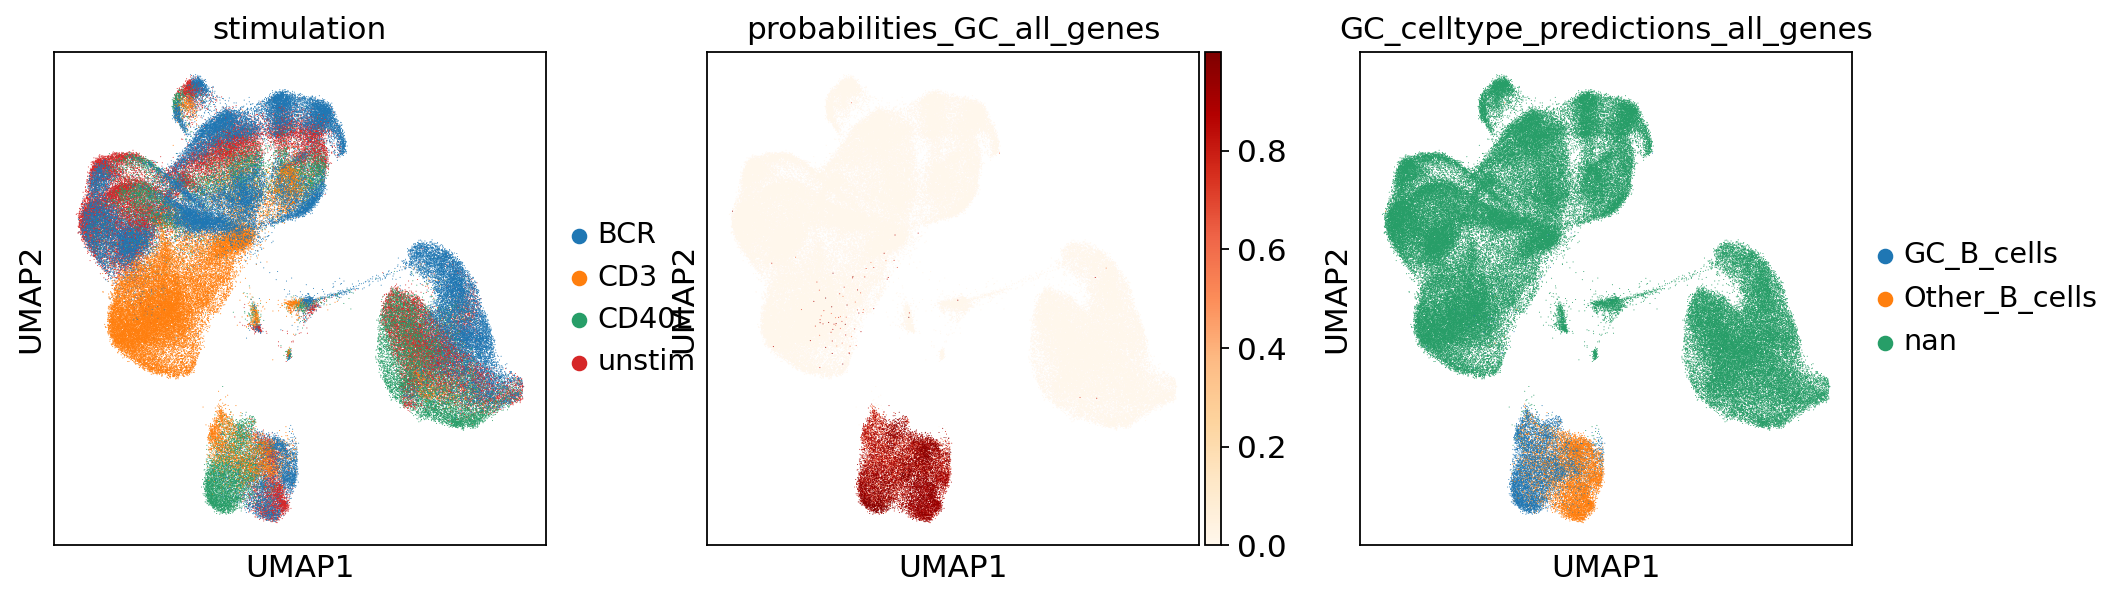

In [74]:
sc.pl.umap(adata_hvg, color=['stimulation', 'probabilities_GC_all_genes', 'GC_celltype_predictions_all_genes'], cmap = 'OrRd')

In [43]:
adata_raw.obs['GC_celltype_predictions_all_genes'] = adata_hvg.obs.loc[adata_raw.obs_names, 'GC_celltype_predictions_all_genes']

In [44]:
adata_raw_validation_cohort.obs['GC_celltype_predictions_all_genes'] = adata_raw.obs.loc[adata_raw_validation_cohort.obs_names,
                                                                                         'GC_celltype_predictions_all_genes']

In [45]:
np.unique(adata_raw_validation_cohort.obs['cell_type_final'])

array(['B_cells_memory', 'B_cells_naive', 'MAIT_cells', 'Macrophages',
       'Monocytes_CD16+', 'Monocytes_Classical', 'NK_CD16_bright',
       'NK_CD56_bright', 'Plasma_cells', 'Precursor_Cells', 'TCM_CD8+',
       'TEM_CD8+', 'TMRA_CD8+', 'T_cells_CD4+_activated',
       'T_cells_CD4+_memory', 'T_cells_CD4+_naive',
       'T_cells_CD8+_activated', 'T_cells_CD8+_naive', 'cDC1', 'cDC2',
       'gdT_cells', 'iNKT_cells', 'pDCs'], dtype=object)

In [46]:
# considering only naive and memory B cells, but NOT plasma cells
adata_raw_validation_cohort_GC_like_cells = adata_raw_validation_cohort[(adata_raw_validation_cohort.obs['GC_celltype_predictions_all_genes'] == 'GC_B_cells')
                                   & (adata_raw_validation_cohort.obs['cell_type_final'] != 'Plasma_cells')].copy()

In [47]:
adata_raw_validation_cohort_GC_like_cells

AnnData object with n_obs × n_vars = 5709 × 22144
    obs: 'n_genes', 'stimulation', 'sample', 'cell_id', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'cell_type_final', 'celltype_condition', 'donor', 'GC_celltype_predictions_all_genes'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-10', 'feature_types-10', 'genome-10', 'n_cells-10', 'gene_ids-11', 'feature_types-11', 'genome-11', 'n_cells-11', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'genome-5', 'n_cells-5', 'gene_ids-6', 'feature_types-6', 'genome-6', 'n_cells-6', 'gene_ids-7', 'feature_types-7', 'genome-7', 'n_cells-7', 'gene_ids-8', 'feature_types-8', 'genome-8', 'n_cells-8', 'gene_ids-9', 'feature_

In [48]:
np.unique(adata_raw_validation_cohort_GC_like_cells.obs['GC_celltype_predictions_all_genes'])

array(['GC_B_cells'], dtype=object)

In [81]:
%%time

# filtering genes on a per cell_type basis, for all GC-like cells (exc plasma cells)
filtered_genes_GC_like_cells_validation_cohort = {}

for celltype in np.unique(adata_raw_validation_cohort_GC_like_cells.obs['GC_celltype_predictions_all_genes']):
    print(celltype)
    curr_expr_mtx = expr_mtx_df_normlog.loc[adata_raw_validation_cohort_GC_like_cells[adata_raw_validation_cohort_GC_like_cells.obs['GC_celltype_predictions_all_genes'] == celltype].obs.index,:]
    curr_expr_mtx.loc['mean'] = curr_expr_mtx.mean()
    # for easier filtering
    curr_expr_mtx = curr_expr_mtx.T
    filtered_genes_GC_like_cells_validation_cohort[celltype] = list(curr_expr_mtx[curr_expr_mtx['mean'] > 0.1].index)
    print('filtered genes:', len(filtered_genes_GC_like_cells_validation_cohort[celltype]))

GC_B_cells
filtered genes: 5339
CPU times: user 1.01 s, sys: 472 ms, total: 1.48 s
Wall time: 1.49 s


In [49]:
adata_raw_validation_cohort_GC_like_cells.obs['CVID_status'] = adata_hvg.obs.loc[adata_raw_validation_cohort_GC_like_cells.obs_names, 'CVID_status']
adata_raw_validation_cohort_GC_like_cells.obs['GC_status_condition'] = [i + '_' + j for i,j in zip(adata_raw_validation_cohort_GC_like_cells.obs['GC_celltype_predictions_all_genes'],
                                                                                adata_raw_validation_cohort_GC_like_cells.obs['CVID_status'])]

In [83]:
np.unique(adata_raw_validation_cohort_GC_like_cells.obs['GC_status_condition'])

array(['GC_B_cells_CONTROL', 'GC_B_cells_CVID'], dtype=object)

In [84]:
# generating tables to use in DESeq2 of cells from all donors

DE_tables_GC_like_cells_validation_cohort = {}

for cell_type in np.unique(adata_raw_validation_cohort_GC_like_cells.obs['GC_celltype_predictions_all_genes']):
    
    # cell type-specific filtered genes
    curr_filtered_genes = filtered_genes_GC_like_cells_validation_cohort[cell_type]
    
    print(cell_type)
    
    cluster_CVID = cell_type + '_CVID'
    cluster_CONTROL = cell_type + '_CONTROL'
    
    curr_key = cluster_CVID + '_vs_' + cluster_CONTROL
    
    # only filtered genes
    curr_expr_mtx_subset = expr_mtx_df.loc[:,curr_filtered_genes]
    
    DE_tables_GC_like_cells_validation_cohort[curr_key] = generate_deseq2_tables(curr_expr_mtx_subset, adata_raw_validation_cohort_GC_like_cells, 
                                                                       'GC_status_condition', cluster_CVID, cluster_CONTROL,
                                                                       'sample')
    
    DE_tables_GC_like_cells_validation_cohort[curr_key]['cnt_table'].to_csv('./DESeq2_data/input_tables/cnt_table_' + cluster_CVID + '_vs_' + cluster_CONTROL + '_validation_cohort.csv')
    DE_tables_GC_like_cells_validation_cohort[curr_key]['coldata'].to_csv('./DESeq2_data/input_tables/coldata_table_' + cluster_CVID + '_vs_' + cluster_CONTROL + '_validation_cohort.csv')
    

GC_B_cells
comparing groups GC_B_cells_CVID and GC_B_cells_CONTROL
samples in GC_B_cells_CVID group: ['35008_CV005_RV9039258_and_35008_CV005_RV9039282', '35008_CV005_RV9039259_and_35008_CV005_RV9039283', '35008_CV005_RV9039260_and_35008_CV005_RV9039284', '35008_CV005_RV9039261_and_35008_CV005_RV9039285', '35008_CV005_RV9039262_and_35008_CV005_RV9039286', '35008_CV005_RV9039263_and_35008_CV005_RV9039287', '35008_CV005_RV9039264_and_35008_CV005_RV9039288', '35008_CV005_RV9039265_and_35008_CV005_RV9039289', '35171_CV005_RV9039361', '35171_CV005_RV9039362', '35171_CV005_RV9039363', '35171_CV005_RV9039364']
samples in GC_B_cells_CONTROL group: ['35008_CV005_RV9039258_and_35008_CV005_RV9039282', '35008_CV005_RV9039259_and_35008_CV005_RV9039283', '35008_CV005_RV9039260_and_35008_CV005_RV9039284', '35008_CV005_RV9039261_and_35008_CV005_RV9039285', '35008_CV005_RV9039262_and_35008_CV005_RV9039286', '35008_CV005_RV9039263_and_35008_CV005_RV9039287', '35008_CV005_RV9039264_and_35008_CV005_RV90392

In [85]:
DE_tables_GC_like_cells_validation_cohort['GC_B_cells_CVID_vs_GC_B_cells_CONTROL']['cnt_table'].sum()

group_GC_B_cells_CVID_batch_35008_CV005_RV9039265_and_35008_CV005_RV9039289          57414.0
group_GC_B_cells_CVID_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283          42565.0
group_GC_B_cells_CVID_batch_35008_CV005_RV9039262_and_35008_CV005_RV9039286        1185918.0
group_GC_B_cells_CVID_batch_35171_CV005_RV9039361                                   398152.0
group_GC_B_cells_CVID_batch_35008_CV005_RV9039263_and_35008_CV005_RV9039287         787478.0
group_GC_B_cells_CVID_batch_35008_CV005_RV9039261_and_35008_CV005_RV9039285        3883087.0
group_GC_B_cells_CVID_batch_35171_CV005_RV9039363                                  4970121.0
group_GC_B_cells_CVID_batch_35008_CV005_RV9039260_and_35008_CV005_RV9039284        2758354.0
group_GC_B_cells_CVID_batch_35171_CV005_RV9039362                                 19384736.0
group_GC_B_cells_CVID_batch_35171_CV005_RV9039364                                   328524.0
group_GC_B_cells_CONTROL_batch_35008_CV005_RV9039265_and_35008_CV005_R

In [86]:
np.unique(adata_raw_validation_cohort_GC_like_cells.obs['GC_celltype_predictions_all_genes'])

array(['GC_B_cells'], dtype=object)

In [87]:
%%R
# all donors, only GC-like B cells (naive and memory, but NOT plasma cells)
celltypes = list('GC_B_cells')

for (celltype in celltypes)
{
    print(sample)
    cts <- read.csv(file = paste('./DESeq2_data/input_tables/cnt_table_', celltype, '_CVID_vs_', celltype, '_CONTROL_validation_cohort.csv', sep=''))
    coldata <- read.csv(file = paste('./DESeq2_data/input_tables/coldata_table_', celltype, '_CVID_vs_', celltype, '_CONTROL_validation_cohort.csv', sep=''))
    rownames(cts) <- cts$Gene
    cts <- within(cts, rm(Gene))
    dds <- DESeqDataSetFromMatrix(countData = cts,
                              colData = coldata,
                              design= ~ group)
    
    dds <- DESeq(dds)
    
    # these 3 following commands do DESeq(dds), I had to change an argument in estimateSizeFactors, so running them one by one instead of this 1 command)
    #dds <- estimateSizeFactors(dds, type='iterate'
    #                          )
    #dds <- estimateDispersions(dds)
    #dds <- nbinomWaldTest(dds)
    
    
    res <- results(dds,contrast=c("group",
                                  paste(celltype, '_CVID', sep=''),
                                  paste(celltype, '_CONTROL', sep='')))
    
    write.table(res, paste('./DESeq2_data/results/all_donors/20210112_DESeq2_DEG_', celltype, '_CVID_vs_', celltype, '_CONTROL_validation_cohort.csv', sep=''),
                append = FALSE, sep = ",",
                row.names = TRUE, col.names = TRUE)
}                  

function (x, size, replace = FALSE, prob = NULL) 
{
    if (length(x) == 1L && is.numeric(x) && is.finite(x) && x >= 
        1) {
        if (missing(size)) 
            size <- x
        sample.int(x, size, replace, prob)
    }
    else {
        if (missing(size)) 
            size <- length(x)
        x[sample.int(length(x), size, replace, prob)]
    }
}
<bytecode: 0x56477d662d38>
<environment: namespace:base>


R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 19 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



In [51]:
adata_raw_GC_like_cells_twins = adata_raw[(adata_raw.obs['GC_celltype_predictions_all_genes'] == 'GC_B_cells')
                                   & (adata_raw.obs['cell_type_final'] != 'Plasma_cells')
                                                           & (adata_raw.obs['donor'].isin(['CONTROL_twin',
                                                                                                   'CVID_twin']))].copy()

In [52]:
# same but for twins only
np.unique(adata_raw_GC_like_cells_twins.obs['donor'])

array(['CONTROL_twin', 'CVID_twin'], dtype=object)

In [53]:
# same but for twins only
np.unique(adata_raw_GC_like_cells_twins.obs['GC_celltype_predictions_all_genes'])

array(['GC_B_cells'], dtype=object)

In [288]:
%%time

# filtering genes on a per cell_type basis, for all GC-like cells (exc plasma cells)
filtered_genes_GC_like_cells_twins = {}

for celltype in np.unique(adata_raw_GC_like_cells_twins.obs['GC_celltype_predictions_all_genes']):
    print(celltype)
    curr_expr_mtx = expr_mtx_df_normlog.loc[adata_raw_GC_like_cells_twins[adata_raw_GC_like_cells_twins.obs['GC_celltype_predictions_all_genes'] == celltype].obs.index,:]
    curr_expr_mtx.loc['mean'] = curr_expr_mtx.mean()
    # for easier filtering
    curr_expr_mtx = curr_expr_mtx.T
    filtered_genes_GC_like_cells_twins[celltype] = list(curr_expr_mtx[curr_expr_mtx['mean'] > 0.1].index)
    print('filtered genes:', len(filtered_genes_GC_like_cells_twins[celltype]))

GC_B_cells
filtered genes: 5095
CPU times: user 328 ms, sys: 52 ms, total: 380 ms
Wall time: 379 ms


In [291]:
# generating tables to use in DESeq2 of cells from all donors

DE_tables_twins_GC_like_cells = {}

for cell_type in np.unique(adata_raw_GC_like_cells_twins.obs['GC_celltype_predictions_all_genes']):
    
    # cell type-specific filtered genes
    curr_filtered_genes = filtered_genes_GC_like_cells_twins[cell_type]
    
    print(cell_type)
    
    cluster_CVID = cell_type + '_CVID'
    cluster_CONTROL = cell_type + '_CONTROL'
    
    curr_key = cluster_CVID + '_vs_' + cluster_CONTROL
    
    # only filtered genes
    curr_expr_mtx_subset = expr_mtx_df.loc[:,curr_filtered_genes]
    
    DE_tables_twins_GC_like_cells[curr_key] = generate_deseq2_tables(curr_expr_mtx_subset, adata_raw_GC_like_cells_twins, 
                                                                       'GC_status_condition', cluster_CVID, cluster_CONTROL,
                                                                       'sample',
                                                                    mode='twins')
    
    DE_tables_twins_GC_like_cells[curr_key]['cnt_table'].to_csv('./DESeq2_data/input_tables/cnt_table_' + cluster_CVID + '_vs_' + cluster_CONTROL + '_twins.csv')
    DE_tables_twins_GC_like_cells[curr_key]['coldata'].to_csv('./DESeq2_data/input_tables/coldata_table_' + cluster_CVID + '_vs_' + cluster_CONTROL + '_twins.csv')
    

GC_B_cells
comparing groups GC_B_cells_CVID and GC_B_cells_CONTROL
samples in GC_B_cells_CVID group: ['35008_CV005_RV9039259_and_35008_CV005_RV9039283', '35008_CV005_RV9039261_and_35008_CV005_RV9039285', '35008_CV005_RV9039263_and_35008_CV005_RV9039287', '35008_CV005_RV9039265_and_35008_CV005_RV9039289']
samples in GC_B_cells_CONTROL group: ['35008_CV005_RV9039258_and_35008_CV005_RV9039282', '35008_CV005_RV9039260_and_35008_CV005_RV9039284', '35008_CV005_RV9039262_and_35008_CV005_RV9039286', '35008_CV005_RV9039264_and_35008_CV005_RV9039288']
twin mode, union of samples: ['35008_CV005_RV9039262_and_35008_CV005_RV9039286', '35008_CV005_RV9039265_and_35008_CV005_RV9039289', '35008_CV005_RV9039261_and_35008_CV005_RV9039285', '35008_CV005_RV9039264_and_35008_CV005_RV9039288', '35008_CV005_RV9039263_and_35008_CV005_RV9039287', '35008_CV005_RV9039259_and_35008_CV005_RV9039283', '35008_CV005_RV9039260_and_35008_CV005_RV9039284', '35008_CV005_RV9039258_and_35008_CV005_RV9039282']
samples in thi

In [292]:
DE_tables_twins_GC_like_cells['GC_B_cells_CVID_vs_GC_B_cells_CONTROL']['cnt_table'].sum()

group_GC_B_cells_CVID_batch_35008_CV005_RV9039262_and_35008_CV005_RV9039286             0.0
group_GC_B_cells_CVID_batch_35008_CV005_RV9039265_and_35008_CV005_RV9039289         17285.0
group_GC_B_cells_CVID_batch_35008_CV005_RV9039261_and_35008_CV005_RV9039285       1385905.0
group_GC_B_cells_CVID_batch_35008_CV005_RV9039263_and_35008_CV005_RV9039287         95604.0
group_GC_B_cells_CVID_batch_35008_CV005_RV9039260_and_35008_CV005_RV9039284             0.0
group_GC_B_cells_CONTROL_batch_35008_CV005_RV9039262_and_35008_CV005_RV9039286     146429.0
group_GC_B_cells_CONTROL_batch_35008_CV005_RV9039265_and_35008_CV005_RV9039289          0.0
group_GC_B_cells_CONTROL_batch_35008_CV005_RV9039261_and_35008_CV005_RV9039285          0.0
group_GC_B_cells_CONTROL_batch_35008_CV005_RV9039263_and_35008_CV005_RV9039287          0.0
group_GC_B_cells_CONTROL_batch_35008_CV005_RV9039260_and_35008_CV005_RV9039284    2106217.0
dtype: float64

In [298]:
# renaming columns etc.

In [294]:
# here I'm manually labeling corresponding samples into 'batch_1' and so on
# where batch_1 is 35008_CV005_RV9039258_and_35008_CV005_RV9039282, 35008_CV005_RV9039259_and_35008_CV005_RV9039283
# batch_2 is 35008_CV005_RV9039260_and_35008_CV005_RV9039284, 35008_CV005_RV9039261_and_35008_CV005_RV9039285
# batch_3 is 35008_CV005_RV9039262_and_35008_CV005_RV9039286, 35008_CV005_RV9039263_and_35008_CV005_RV9039287
# batch_4 is 35008_CV005_RV9039264_and_35008_CV005_RV9039288, 35008_CV005_RV9039265_and_35008_CV005_RV9039289

In [295]:
def rename_columns(col_old):
    
    curr_batch = col_old.split('_batch_')[1]
    
    if curr_batch in ['35008_CV005_RV9039258_and_35008_CV005_RV9039282', '35008_CV005_RV9039259_and_35008_CV005_RV9039283']:
        col_new = col_old.split('_batch_')[0] + '_batch_1'
        return(col_new)
    elif curr_batch in ['35008_CV005_RV9039260_and_35008_CV005_RV9039284', '35008_CV005_RV9039261_and_35008_CV005_RV9039285']:
        col_new = col_old.split('_batch_')[0] + '_batch_2'
        return(col_new)
    elif curr_batch in ['35008_CV005_RV9039262_and_35008_CV005_RV9039286', '35008_CV005_RV9039263_and_35008_CV005_RV9039287']:
        col_new = col_old.split('_batch_')[0] + '_batch_3'
        return(col_new)
    elif curr_batch in ['35008_CV005_RV9039264_and_35008_CV005_RV9039288', '35008_CV005_RV9039265_and_35008_CV005_RV9039289']:
        col_new = col_old.split('_batch_')[0] + '_batch_4'
        return(col_new)
    else:
        return('none')
    

In [296]:
# dropping if sum in minibatch = 0
for cell_type in np.unique(adata_raw_GC_like_cells_twins.obs['GC_celltype_predictions_all_genes']):
    print(cell_type)
    curr_key = cell_type + '_CVID_vs_' + cell_type + '_CONTROL'
    
    sum_vector = list(DE_tables_twins_GC_like_cells[curr_key]['cnt_table'].sum())
    columns_vector = list(DE_tables_twins_GC_like_cells[curr_key]['cnt_table'].columns)
    cols2keep = [columns_vector[i] for i in range(len(columns_vector)) if (sum_vector[i] > 0)]
    
    DE_tables_twins_GC_like_cells[curr_key]['cnt_table'] = DE_tables_twins_GC_like_cells[curr_key]['cnt_table'][cols2keep]
    
    DE_tables_twins_GC_like_cells[curr_key]['coldata'] = DE_tables_twins_GC_like_cells[curr_key]['coldata'].loc[cols2keep,:]
    

GC_B_cells


In [297]:
DE_tables_twins_GC_like_cells['GC_B_cells_CVID_vs_GC_B_cells_CONTROL']['cnt_table'].sum()

group_GC_B_cells_CVID_batch_35008_CV005_RV9039265_and_35008_CV005_RV9039289         17285.0
group_GC_B_cells_CVID_batch_35008_CV005_RV9039261_and_35008_CV005_RV9039285       1385905.0
group_GC_B_cells_CVID_batch_35008_CV005_RV9039263_and_35008_CV005_RV9039287         95604.0
group_GC_B_cells_CONTROL_batch_35008_CV005_RV9039262_and_35008_CV005_RV9039286     146429.0
group_GC_B_cells_CONTROL_batch_35008_CV005_RV9039260_and_35008_CV005_RV9039284    2106217.0
dtype: float64

In [299]:
# renaming columns and indices in twin tables

DE_tables_twins_GC_like_cells_corrected = {}

for cell_type in np.unique(adata_raw_GC_like_cells_twins.obs['GC_celltype_predictions_all_genes']):
    print(cell_type)
    curr_key = cell_type + '_CVID_vs_' + cell_type + '_CONTROL'
    DE_tables_twins_GC_like_cells_corrected[curr_key] = DE_tables_twins_GC_like_cells[curr_key]
    
    # renaming columns in cnt_table and indices in coldata
    DE_tables_twins_GC_like_cells_corrected[curr_key]['cnt_table'].columns = [rename_columns(col) for col in DE_tables_twins_GC_like_cells_corrected[curr_key]['cnt_table'].columns]
    DE_tables_twins_GC_like_cells_corrected[curr_key]['coldata'].index = [rename_columns(col) for col in DE_tables_twins_GC_like_cells_corrected[curr_key]['coldata'].index]
    
    cluster_CVID = cell_type + '_CVID'
    cluster_CONTROL = cell_type + '_CONTROL'
    
    # saving
    DE_tables_twins_GC_like_cells_corrected[curr_key]['cnt_table'].to_csv('./DESeq2_data/input_tables/cnt_table_' + cluster_CVID + '_vs_' + cluster_CONTROL + '_twins.csv')
    DE_tables_twins_GC_like_cells_corrected[curr_key]['coldata'].to_csv('./DESeq2_data/input_tables/coldata_table_' + cluster_CVID + '_vs_' + cluster_CONTROL + '_twins.csv')
    
    
        

GC_B_cells


In [300]:
DE_tables_twins_GC_like_cells_corrected['GC_B_cells_CVID_vs_GC_B_cells_CONTROL']['cnt_table'].sum()

group_GC_B_cells_CVID_batch_4         17285.0
group_GC_B_cells_CVID_batch_2       1385905.0
group_GC_B_cells_CVID_batch_3         95604.0
group_GC_B_cells_CONTROL_batch_3     146429.0
group_GC_B_cells_CONTROL_batch_2    2106217.0
dtype: float64

In [302]:
DE_tables_twins_GC_like_cells_corrected['GC_B_cells_CVID_vs_GC_B_cells_CONTROL']['coldata']

group
group_GC_B_cells_CVID_batch_4        GC_B_cells_CVID
group_GC_B_cells_CVID_batch_2        GC_B_cells_CVID
group_GC_B_cells_CVID_batch_3        GC_B_cells_CVID
group_GC_B_cells_CONTROL_batch_3  GC_B_cells_CONTROL
group_GC_B_cells_CONTROL_batch_2  GC_B_cells_CONTROL

In [305]:
cols2keep = DE_tables_twins_GC_like_cells_corrected['GC_B_cells_CVID_vs_GC_B_cells_CONTROL']['cnt_table'].columns[1:]
cols2keep

Index(['group_GC_B_cells_CVID_batch_2', 'group_GC_B_cells_CVID_batch_3',
       'group_GC_B_cells_CONTROL_batch_3', 'group_GC_B_cells_CONTROL_batch_2'],
      dtype='object')

In [306]:
DE_tables_twins_GC_like_cells_corrected['GC_B_cells_CVID_vs_GC_B_cells_CONTROL']['cnt_table'][cols2keep]

group_GC_B_cells_CVID_batch_2  \
Gene                                                    
A1BG                                             31.0   
AAAS                                             71.0   
AAGAB                                            65.0   
AAMP                                            162.0   
AARS                                             92.0   
...                                               ...   
anti-c-Met                                      366.0   
humanCD207                                      437.0   
humanMac-2(Galectin-3)                          943.0   
mouse/ratCD278(ICOS)                            177.0   
mouseintegrinB7                                 315.0   

                        group_GC_B_cells_CVID_batch_3  \
Gene                                                    
A1BG                                              0.0   
AAAS                                              2.0   
AAGAB                                             3.0   
AAMP                                              4.0   
AARS                                              3.0   
...                                               ...   
anti-c-Met                                       92.0   
humanCD207                                      134.0   
humanMac-2(Galectin-3)                          318.0   
mouse/ratCD278(ICOS)                            894.0   
mouseintegrinB7                                 106.0   

                        group_GC_B_cells_CONTROL_batch_3  \
Gene                                                       
A1BG                                                 2.0   
AAAS                                                 8.0   
AAGAB                                                8.0   
AAMP                                                18.0   
AARS                                                 6.0   
...                                                  ...   
anti-c-Met                                          95.0   
humanCD207                                         122.0   
humanMac-2(Galectin-3)                             260.0   
mouse/ratCD278(ICOS)                              1487.0   
mouseintegrinB7                                    139.0   

                        group_GC_B_cells_CONTROL_batch_2  
Gene                                                      
A1BG                                                51.0  
AAAS                                               116.0  
AAGAB                                              106.0  
AAMP                                               256.0  
AARS                                               117.0  
...                                                  ...  
anti-c-Met                                         717.0  
humanCD207                                         979.0  
humanMac-2(Galectin-3)                            1933.0  
mouse/ratCD278(ICOS)                               362.0  
mouseintegrinB7                                    611.0  

[5095 rows x 4 columns]

In [307]:
DE_tables_twins_GC_like_cells_corrected['GC_B_cells_CVID_vs_GC_B_cells_CONTROL']['coldata'].loc[cols2keep,:]

group
group_GC_B_cells_CVID_batch_2        GC_B_cells_CVID
group_GC_B_cells_CVID_batch_3        GC_B_cells_CVID
group_GC_B_cells_CONTROL_batch_3  GC_B_cells_CONTROL
group_GC_B_cells_CONTROL_batch_2  GC_B_cells_CONTROL

In [308]:
# removing minibatch group_GC_B_cells_CVID_batch_4 for symmetry & resaving
DE_tables_twins_GC_like_cells_corrected['GC_B_cells_CVID_vs_GC_B_cells_CONTROL']['cnt_table'] = DE_tables_twins_GC_like_cells_corrected['GC_B_cells_CVID_vs_GC_B_cells_CONTROL']['cnt_table'][cols2keep]
DE_tables_twins_GC_like_cells_corrected['GC_B_cells_CVID_vs_GC_B_cells_CONTROL']['coldata'] = DE_tables_twins_GC_like_cells_corrected['GC_B_cells_CVID_vs_GC_B_cells_CONTROL']['coldata'].loc[cols2keep,:]

In [310]:
DE_tables_twins_GC_like_cells_corrected['GC_B_cells_CVID_vs_GC_B_cells_CONTROL']['coldata']

group
group_GC_B_cells_CVID_batch_2        GC_B_cells_CVID
group_GC_B_cells_CVID_batch_3        GC_B_cells_CVID
group_GC_B_cells_CONTROL_batch_3  GC_B_cells_CONTROL
group_GC_B_cells_CONTROL_batch_2  GC_B_cells_CONTROL

In [311]:
DE_tables_twins_GC_like_cells_corrected['GC_B_cells_CVID_vs_GC_B_cells_CONTROL']['cnt_table']

group_GC_B_cells_CVID_batch_2  \
Gene                                                    
A1BG                                             31.0   
AAAS                                             71.0   
AAGAB                                            65.0   
AAMP                                            162.0   
AARS                                             92.0   
...                                               ...   
anti-c-Met                                      366.0   
humanCD207                                      437.0   
humanMac-2(Galectin-3)                          943.0   
mouse/ratCD278(ICOS)                            177.0   
mouseintegrinB7                                 315.0   

                        group_GC_B_cells_CVID_batch_3  \
Gene                                                    
A1BG                                              0.0   
AAAS                                              2.0   
AAGAB                                             3.0   
AAMP                                              4.0   
AARS                                              3.0   
...                                               ...   
anti-c-Met                                       92.0   
humanCD207                                      134.0   
humanMac-2(Galectin-3)                          318.0   
mouse/ratCD278(ICOS)                            894.0   
mouseintegrinB7                                 106.0   

                        group_GC_B_cells_CONTROL_batch_3  \
Gene                                                       
A1BG                                                 2.0   
AAAS                                                 8.0   
AAGAB                                                8.0   
AAMP                                                18.0   
AARS                                                 6.0   
...                                                  ...   
anti-c-Met                                          95.0   
humanCD207                                         122.0   
humanMac-2(Galectin-3)                             260.0   
mouse/ratCD278(ICOS)                              1487.0   
mouseintegrinB7                                    139.0   

                        group_GC_B_cells_CONTROL_batch_2  
Gene                                                      
A1BG                                                51.0  
AAAS                                               116.0  
AAGAB                                              106.0  
AAMP                                               256.0  
AARS                                               117.0  
...                                                  ...  
anti-c-Met                                         717.0  
humanCD207                                         979.0  
humanMac-2(Galectin-3)                            1933.0  
mouse/ratCD278(ICOS)                               362.0  
mouseintegrinB7                                    611.0  

[5095 rows x 4 columns]

In [312]:
curr_key = 'GC_B_cells_CVID_vs_GC_B_cells_CONTROL'

DE_tables_twins_GC_like_cells_corrected[curr_key]['cnt_table'].to_csv('./DESeq2_data/input_tables/cnt_table_GC_B_cells_CVID_vs_GC_B_cells_CONTROL_twins.csv')
DE_tables_twins_GC_like_cells_corrected[curr_key]['coldata'].to_csv('./DESeq2_data/input_tables/coldata_table_GC_B_cells_CVID_vs_GC_B_cells_CONTROL_twins.csv')

In [313]:
np.unique(adata_raw_GC_like_cells_twins.obs['GC_celltype_predictions_all_genes'])

array(['GC_B_cells'], dtype=object)

In [315]:
%%R
# twins only
celltypes = list('GC_B_cells')

for (celltype in celltypes)
{
    print(sample)
    cts <- read.csv(file = paste('./DESeq2_data/input_tables/cnt_table_', celltype, '_CVID_vs_', celltype, '_CONTROL_twins.csv', sep=''))
    coldata <- read.csv(file = paste('./DESeq2_data/input_tables/coldata_table_', celltype, '_CVID_vs_', celltype, '_CONTROL_twins.csv', sep=''))
    rownames(cts) <- cts$Gene
    cts <- within(cts, rm(Gene))
    dds <- DESeqDataSetFromMatrix(countData = cts,
                              colData = coldata,
                              design= ~ group)
    
    dds <- DESeq(dds)
    
    # these 3 following commands do DESeq(dds), I had to change an argument in estimateSizeFactors, so running them one by one instead of this 1 command)
    #dds <- estimateSizeFactors(dds, type='iterate'
    #                          )
    #dds <- estimateDispersions(dds)
    #dds <- nbinomWaldTest(dds)
    
    
    res <- results(dds,contrast=c("group",
                                  paste(celltype, '_CVID', sep=''),
                                  paste(celltype, '_CONTROL', sep='')))
    
    write.table(res, paste('./DESeq2_data/results/twins/20210112_DESeq2_DEG_', celltype, '_CVID_vs_', celltype, '_CONTROL_twins.csv', sep=''),
                append = FALSE, sep = ",",
                row.names = TRUE, col.names = TRUE)
}                  

function (x, size, replace = FALSE, prob = NULL) 
{
    if (length(x) == 1L && is.numeric(x) && is.finite(x) && x >= 
        1) {
        if (missing(size)) 
            size <- x
        sample.int(x, size, replace, prob)
    }
    else {
        if (missing(size)) 
            size <- length(x)
        x[sample.int(length(x), size, replace, prob)]
    }
}
<bytecode: 0x55a4d1902418>
<environment: namespace:base>


R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



# Comparison (CVID vs healthy) in stimulation groups for all B cells together (except Plasma cells)

In [54]:
np.unique(adata_raw_validation_cohort.obs['cell_type_final'])

array(['B_cells_memory', 'B_cells_naive', 'MAIT_cells', 'Macrophages',
       'Monocytes_CD16+', 'Monocytes_Classical', 'NK_CD16_bright',
       'NK_CD56_bright', 'Plasma_cells', 'Precursor_Cells', 'TCM_CD8+',
       'TEM_CD8+', 'TMRA_CD8+', 'T_cells_CD4+_activated',
       'T_cells_CD4+_memory', 'T_cells_CD4+_naive',
       'T_cells_CD8+_activated', 'T_cells_CD8+_naive', 'cDC1', 'cDC2',
       'gdT_cells', 'iNKT_cells', 'pDCs'], dtype=object)

In [55]:
adata_raw_validation_cohort

AnnData object with n_obs × n_vars = 133818 × 22144
    obs: 'n_genes', 'stimulation', 'sample', 'cell_id', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'cell_type_final', 'celltype_condition', 'donor', 'GC_celltype_predictions_all_genes'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-10', 'feature_types-10', 'genome-10', 'n_cells-10', 'gene_ids-11', 'feature_types-11', 'genome-11', 'n_cells-11', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'genome-5', 'n_cells-5', 'gene_ids-6', 'feature_types-6', 'genome-6', 'n_cells-6', 'gene_ids-7', 'feature_types-7', 'genome-7', 'n_cells-7', 'gene_ids-8', 'feature_types-8', 'genome-8', 'n_cells-8', 'gene_ids-9', 'featur

In [56]:
adata_raw_validation_cohort.obs['CVID_status'] = adata_hvg.obs.loc[adata_raw_validation_cohort.obs_names, 'CVID_status']

In [57]:
adata_raw_validation_cohort_naive_memory_B_cells = adata_raw_validation_cohort[adata_raw_validation_cohort.obs['cell_type_final'].isin(['B_cells_memory', 
                                                                                  'B_cells_naive'])].copy()

In [58]:
adata_raw_validation_cohort_naive_memory_B_cells.obs['stimulation_CVID_status'] = [i + '_' + j for i,j in zip(adata_raw_validation_cohort_naive_memory_B_cells.obs['stimulation'],
                                                                                           adata_raw_validation_cohort_naive_memory_B_cells.obs['CVID_status'])]

In [59]:
np.unique(adata_raw_validation_cohort_naive_memory_B_cells.obs['stimulation'], return_counts=True)

(array(['BCR', 'CD3', 'CD40L', 'unstim'], dtype=object),
 array([2612, 2747, 4446, 2649]))

In [94]:
%%time

# filtering genes on a per cell_type basis, for all GC-like cells (exc plasma cells)
filtered_genes_by_stimulation_validation_cohort = {}

for celltype in np.unique(adata_raw_validation_cohort_naive_memory_B_cells.obs['stimulation']):
    print(celltype)
    curr_expr_mtx = expr_mtx_df_normlog.loc[adata_raw_validation_cohort_naive_memory_B_cells[adata_raw_validation_cohort_naive_memory_B_cells.obs['stimulation'] == celltype].obs.index,:]
    curr_expr_mtx.loc['mean'] = curr_expr_mtx.mean()
    # for easier filtering
    curr_expr_mtx = curr_expr_mtx.T
    filtered_genes_by_stimulation_validation_cohort[celltype] = list(curr_expr_mtx[curr_expr_mtx['mean'] > 0.1].index)
    print('filtered genes:', len(filtered_genes_by_stimulation_validation_cohort[celltype]))

BCR
filtered genes: 3743
CD3
filtered genes: 4471
CD40L
filtered genes: 5541
unstim
filtered genes: 3390
CPU times: user 2.09 s, sys: 928 ms, total: 3.02 s
Wall time: 3.02 s


In [95]:
np.unique(adata_raw_validation_cohort_naive_memory_B_cells.obs['stimulation_CVID_status'])

array(['BCR_CONTROL', 'BCR_CVID', 'CD3_CONTROL', 'CD3_CVID',
       'CD40L_CONTROL', 'CD40L_CVID', 'unstim_CONTROL', 'unstim_CVID'],
      dtype=object)

In [96]:
# generating tables to use in DESeq2 of cells from all donors

DE_tables_by_stimulation_validation_cohort = {}

for cell_type in np.unique(adata_raw_validation_cohort_naive_memory_B_cells.obs['stimulation']):
    
    # cell type-specific filtered genes
    curr_filtered_genes = filtered_genes_by_stimulation_validation_cohort[cell_type]
    
    print(cell_type)
    
    cluster_CVID = cell_type + '_CVID'
    cluster_CONTROL = cell_type + '_CONTROL'
    
    curr_key = cluster_CVID + '_vs_' + cluster_CONTROL
    
    # only filtered genes
    curr_expr_mtx_subset = expr_mtx_df.loc[:,curr_filtered_genes]
    
    DE_tables_by_stimulation_validation_cohort[curr_key] = generate_deseq2_tables(curr_expr_mtx_subset, adata_raw_validation_cohort_naive_memory_B_cells, 
                                                                       'stimulation_CVID_status', cluster_CVID, cluster_CONTROL,
                                                                       'sample')
    
    DE_tables_by_stimulation_validation_cohort[curr_key]['cnt_table'].to_csv('./DESeq2_data/input_tables/cnt_table_' + cluster_CVID + '_vs_' + cluster_CONTROL + '_validation_cohort.csv')
    DE_tables_by_stimulation_validation_cohort[curr_key]['coldata'].to_csv('./DESeq2_data/input_tables/coldata_table_' + cluster_CVID + '_vs_' + cluster_CONTROL + '_validation_cohort.csv')
    

BCR
comparing groups BCR_CVID and BCR_CONTROL
samples in BCR_CVID group: ['35008_CV005_RV9039264_and_35008_CV005_RV9039288', '35008_CV005_RV9039265_and_35008_CV005_RV9039289', '35171_CV005_RV9039364']
samples in BCR_CONTROL group: ['35008_CV005_RV9039264_and_35008_CV005_RV9039288', '35008_CV005_RV9039265_and_35008_CV005_RV9039289', '35171_CV005_RV9039364']
all donors mode, common samples: ['35008_CV005_RV9039265_and_35008_CV005_RV9039289', '35008_CV005_RV9039264_and_35008_CV005_RV9039288', '35171_CV005_RV9039364']
samples in this run with >  10  cells in each condition: 3 ['35008_CV005_RV9039265_and_35008_CV005_RV9039289', '35008_CV005_RV9039264_and_35008_CV005_RV9039288', '35171_CV005_RV9039364']
CD3
comparing groups CD3_CVID and CD3_CONTROL
samples in CD3_CVID group: ['35008_CV005_RV9039262_and_35008_CV005_RV9039286', '35008_CV005_RV9039263_and_35008_CV005_RV9039287', '35171_CV005_RV9039363']
samples in CD3_CONTROL group: ['35008_CV005_RV9039262_and_35008_CV005_RV9039286', '35008_CV0

In [99]:
DE_tables_by_stimulation_validation_cohort['unstim_CVID_vs_unstim_CONTROL']['cnt_table'].sum()

group_unstim_CVID_batch_35008_CV005_RV9039258_and_35008_CV005_RV9039282        471812.0
group_unstim_CVID_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283        782806.0
group_unstim_CVID_batch_35171_CV005_RV9039361                                 3818323.0
group_unstim_CONTROL_batch_35008_CV005_RV9039258_and_35008_CV005_RV9039282     263425.0
group_unstim_CONTROL_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283     725632.0
group_unstim_CONTROL_batch_35171_CV005_RV9039361                              2217445.0
dtype: float64

In [100]:
np.unique(adata_raw_validation_cohort_naive_memory_B_cells.obs['stimulation'])

array(['BCR', 'CD3', 'CD40L', 'unstim'], dtype=object)

In [101]:
%%R
# all donors, only GC-like B cells (naive and memory, but NOT plasma cells)
celltypes = list('BCR', 'CD3', 'CD40L', 'unstim')

for (celltype in celltypes)
{
    print(sample)
    cts <- read.csv(file = paste('./DESeq2_data/input_tables/cnt_table_', celltype, '_CVID_vs_', celltype, '_CONTROL_validation_cohort.csv', sep=''))
    coldata <- read.csv(file = paste('./DESeq2_data/input_tables/coldata_table_', celltype, '_CVID_vs_', celltype, '_CONTROL_validation_cohort.csv', sep=''))
    rownames(cts) <- cts$Gene
    cts <- within(cts, rm(Gene))
    dds <- DESeqDataSetFromMatrix(countData = cts,
                              colData = coldata,
                              design= ~ group)
    
    dds <- DESeq(dds)
    
    # these 3 following commands do DESeq(dds), I had to change an argument in estimateSizeFactors, so running them one by one instead of this 1 command)
    #dds <- estimateSizeFactors(dds, type='iterate'
    #                          )
    #dds <- estimateDispersions(dds)
    #dds <- nbinomWaldTest(dds)
    
    
    res <- results(dds,contrast=c("group",
                                  paste(celltype, '_CVID', sep=''),
                                  paste(celltype, '_CONTROL', sep='')))
    
    write.table(res, paste('./DESeq2_data/results/all_donors/20210112_DESeq2_DEG_naive_and_memory_B_cells_', celltype, '_CVID_vs_', celltype, '_CONTROL_validation_cohort.csv', sep=''),
                append = FALSE, sep = ",",
                row.names = TRUE, col.names = TRUE)
}                  

function (x, size, replace = FALSE, prob = NULL) 
{
    if (length(x) == 1L && is.numeric(x) && is.finite(x) && x >= 
        1) {
        if (missing(size)) 
            size <- x
        sample.int(x, size, replace, prob)
    }
    else {
        if (missing(size)) 
            size <- length(x)
        x[sample.int(length(x), size, replace, prob)]
    }
}
<bytecode: 0x56477d662d38>
<environment: namespace:base>


R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



function (x, size, replace = FALSE, prob = NULL) 
{
    if (length(x) == 1L && is.numeric(x) && is.finite(x) && x >= 
        1) {
        if (missing(size)) 
            size <- x
        sample.int(x, size, replace, prob)
    }
    else {
        if (missing(size)) 
            size <- length(x)
        x[sample.int(length(x), size, replace, prob)]
    }
}
<bytecode: 0x56477d662d38>
<environment: namespace:base>


R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



function (x, size, replace = FALSE, prob = NULL) 
{
    if (length(x) == 1L && is.numeric(x) && is.finite(x) && x >= 
        1) {
        if (missing(size)) 
            size <- x
        sample.int(x, size, replace, prob)
    }
    else {
        if (missing(size)) 
            size <- length(x)
        x[sample.int(length(x), size, replace, prob)]
    }
}
<bytecode: 0x56477d662d38>
<environment: namespace:base>


R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



function (x, size, replace = FALSE, prob = NULL) 
{
    if (length(x) == 1L && is.numeric(x) && is.finite(x) && x >= 
        1) {
        if (missing(size)) 
            size <- x
        sample.int(x, size, replace, prob)
    }
    else {
        if (missing(size)) 
            size <- length(x)
        x[sample.int(length(x), size, replace, prob)]
    }
}
<bytecode: 0x56477d662d38>
<environment: namespace:base>


R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



In [39]:
# same but for twins only
np.unique(adata_raw_naive_memory_B_cells.obs['donor'])

array(['CONTROL1', 'CONTROL2', 'CONTROL3', 'CONTROL4', 'CONTROL5',
       'CONTROL6', 'CONTROL7', 'CONTROL8', 'CONTROL9', 'CONTROL_twin',
       'CVID1', 'CVID18', 'CVID23', 'CVID25', 'CVID29', 'CVID3', 'CVID33',
       'CVID34', 'CVID36', 'CVID37', 'CVID_twin'], dtype=object)

So here the number of batches ends up being too small (only 1 batch per condition), so what I'm going to do is generate indices of sample + '_1' or + '_2' - this will be assigning random labels so altogether will split cells equally and we will have enough minibatches at the end

In [62]:
adata_raw_naive_memory_B_cells = adata_raw[adata_raw.obs['cell_type_final'].isin(['B_cells_memory', 
                                                                                  'B_cells_naive'])].copy()
adata_raw_naive_memory_B_cells_twins = adata_raw_naive_memory_B_cells[adata_raw_naive_memory_B_cells.obs['donor'].isin(['CONTROL_twin',
                                                                                                   'CVID_twin'])].copy()

In [65]:
adata_raw_naive_memory_B_cells_twins.obs['CVID_status'] = adata_hvg.obs.loc[adata_raw_naive_memory_B_cells_twins.obs_names, 'CVID_status']
adata_raw_naive_memory_B_cells_twins.obs['stimulation_CVID_status'] = [i + '_' + j for i,j in zip(adata_raw_naive_memory_B_cells_twins.obs['stimulation'],
                                                                                           adata_raw_naive_memory_B_cells_twins.obs['CVID_status'])]

In [66]:
np.unique(adata_raw_naive_memory_B_cells_twins.obs['stimulation_CVID_status'],
         return_counts=True)

(array(['BCR_CONTROL', 'BCR_CVID', 'CD3_CONTROL', 'CD3_CVID',
        'CD40L_CONTROL', 'CD40L_CVID', 'unstim_CONTROL', 'unstim_CVID'],
       dtype=object), array([354, 247,  93,  83, 442, 304, 202, 199]))

In [63]:
n_cells = adata_raw_naive_memory_B_cells_twins.obs.shape[0]
labels = ['0']*(n_cells//2) + ['1']*(n_cells//2)
len(labels)

1924

In [67]:
randomised_labels = labels
np.random.shuffle(randomised_labels)

In [68]:
randomised_labels

['0',
 '0',
 '0',
 '0',
 '1',
 '0',
 '0',
 '0',
 '0',
 '0',
 '1',
 '1',
 '1',
 '0',
 '0',
 '1',
 '1',
 '1',
 '1',
 '1',
 '0',
 '0',
 '1',
 '1',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '1',
 '1',
 '0',
 '1',
 '1',
 '0',
 '1',
 '0',
 '0',
 '0',
 '1',
 '0',
 '1',
 '0',
 '1',
 '1',
 '1',
 '1',
 '0',
 '0',
 '0',
 '1',
 '1',
 '1',
 '0',
 '1',
 '0',
 '0',
 '1',
 '0',
 '0',
 '1',
 '0',
 '1',
 '0',
 '0',
 '0',
 '0',
 '0',
 '1',
 '1',
 '1',
 '0',
 '1',
 '0',
 '1',
 '1',
 '0',
 '1',
 '0',
 '0',
 '0',
 '1',
 '1',
 '1',
 '0',
 '1',
 '1',
 '1',
 '0',
 '1',
 '1',
 '1',
 '0',
 '1',
 '0',
 '0',
 '1',
 '0',
 '0',
 '1',
 '0',
 '1',
 '1',
 '0',
 '0',
 '1',
 '1',
 '1',
 '0',
 '1',
 '0',
 '1',
 '1',
 '1',
 '0',
 '1',
 '1',
 '1',
 '0',
 '1',
 '1',
 '0',
 '1',
 '1',
 '0',
 '0',
 '1',
 '1',
 '0',
 '0',
 '1',
 '1',
 '1',
 '1',
 '0',
 '0',
 '1',
 '1',
 '1',
 '1',
 '1',
 '0',
 '0',
 '1',
 '1',
 '0',
 '1',
 '0',
 '0',
 '1',
 '0',
 '0',
 '0',
 '1',
 '0',
 '0',
 '1',
 '1',
 '1',
 '1',
 '1',
 '0',
 '1',
 '1',
 '0',
 '1'

In [69]:
len(randomised_labels)

1924

In [70]:
adata_raw_naive_memory_B_cells_twins.obs['sample_new'] = [i + '_' + j for i,j in zip(adata_raw_naive_memory_B_cells.obs['sample'], randomised_labels)]

In [71]:
# going to use this as the new minibatch sample
adata_raw_naive_memory_B_cells_twins.obs['sample_new']

AAACCTGGTAGCGATG-1      35008_CV005_RV9039258_and_35008_CV005_RV9039282_0
AAAGATGCATTGCGGC-1      35008_CV005_RV9039258_and_35008_CV005_RV9039282_0
AAAGATGGTGGTGTAG-1      35008_CV005_RV9039258_and_35008_CV005_RV9039282_0
AAATGCCGTACCCAAT-1      35008_CV005_RV9039258_and_35008_CV005_RV9039282_0
AACACGTCAACCGCCA-1      35008_CV005_RV9039258_and_35008_CV005_RV9039282_1
                                              ...                        
TTCTACAGTTGGTGGA-1-1    35008_CV005_RV9039260_and_35008_CV005_RV9039284_0
TTGACTTAGGCACATG-1      35008_CV005_RV9039260_and_35008_CV005_RV9039284_1
TTGACTTTCTAACGGT-1-1    35008_CV005_RV9039260_and_35008_CV005_RV9039284_1
TTTACTGGTCCGAGTC-1      35008_CV005_RV9039260_and_35008_CV005_RV9039284_0
TTTGTCAAGCTCCTCT-1      35008_CV005_RV9039260_and_35008_CV005_RV9039284_0
Name: sample_new, Length: 1924, dtype: object

In [72]:
# saving these indices for future
adata_raw_naive_memory_B_cells_twins.obs['sample_new'].to_csv(save_path + 'DESeq2-shuffled_labels_naive_memory_B_cells_twins_comparison_activation_groups_20210118.csv')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


In [73]:
%%time

# filtering genes on a per cell_type basis, for all GC-like cells (exc plasma cells)
filtered_genes_by_stimulation_twins = {}

for celltype in np.unique(adata_raw_naive_memory_B_cells_twins.obs['stimulation']):
    print(celltype)
    curr_expr_mtx = expr_mtx_df_normlog.loc[adata_raw_naive_memory_B_cells_twins[adata_raw_naive_memory_B_cells_twins.obs['stimulation'] == celltype].obs.index,:]
    curr_expr_mtx.loc['mean'] = curr_expr_mtx.mean()
    # for easier filtering
    curr_expr_mtx = curr_expr_mtx.T
    filtered_genes_by_stimulation_twins[celltype] = list(curr_expr_mtx[curr_expr_mtx['mean'] > 0.1].index)
    print('filtered genes:', len(filtered_genes_by_stimulation_twins[celltype]))

BCR
filtered genes: 3887
CD3
filtered genes: 3815
CD40L
filtered genes: 5144
unstim
filtered genes: 2954
CPU times: user 1.05 s, sys: 0 ns, total: 1.05 s
Wall time: 1.05 s


In [74]:
# generating tables to use in DESeq2 of cells from all donors

DE_tables_twins_by_stimulation = {}

for cell_type in np.unique(adata_raw_naive_memory_B_cells_twins.obs['stimulation']):
    
    # cell type-specific filtered genes
    curr_filtered_genes = filtered_genes_by_stimulation_twins[cell_type]
    
    print(cell_type)
    
    cluster_CVID = cell_type + '_CVID'
    cluster_CONTROL = cell_type + '_CONTROL'
    
    curr_key = cluster_CVID + '_vs_' + cluster_CONTROL
    
    # only filtered genes
    curr_expr_mtx_subset = expr_mtx_df.loc[:,curr_filtered_genes]
    
    DE_tables_twins_by_stimulation[curr_key] = generate_deseq2_tables(curr_expr_mtx_subset, adata_raw_naive_memory_B_cells_twins, 
                                                                       'stimulation_CVID_status', cluster_CVID, cluster_CONTROL,
                                                                       'sample_new', # to create more minibulks splitting cells randomly
                                                                    mode='twins',
                                                                    )
    
    DE_tables_twins_by_stimulation[curr_key]['cnt_table'].to_csv('./DESeq2_data/input_tables/cnt_table_' + cluster_CVID + '_vs_' + cluster_CONTROL + '_twins.csv')
    DE_tables_twins_by_stimulation[curr_key]['coldata'].to_csv('./DESeq2_data/input_tables/coldata_table_' + cluster_CVID + '_vs_' + cluster_CONTROL + '_twins.csv')
    

BCR
comparing groups BCR_CVID and BCR_CONTROL
samples in BCR_CVID group: ['35008_CV005_RV9039259_and_35008_CV005_RV9039283_0', '35008_CV005_RV9039259_and_35008_CV005_RV9039283_1', '35008_CV005_RV9039260_and_35008_CV005_RV9039284_0', '35008_CV005_RV9039260_and_35008_CV005_RV9039284_1']
samples in BCR_CONTROL group: ['35008_CV005_RV9039259_and_35008_CV005_RV9039283_0', '35008_CV005_RV9039259_and_35008_CV005_RV9039283_1']
twin mode, union of samples: ['35008_CV005_RV9039259_and_35008_CV005_RV9039283_0', '35008_CV005_RV9039260_and_35008_CV005_RV9039284_0', '35008_CV005_RV9039260_and_35008_CV005_RV9039284_1', '35008_CV005_RV9039259_and_35008_CV005_RV9039283_1']
samples in this run with >  10  cells in each condition: 4 ['35008_CV005_RV9039259_and_35008_CV005_RV9039283_0', '35008_CV005_RV9039260_and_35008_CV005_RV9039284_0', '35008_CV005_RV9039260_and_35008_CV005_RV9039284_1', '35008_CV005_RV9039259_and_35008_CV005_RV9039283_1']
CD3
comparing groups CD3_CVID and CD3_CONTROL
samples in CD3_CV

In [75]:
#adata_raw_naive_memory_B_cells_twins.obs['sample_new'], adata_raw_naive_memory_B_cells_twins.obs['stimulation_CVID_status']

In [76]:
DE_tables_twins_by_stimulation['BCR_CVID_vs_BCR_CONTROL']['cnt_table'].sum()

group_BCR_CVID_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_0       156062.0
group_BCR_CVID_batch_35008_CV005_RV9039260_and_35008_CV005_RV9039284_0       155064.0
group_BCR_CVID_batch_35008_CV005_RV9039260_and_35008_CV005_RV9039284_1       108661.0
group_BCR_CVID_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_1       137333.0
group_BCR_CONTROL_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_0    449045.0
group_BCR_CONTROL_batch_35008_CV005_RV9039260_and_35008_CV005_RV9039284_0         0.0
group_BCR_CONTROL_batch_35008_CV005_RV9039260_and_35008_CV005_RV9039284_1         0.0
group_BCR_CONTROL_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_1    458562.0
dtype: float64

In [77]:
DE_tables_twins_by_stimulation['unstim_CVID_vs_unstim_CONTROL']['cnt_table'].sum()

group_unstim_CVID_batch_35008_CV005_RV9039258_and_35008_CV005_RV9039282_1       179915.0
group_unstim_CVID_batch_35008_CV005_RV9039258_and_35008_CV005_RV9039282_0       177496.0
group_unstim_CONTROL_batch_35008_CV005_RV9039258_and_35008_CV005_RV9039282_1    142940.0
group_unstim_CONTROL_batch_35008_CV005_RV9039258_and_35008_CV005_RV9039282_0    130802.0
dtype: float64

In [78]:
DE_tables_twins_by_stimulation['CD3_CVID_vs_CD3_CONTROL']['cnt_table'].sum()

group_CD3_CVID_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_0        60733.0
group_CD3_CVID_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_1        78209.0
group_CD3_CONTROL_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_0    104857.0
group_CD3_CONTROL_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_1     90069.0
dtype: float64

In [79]:
DE_tables_twins_by_stimulation['CD40L_CVID_vs_CD40L_CONTROL']['cnt_table'].sum()

group_CD40L_CVID_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_0       861616.0
group_CD40L_CVID_batch_35008_CV005_RV9039258_and_35008_CV005_RV9039282_1            0.0
group_CD40L_CVID_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_1       795114.0
group_CD40L_CVID_batch_35008_CV005_RV9039258_and_35008_CV005_RV9039282_0            0.0
group_CD40L_CONTROL_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_0    543315.0
group_CD40L_CONTROL_batch_35008_CV005_RV9039258_and_35008_CV005_RV9039282_1    626688.0
group_CD40L_CONTROL_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_1    614300.0
group_CD40L_CONTROL_batch_35008_CV005_RV9039258_and_35008_CV005_RV9039282_0    672839.0
dtype: float64

In [80]:
# renaming columns etc.

In [81]:
# here I'm manually labeling corresponding samples into 'batch_1' and so on
# where batch_1 is 35008_CV005_RV9039258_and_35008_CV005_RV9039282, 35008_CV005_RV9039259_and_35008_CV005_RV9039283
# batch_2 is 35008_CV005_RV9039260_and_35008_CV005_RV9039284, 35008_CV005_RV9039261_and_35008_CV005_RV9039285
# batch_3 is 35008_CV005_RV9039262_and_35008_CV005_RV9039286, 35008_CV005_RV9039263_and_35008_CV005_RV9039287
# batch_4 is 35008_CV005_RV9039264_and_35008_CV005_RV9039288, 35008_CV005_RV9039265_and_35008_CV005_RV9039289

In [82]:
# dropping if sum in minibatch = 0
for cell_type in np.unique(adata_raw_naive_memory_B_cells_twins.obs['stimulation']):
    print(cell_type)
    curr_key = cell_type + '_CVID_vs_' + cell_type + '_CONTROL'
    
    sum_vector = list(DE_tables_twins_by_stimulation[curr_key]['cnt_table'].sum())
    columns_vector = list(DE_tables_twins_by_stimulation[curr_key]['cnt_table'].columns)
    cols2keep = [columns_vector[i] for i in range(len(columns_vector)) if (sum_vector[i] > 0)]
    
    DE_tables_twins_by_stimulation[curr_key]['cnt_table'] = DE_tables_twins_by_stimulation[curr_key]['cnt_table'][cols2keep]
    
    DE_tables_twins_by_stimulation[curr_key]['coldata'] = DE_tables_twins_by_stimulation[curr_key]['coldata'].loc[cols2keep,:]
    

BCR
CD3
CD40L
unstim


In [83]:
DE_tables_twins_by_stimulation['BCR_CVID_vs_BCR_CONTROL']['cnt_table'].sum()

group_BCR_CVID_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_0       156062.0
group_BCR_CVID_batch_35008_CV005_RV9039260_and_35008_CV005_RV9039284_0       155064.0
group_BCR_CVID_batch_35008_CV005_RV9039260_and_35008_CV005_RV9039284_1       108661.0
group_BCR_CVID_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_1       137333.0
group_BCR_CONTROL_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_0    449045.0
group_BCR_CONTROL_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_1    458562.0
dtype: float64

In [84]:
DE_tables_twins_by_stimulation['CD3_CVID_vs_CD3_CONTROL']['cnt_table'].sum()

group_CD3_CVID_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_0        60733.0
group_CD3_CVID_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_1        78209.0
group_CD3_CONTROL_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_0    104857.0
group_CD3_CONTROL_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_1     90069.0
dtype: float64

In [85]:
DE_tables_twins_by_stimulation['CD40L_CVID_vs_CD40L_CONTROL']['cnt_table'].sum()

group_CD40L_CVID_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_0       861616.0
group_CD40L_CVID_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_1       795114.0
group_CD40L_CONTROL_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_0    543315.0
group_CD40L_CONTROL_batch_35008_CV005_RV9039258_and_35008_CV005_RV9039282_1    626688.0
group_CD40L_CONTROL_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_1    614300.0
group_CD40L_CONTROL_batch_35008_CV005_RV9039258_and_35008_CV005_RV9039282_0    672839.0
dtype: float64

In [86]:
DE_tables_twins_by_stimulation['unstim_CVID_vs_unstim_CONTROL']['cnt_table'].sum()

group_unstim_CVID_batch_35008_CV005_RV9039258_and_35008_CV005_RV9039282_1       179915.0
group_unstim_CVID_batch_35008_CV005_RV9039258_and_35008_CV005_RV9039282_0       177496.0
group_unstim_CONTROL_batch_35008_CV005_RV9039258_and_35008_CV005_RV9039282_1    142940.0
group_unstim_CONTROL_batch_35008_CV005_RV9039258_and_35008_CV005_RV9039282_0    130802.0
dtype: float64

In [87]:
# making the tables for CD40L_CVID_vs_CD40L_CONTROL and BCR_CVID_vs_BCR_CONTROL symmetric by dropping asymmetric columns

cols2keep_BCR = ['group_BCR_CVID_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_0','group_BCR_CVID_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_1',
                 'group_BCR_CONTROL_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_0','group_BCR_CONTROL_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_1']
cols2keep_CD40L = ['group_CD40L_CVID_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_0', 'group_CD40L_CVID_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_1',
                   'group_CD40L_CONTROL_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_0', 'group_CD40L_CONTROL_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_1']

In [88]:
DE_tables_twins_by_stimulation['BCR_CVID_vs_BCR_CONTROL']['cnt_table'][cols2keep_BCR].sum()

group_BCR_CVID_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_0       156062.0
group_BCR_CVID_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_1       137333.0
group_BCR_CONTROL_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_0    449045.0
group_BCR_CONTROL_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_1    458562.0
dtype: float64

In [89]:
DE_tables_twins_by_stimulation['CD40L_CVID_vs_CD40L_CONTROL']['cnt_table'][cols2keep_CD40L].sum()

group_CD40L_CVID_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_0       861616.0
group_CD40L_CVID_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_1       795114.0
group_CD40L_CONTROL_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_0    543315.0
group_CD40L_CONTROL_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_1    614300.0
dtype: float64

In [90]:
# removing some minibatches for symmetry & resaving
DE_tables_twins_by_stimulation['BCR_CVID_vs_BCR_CONTROL']['cnt_table'] = DE_tables_twins_by_stimulation['BCR_CVID_vs_BCR_CONTROL']['cnt_table'][cols2keep_BCR]
DE_tables_twins_by_stimulation['BCR_CVID_vs_BCR_CONTROL']['coldata'] = DE_tables_twins_by_stimulation['BCR_CVID_vs_BCR_CONTROL']['coldata'].loc[cols2keep_BCR,:]

DE_tables_twins_by_stimulation['CD40L_CVID_vs_CD40L_CONTROL']['cnt_table'] = DE_tables_twins_by_stimulation['CD40L_CVID_vs_CD40L_CONTROL']['cnt_table'][cols2keep_CD40L]
DE_tables_twins_by_stimulation['CD40L_CVID_vs_CD40L_CONTROL']['coldata'] = DE_tables_twins_by_stimulation['CD40L_CVID_vs_CD40L_CONTROL']['coldata'].loc[cols2keep_CD40L,:]

In [91]:
curr_key = 'BCR_CVID_vs_BCR_CONTROL'

DE_tables_twins_by_stimulation[curr_key]['cnt_table'].to_csv('./DESeq2_data/input_tables/cnt_table_BCR_CVID_vs_BCR_CONTROL_twins.csv')
DE_tables_twins_by_stimulation[curr_key]['coldata'].to_csv('./DESeq2_data/input_tables/coldata_table_BCR_CVID_vs_BCR_CONTROL_twins.csv')

In [92]:
curr_key = 'CD40L_CVID_vs_CD40L_CONTROL'

DE_tables_twins_by_stimulation[curr_key]['cnt_table'].to_csv('./DESeq2_data/input_tables/cnt_table_CD40L_CVID_vs_CD40L_CONTROL_twins.csv')
DE_tables_twins_by_stimulation[curr_key]['coldata'].to_csv('./DESeq2_data/input_tables/coldata_table_CD40L_CVID_vs_CD40L_CONTROL_twins.csv')

In [93]:
DE_tables_twins_by_stimulation['CD40L_CVID_vs_CD40L_CONTROL']['cnt_table'].sum()

group_CD40L_CVID_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_0       861616.0
group_CD40L_CVID_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_1       795114.0
group_CD40L_CONTROL_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_0    543315.0
group_CD40L_CONTROL_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_1    614300.0
dtype: float64

In [94]:
np.unique(adata_raw_naive_memory_B_cells_twins.obs['stimulation'])

array(['BCR', 'CD3', 'CD40L', 'unstim'], dtype=object)

In [98]:
%%R
# all donors, only GC-like B cells (naive and memory, but NOT plasma cells)
celltypes = list('BCR', 'CD3', 'CD40L', 'unstim')

for (celltype in celltypes)
{
    print(sample)
    cts <- read.csv(file = paste('./DESeq2_data/input_tables/cnt_table_', celltype, '_CVID_vs_', celltype, '_CONTROL_twins.csv', sep=''))
    coldata <- read.csv(file = paste('./DESeq2_data/input_tables/coldata_table_', celltype, '_CVID_vs_', celltype, '_CONTROL_twins.csv', sep=''))
    rownames(cts) <- cts$Gene
    cts <- within(cts, rm(Gene))
    dds <- DESeqDataSetFromMatrix(countData = cts,
                              colData = coldata,
                              design= ~ group)
    
    dds <- DESeq(dds)
    
    # these 3 following commands do DESeq(dds), I had to change an argument in estimateSizeFactors, so running them one by one instead of this 1 command)
    #dds <- estimateSizeFactors(dds, type='iterate'
    #                          )
    #dds <- estimateDispersions(dds)
    #dds <- nbinomWaldTest(dds)
    
    
    res <- results(dds,contrast=c("group",
                                  paste(celltype, '_CVID', sep=''),
                                  paste(celltype, '_CONTROL', sep='')))
    
    write.table(res, paste('./DESeq2_data/results/twins/20210112_DESeq2_DEG_', celltype, '_CVID_vs_', celltype, '_CONTROL_twins.csv', sep=''),
                append = FALSE, sep = ",",
                row.names = TRUE, col.names = TRUE)
}                  

function (x, size, replace = FALSE, prob = NULL) 
{
    if (length(x) == 1L && is.numeric(x) && is.finite(x) && x >= 
        1) {
        if (missing(size)) 
            size <- x
        sample.int(x, size, replace, prob)
    }
    else {
        if (missing(size)) 
            size <- length(x)
        x[sample.int(length(x), size, replace, prob)]
    }
}
<bytecode: 0x55898f0dce98>
<environment: namespace:base>


R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



function (x, size, replace = FALSE, prob = NULL) 
{
    if (length(x) == 1L && is.numeric(x) && is.finite(x) && x >= 
        1) {
        if (missing(size)) 
            size <- x
        sample.int(x, size, replace, prob)
    }
    else {
        if (missing(size)) 
            size <- length(x)
        x[sample.int(length(x), size, replace, prob)]
    }
}
<bytecode: 0x55898f0dce98>
<environment: namespace:base>


R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



function (x, size, replace = FALSE, prob = NULL) 
{
    if (length(x) == 1L && is.numeric(x) && is.finite(x) && x >= 
        1) {
        if (missing(size)) 
            size <- x
        sample.int(x, size, replace, prob)
    }
    else {
        if (missing(size)) 
            size <- length(x)
        x[sample.int(length(x), size, replace, prob)]
    }
}
<bytecode: 0x55898f0dce98>
<environment: namespace:base>


R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



function (x, size, replace = FALSE, prob = NULL) 
{
    if (length(x) == 1L && is.numeric(x) && is.finite(x) && x >= 
        1) {
        if (missing(size)) 
            size <- x
        sample.int(x, size, replace, prob)
    }
    else {
        if (missing(size)) 
            size <- length(x)
        x[sample.int(length(x), size, replace, prob)]
    }
}
<bytecode: 0x55898f0dce98>
<environment: namespace:base>


R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



# Comparison (CVID vs healthy) in joint cell_type + stimulation groups for naive and memory B cells

In [99]:
np.unique(adata_raw.obs['cell_type_final'])

array(['B_cells_memory', 'B_cells_naive', 'MAIT_cells', 'Macrophages',
       'Monocytes_CD16+', 'Monocytes_Classical', 'NK_CD16_bright',
       'NK_CD56_bright', 'Plasma_cells', 'Precursor_Cells', 'TCM_CD8+',
       'TEM_CD8+', 'TMRA_CD8+', 'T_cells_CD4+_activated',
       'T_cells_CD4+_memory', 'T_cells_CD4+_naive',
       'T_cells_CD8+_activated', 'T_cells_CD8+_naive', 'cDC1', 'cDC2',
       'gdT_cells', 'iNKT_cells', 'pDCs'], dtype=object)

In [100]:
adata_raw.obs['CVID_status'] = adata_hvg.obs.loc[adata_raw.obs_names, 'CVID_status']

In [101]:
adata_raw_naive_memory_B_cells = adata_raw[adata_raw.obs['cell_type_final'].isin(['B_cells_memory', 
                                                                                  'B_cells_naive'])].copy()

In [102]:
adata_raw_naive_memory_B_cells.obs['stimulation_cell_type'] = [i + '_' + j for i,j in zip(adata_raw_naive_memory_B_cells.obs['stimulation'],
                                                                                           adata_raw_naive_memory_B_cells.obs['cell_type_final'])]

adata_raw_naive_memory_B_cells.obs['stimulation_cell_type_CVID_status'] = [i + '_' + j + '_' + k for i,j,k in zip(adata_raw_naive_memory_B_cells.obs['stimulation'],
                                                                                           adata_raw_naive_memory_B_cells.obs['cell_type_final'],
                                                                                        adata_raw_naive_memory_B_cells.obs['CVID_status'])]

In [103]:
np.unique(adata_raw_naive_memory_B_cells.obs['stimulation_cell_type_CVID_status'],
         return_counts=True)

(array(['BCR_B_cells_memory_CONTROL', 'BCR_B_cells_memory_CVID',
        'BCR_B_cells_naive_CONTROL', 'BCR_B_cells_naive_CVID',
        'CD3_B_cells_memory_CONTROL', 'CD3_B_cells_memory_CVID',
        'CD3_B_cells_naive_CONTROL', 'CD3_B_cells_naive_CVID',
        'CD40L_B_cells_memory_CONTROL', 'CD40L_B_cells_memory_CVID',
        'CD40L_B_cells_naive_CONTROL', 'CD40L_B_cells_naive_CVID',
        'unstim_B_cells_memory_CONTROL', 'unstim_B_cells_memory_CVID',
        'unstim_B_cells_naive_CONTROL', 'unstim_B_cells_naive_CVID'],
       dtype=object),
 array([ 408,  681,  917, 1207,  850, 1401,  239,  433,  680,  800, 1609,
        2103,  428,  626,  834, 1162]))

In [104]:
np.unique(adata_raw_naive_memory_B_cells.obs['donor'],
         return_counts=True)

(array(['CONTROL1', 'CONTROL2', 'CONTROL3', 'CONTROL4', 'CONTROL5',
        'CONTROL6', 'CONTROL7', 'CONTROL8', 'CONTROL9', 'CONTROL_twin',
        'CVID1', 'CVID18', 'CVID23', 'CVID25', 'CVID29', 'CVID3', 'CVID33',
        'CVID34', 'CVID36', 'CVID37', 'CVID_twin'], dtype=object),
 array([ 138,  566,  533,  327,  727,  274,  840,  751,  718, 1091,  471,
        1580, 1399, 1015,  491,  837,  442,  143,  729,  473,  833]))

In [105]:
adata_raw_naive_memory_B_cells_validation_cohort = adata_raw_naive_memory_B_cells[(adata_raw_naive_memory_B_cells.obs['donor'] != 'CONTROL_twin')
                                                                                  & (adata_raw_naive_memory_B_cells.obs['donor'] != 'CVID_twin')].copy()

In [106]:
%%time

# filtering genes on a per cell_type basis, for all GC-like cells (exc plasma cells)
filtered_genes_by_stimulation_cell_type_validation_cohort = {}

for celltype in np.unique(adata_raw_naive_memory_B_cells_validation_cohort.obs['stimulation_cell_type']):
    print(celltype)
    curr_expr_mtx = expr_mtx_df_normlog.loc[adata_raw_naive_memory_B_cells_validation_cohort[adata_raw_naive_memory_B_cells_validation_cohort.obs['stimulation_cell_type'] == celltype].obs.index,:]
    curr_expr_mtx.loc['mean'] = curr_expr_mtx.mean()
    # for easier filtering
    curr_expr_mtx = curr_expr_mtx.T
    filtered_genes_by_stimulation_cell_type_validation_cohort[celltype] = list(curr_expr_mtx[curr_expr_mtx['mean'] > 0.1].index)
    print('filtered genes:', len(filtered_genes_by_stimulation_cell_type_validation_cohort[celltype]))

BCR_B_cells_memory
filtered genes: 3920
BCR_B_cells_naive
filtered genes: 3646
CD3_B_cells_memory
filtered genes: 4469
CD3_B_cells_naive
filtered genes: 4450
CD40L_B_cells_memory
filtered genes: 5075
CD40L_B_cells_naive
filtered genes: 5647
unstim_B_cells_memory
filtered genes: 3719
unstim_B_cells_naive
filtered genes: 3190
CPU times: user 3.46 s, sys: 54.3 s, total: 57.8 s
Wall time: 57.8 s


In [107]:
np.unique(adata_raw_naive_memory_B_cells_validation_cohort.obs['stimulation_cell_type'])

array(['BCR_B_cells_memory', 'BCR_B_cells_naive', 'CD3_B_cells_memory',
       'CD3_B_cells_naive', 'CD40L_B_cells_memory', 'CD40L_B_cells_naive',
       'unstim_B_cells_memory', 'unstim_B_cells_naive'], dtype=object)

In [112]:
# generating tables to use in DESeq2 of cells from all donors

DE_tables_by_stimulation_cell_type_validation_cohort = {}

for cell_type in np.unique(adata_raw_naive_memory_B_cells_validation_cohort.obs['stimulation_cell_type']):
    
    # cell type-specific filtered genes
    curr_filtered_genes = filtered_genes_by_stimulation_cell_type_validation_cohort[cell_type]
    
    print(cell_type)
    
    cluster_CVID = cell_type + '_CVID'
    cluster_CONTROL = cell_type + '_CONTROL'
    
    curr_key = cluster_CVID + '_vs_' + cluster_CONTROL
    
    # only filtered genes
    curr_expr_mtx_subset = expr_mtx_df.loc[:,curr_filtered_genes]
    
    DE_tables_by_stimulation_cell_type_validation_cohort[curr_key] = generate_deseq2_tables(curr_expr_mtx_subset, adata_raw_naive_memory_B_cells_validation_cohort, 
                                                                       'stimulation_cell_type_CVID_status', cluster_CVID, cluster_CONTROL,
                                                                       'sample')
    
    DE_tables_by_stimulation_cell_type_validation_cohort[curr_key]['cnt_table'].to_csv('./DESeq2_data/input_tables/cnt_table_' + cluster_CVID + '_vs_' + cluster_CONTROL + '_validation_cohort.csv')
    DE_tables_by_stimulation_cell_type_validation_cohort[curr_key]['coldata'].to_csv('./DESeq2_data/input_tables/coldata_table_' + cluster_CVID + '_vs_' + cluster_CONTROL + '_validation_cohort.csv')
    

BCR_B_cells_memory
comparing groups BCR_B_cells_memory_CVID and BCR_B_cells_memory_CONTROL
samples in BCR_B_cells_memory_CVID group: ['35008_CV005_RV9039264_and_35008_CV005_RV9039288', '35008_CV005_RV9039265_and_35008_CV005_RV9039289', '35171_CV005_RV9039364']
samples in BCR_B_cells_memory_CONTROL group: ['35008_CV005_RV9039264_and_35008_CV005_RV9039288', '35008_CV005_RV9039265_and_35008_CV005_RV9039289', '35171_CV005_RV9039364']
all donors mode, common samples: ['35008_CV005_RV9039265_and_35008_CV005_RV9039289', '35008_CV005_RV9039264_and_35008_CV005_RV9039288', '35171_CV005_RV9039364']
samples in this run with >  10  cells in each condition: 3 ['35008_CV005_RV9039265_and_35008_CV005_RV9039289', '35008_CV005_RV9039264_and_35008_CV005_RV9039288', '35171_CV005_RV9039364']
BCR_B_cells_naive
comparing groups BCR_B_cells_naive_CVID and BCR_B_cells_naive_CONTROL
samples in BCR_B_cells_naive_CVID group: ['35008_CV005_RV9039264_and_35008_CV005_RV9039288', '35008_CV005_RV9039265_and_35008_CV00

In [113]:
DE_tables_by_stimulation_cell_type_validation_cohort['unstim_B_cells_memory_CVID_vs_unstim_B_cells_memory_CONTROL']['cnt_table'].sum()

group_unstim_B_cells_memory_CVID_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283        147967.0
group_unstim_B_cells_memory_CVID_batch_35171_CV005_RV9039361                                 1911579.0
group_unstim_B_cells_memory_CVID_batch_35008_CV005_RV9039258_and_35008_CV005_RV9039282        188297.0
group_unstim_B_cells_memory_CONTROL_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283     207033.0
group_unstim_B_cells_memory_CONTROL_batch_35171_CV005_RV9039361                              1259697.0
group_unstim_B_cells_memory_CONTROL_batch_35008_CV005_RV9039258_and_35008_CV005_RV9039282     141444.0
dtype: float64

In [114]:
np.unique(adata_raw_naive_memory_B_cells_validation_cohort.obs['stimulation_cell_type'])

array(['BCR_B_cells_memory', 'BCR_B_cells_naive', 'CD3_B_cells_memory',
       'CD3_B_cells_naive', 'CD40L_B_cells_memory', 'CD40L_B_cells_naive',
       'unstim_B_cells_memory', 'unstim_B_cells_naive'], dtype=object)

In [116]:
%%R
# all donors, only GC-like B cells (naive and memory, but NOT plasma cells)
celltypes = list('BCR_B_cells_memory', 'BCR_B_cells_naive', 'CD3_B_cells_memory',
       'CD3_B_cells_naive', 'CD40L_B_cells_memory', 'CD40L_B_cells_naive',
       'unstim_B_cells_memory', 'unstim_B_cells_naive')

for (celltype in celltypes)
{
    print(sample)
    cts <- read.csv(file = paste('./DESeq2_data/input_tables/cnt_table_', celltype, '_CVID_vs_', celltype, '_CONTROL_validation_cohort.csv', sep=''))
    coldata <- read.csv(file = paste('./DESeq2_data/input_tables/coldata_table_', celltype, '_CVID_vs_', celltype, '_CONTROL_validation_cohort.csv', sep=''))
    rownames(cts) <- cts$Gene
    cts <- within(cts, rm(Gene))
    dds <- DESeqDataSetFromMatrix(countData = cts,
                              colData = coldata,
                              design= ~ group)
    
    dds <- DESeq(dds)
    
    # these 3 following commands do DESeq(dds), I had to change an argument in estimateSizeFactors, so running them one by one instead of this 1 command)
    #dds <- estimateSizeFactors(dds, type='iterate'
    #                          )
    #dds <- estimateDispersions(dds)
    #dds <- nbinomWaldTest(dds)
    
    
    res <- results(dds,contrast=c("group",
                                  paste(celltype, '_CVID', sep=''),
                                  paste(celltype, '_CONTROL', sep='')))
    
    write.table(res, paste('./DESeq2_data/results/validation_cohort/20210112_DESeq2_DEG_', celltype, '_CVID_vs_', celltype, '_CONTROL_validation_cohort.csv', sep=''),
                append = FALSE, sep = ",",
                row.names = TRUE, col.names = TRUE)
}                  

function (x, size, replace = FALSE, prob = NULL) 
{
    if (length(x) == 1L && is.numeric(x) && is.finite(x) && x >= 
        1) {
        if (missing(size)) 
            size <- x
        sample.int(x, size, replace, prob)
    }
    else {
        if (missing(size)) 
            size <- length(x)
        x[sample.int(length(x), size, replace, prob)]
    }
}
<bytecode: 0x55898f0dce98>
<environment: namespace:base>


R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



function (x, size, replace = FALSE, prob = NULL) 
{
    if (length(x) == 1L && is.numeric(x) && is.finite(x) && x >= 
        1) {
        if (missing(size)) 
            size <- x
        sample.int(x, size, replace, prob)
    }
    else {
        if (missing(size)) 
            size <- length(x)
        x[sample.int(length(x), size, replace, prob)]
    }
}
<bytecode: 0x55898f0dce98>
<environment: namespace:base>


R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



function (x, size, replace = FALSE, prob = NULL) 
{
    if (length(x) == 1L && is.numeric(x) && is.finite(x) && x >= 
        1) {
        if (missing(size)) 
            size <- x
        sample.int(x, size, replace, prob)
    }
    else {
        if (missing(size)) 
            size <- length(x)
        x[sample.int(length(x), size, replace, prob)]
    }
}
<bytecode: 0x55898f0dce98>
<environment: namespace:base>


R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



function (x, size, replace = FALSE, prob = NULL) 
{
    if (length(x) == 1L && is.numeric(x) && is.finite(x) && x >= 
        1) {
        if (missing(size)) 
            size <- x
        sample.int(x, size, replace, prob)
    }
    else {
        if (missing(size)) 
            size <- length(x)
        x[sample.int(length(x), size, replace, prob)]
    }
}
<bytecode: 0x55898f0dce98>
<environment: namespace:base>


R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



function (x, size, replace = FALSE, prob = NULL) 
{
    if (length(x) == 1L && is.numeric(x) && is.finite(x) && x >= 
        1) {
        if (missing(size)) 
            size <- x
        sample.int(x, size, replace, prob)
    }
    else {
        if (missing(size)) 
            size <- length(x)
        x[sample.int(length(x), size, replace, prob)]
    }
}
<bytecode: 0x55898f0dce98>
<environment: namespace:base>


R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



function (x, size, replace = FALSE, prob = NULL) 
{
    if (length(x) == 1L && is.numeric(x) && is.finite(x) && x >= 
        1) {
        if (missing(size)) 
            size <- x
        sample.int(x, size, replace, prob)
    }
    else {
        if (missing(size)) 
            size <- length(x)
        x[sample.int(length(x), size, replace, prob)]
    }
}
<bytecode: 0x55898f0dce98>
<environment: namespace:base>


R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



function (x, size, replace = FALSE, prob = NULL) 
{
    if (length(x) == 1L && is.numeric(x) && is.finite(x) && x >= 
        1) {
        if (missing(size)) 
            size <- x
        sample.int(x, size, replace, prob)
    }
    else {
        if (missing(size)) 
            size <- length(x)
        x[sample.int(length(x), size, replace, prob)]
    }
}
<bytecode: 0x55898f0dce98>
<environment: namespace:base>


R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



function (x, size, replace = FALSE, prob = NULL) 
{
    if (length(x) == 1L && is.numeric(x) && is.finite(x) && x >= 
        1) {
        if (missing(size)) 
            size <- x
        sample.int(x, size, replace, prob)
    }
    else {
        if (missing(size)) 
            size <- length(x)
        x[sample.int(length(x), size, replace, prob)]
    }
}
<bytecode: 0x55898f0dce98>
<environment: namespace:base>


R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



In [117]:
adata_raw_naive_memory_B_cells.obs['donor'] = adata_hvg.obs.loc[adata_raw_naive_memory_B_cells.obs_names, 'donor']

In [118]:
# same but for twins only
np.unique(adata_raw_naive_memory_B_cells.obs['donor'])

array(['CONTROL1', 'CONTROL2', 'CONTROL3', 'CONTROL4', 'CONTROL5',
       'CONTROL6', 'CONTROL7', 'CONTROL8', 'CONTROL9', 'CONTROL_twin',
       'CVID1', 'CVID18', 'CVID23', 'CVID25', 'CVID29', 'CVID3', 'CVID33',
       'CVID34', 'CVID36', 'CVID37', 'CVID_twin'], dtype=object)

So here the number of batches ends up being too small (only 1 batch per condition), so what I'm going to do is generate indices of sample + '_1' or + '_2' - this will be assigning random labels so altogether will split cells equally and we will have enough minibatches at the end

In case of stimulation and cell type grouping, splitting in 4 - need more minibatches!

In [153]:
adata_raw_naive_memory_B_cells_twins = adata_raw_naive_memory_B_cells[adata_raw_naive_memory_B_cells.obs['donor'].isin(['CONTROL_twin',
                                                                                                   'CVID_twin'])].copy()

In [154]:
n_cells = adata_raw_naive_memory_B_cells_twins.obs.shape[0]
labels = ['0']*(n_cells//2) + ['1']*(n_cells//2) #+ ['2']*(n_cells//4) + ['3']*(n_cells//4)
len(labels)

1924

In [155]:
randomised_labels = labels
np.random.shuffle(randomised_labels)

In [156]:
randomised_labels

['1',
 '1',
 '0',
 '1',
 '0',
 '0',
 '0',
 '0',
 '1',
 '1',
 '1',
 '0',
 '0',
 '1',
 '0',
 '0',
 '0',
 '0',
 '0',
 '1',
 '0',
 '0',
 '1',
 '0',
 '1',
 '1',
 '1',
 '1',
 '0',
 '0',
 '1',
 '0',
 '1',
 '0',
 '1',
 '1',
 '1',
 '1',
 '0',
 '0',
 '0',
 '0',
 '1',
 '1',
 '0',
 '1',
 '1',
 '1',
 '1',
 '0',
 '0',
 '0',
 '1',
 '0',
 '1',
 '1',
 '1',
 '1',
 '1',
 '0',
 '1',
 '1',
 '1',
 '0',
 '0',
 '1',
 '1',
 '0',
 '1',
 '1',
 '0',
 '0',
 '1',
 '1',
 '0',
 '1',
 '1',
 '1',
 '1',
 '1',
 '0',
 '1',
 '1',
 '1',
 '1',
 '0',
 '1',
 '1',
 '1',
 '0',
 '0',
 '1',
 '0',
 '1',
 '0',
 '1',
 '0',
 '0',
 '1',
 '1',
 '0',
 '1',
 '1',
 '1',
 '0',
 '1',
 '1',
 '1',
 '0',
 '1',
 '1',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '1',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '1',
 '0',
 '0',
 '0',
 '1',
 '0',
 '0',
 '0',
 '1',
 '0',
 '0',
 '1',
 '1',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '1',
 '0',
 '0',
 '1',
 '0',
 '0',
 '1',
 '1',
 '1',
 '0',
 '0',
 '1',
 '0',
 '1',
 '0',
 '1',
 '0',
 '0',
 '1',
 '0',
 '0'

In [157]:
len(randomised_labels)

1924

In [158]:
adata_raw_naive_memory_B_cells_twins.obs['sample_new'] = [i + '_' + j for i,j in zip(adata_raw_naive_memory_B_cells.obs['sample'], randomised_labels)]

In [159]:
# going to use this as the new minibatch sample
adata_raw_naive_memory_B_cells_twins.obs['sample_new']

AAACCTGGTAGCGATG-1      35008_CV005_RV9039258_and_35008_CV005_RV9039282_1
AAAGATGCATTGCGGC-1      35008_CV005_RV9039258_and_35008_CV005_RV9039282_1
AAAGATGGTGGTGTAG-1      35008_CV005_RV9039258_and_35008_CV005_RV9039282_0
AAATGCCGTACCCAAT-1      35008_CV005_RV9039258_and_35008_CV005_RV9039282_1
AACACGTCAACCGCCA-1      35008_CV005_RV9039258_and_35008_CV005_RV9039282_0
                                              ...                        
TTCTACAGTTGGTGGA-1-1    35008_CV005_RV9039260_and_35008_CV005_RV9039284_1
TTGACTTAGGCACATG-1      35008_CV005_RV9039260_and_35008_CV005_RV9039284_1
TTGACTTTCTAACGGT-1-1    35008_CV005_RV9039260_and_35008_CV005_RV9039284_0
TTTACTGGTCCGAGTC-1      35008_CV005_RV9039260_and_35008_CV005_RV9039284_0
TTTGTCAAGCTCCTCT-1      35008_CV005_RV9039260_and_35008_CV005_RV9039284_1
Name: sample_new, Length: 1924, dtype: object

In [160]:
# saving these labels for future
adata_raw_naive_memory_B_cells_twins.obs['sample_new'].to_csv(save_path + 'DESeq2-shuffled_labels_naive_memory_B_cells_twins_comparison_activation_group_and_cell_type_20210118.csv')


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


In [161]:
%%time

# filtering genes on a per cell_type basis, for all GC-like cells (exc plasma cells)
filtered_genes_by_stimulation_cell_type_twins = {}

for celltype in np.unique(adata_raw_naive_memory_B_cells_twins.obs['stimulation_cell_type']):
    print(celltype)
    curr_expr_mtx = expr_mtx_df_normlog.loc[adata_raw_naive_memory_B_cells_twins[adata_raw_naive_memory_B_cells_twins.obs['stimulation_cell_type'] == celltype].obs.index,:]
    curr_expr_mtx.loc['mean'] = curr_expr_mtx.mean()
    # for easier filtering
    curr_expr_mtx = curr_expr_mtx.T
    filtered_genes_by_stimulation_cell_type_twins[celltype] = list(curr_expr_mtx[curr_expr_mtx['mean'] > 0.1].index)
    print('filtered genes:', len(filtered_genes_by_stimulation_cell_type_twins[celltype]))

BCR_B_cells_memory
filtered genes: 4167
BCR_B_cells_naive
filtered genes: 3808
CD3_B_cells_memory
filtered genes: 3748
CD3_B_cells_naive
filtered genes: 4087
CD40L_B_cells_memory
filtered genes: 4602
CD40L_B_cells_naive
filtered genes: 5293
unstim_B_cells_memory
filtered genes: 3190
unstim_B_cells_naive
filtered genes: 2882
CPU times: user 2.32 s, sys: 336 ms, total: 2.65 s
Wall time: 2.66 s


In [174]:
# generating tables to use in DESeq2 of cells from all donors

DE_tables_twins_by_stimulation_cell_type = {}

for cell_type in np.unique(adata_raw_naive_memory_B_cells_twins.obs['stimulation_cell_type']):
    
    # cell type-specific filtered genes
    curr_filtered_genes = filtered_genes_by_stimulation_cell_type_twins[cell_type]
    
    print(cell_type)
    
    cluster_CVID = cell_type + '_CVID'
    cluster_CONTROL = cell_type + '_CONTROL'
    
    curr_key = cluster_CVID + '_vs_' + cluster_CONTROL
    
    # only filtered genes
    curr_expr_mtx_subset = expr_mtx_df.loc[:,curr_filtered_genes]
    
    DE_tables_twins_by_stimulation_cell_type[curr_key] = generate_deseq2_tables(curr_expr_mtx_subset, adata_raw_naive_memory_B_cells_twins, 
                                                                       'stimulation_cell_type_CVID_status', cluster_CVID, cluster_CONTROL,
                                                                       'sample_new', # to create more minibulks splitting cells randomly
                                                                    mode='twins',
                                                                                min_cells_per_minibatch=5 # because CD3 B naive compartment is very small
                                                                    )
    
    DE_tables_twins_by_stimulation_cell_type[curr_key]['cnt_table'].to_csv('./DESeq2_data/input_tables/cnt_table_' + cluster_CVID + '_vs_' + cluster_CONTROL + '_twins.csv')
    DE_tables_twins_by_stimulation_cell_type[curr_key]['coldata'].to_csv('./DESeq2_data/input_tables/coldata_table_' + cluster_CVID + '_vs_' + cluster_CONTROL + '_twins.csv')
    

BCR_B_cells_memory
comparing groups BCR_B_cells_memory_CVID and BCR_B_cells_memory_CONTROL
samples in BCR_B_cells_memory_CVID group: ['35008_CV005_RV9039259_and_35008_CV005_RV9039283_0', '35008_CV005_RV9039259_and_35008_CV005_RV9039283_1', '35008_CV005_RV9039260_and_35008_CV005_RV9039284_0', '35008_CV005_RV9039260_and_35008_CV005_RV9039284_1']
samples in BCR_B_cells_memory_CONTROL group: ['35008_CV005_RV9039259_and_35008_CV005_RV9039283_0', '35008_CV005_RV9039259_and_35008_CV005_RV9039283_1']
twin mode, union of samples: ['35008_CV005_RV9039259_and_35008_CV005_RV9039283_0', '35008_CV005_RV9039260_and_35008_CV005_RV9039284_0', '35008_CV005_RV9039260_and_35008_CV005_RV9039284_1', '35008_CV005_RV9039259_and_35008_CV005_RV9039283_1']
samples in this run with >  5  cells in each condition: 4 ['35008_CV005_RV9039259_and_35008_CV005_RV9039283_0', '35008_CV005_RV9039260_and_35008_CV005_RV9039284_0', '35008_CV005_RV9039260_and_35008_CV005_RV9039284_1', '35008_CV005_RV9039259_and_35008_CV005_RV9

In [175]:
DE_tables_twins_by_stimulation_cell_type['BCR_B_cells_naive_CVID_vs_BCR_B_cells_naive_CONTROL']['cnt_table'].sum()

group_BCR_B_cells_naive_CVID_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_0       102783.0
group_BCR_B_cells_naive_CVID_batch_35008_CV005_RV9039260_and_35008_CV005_RV9039284_0       113382.0
group_BCR_B_cells_naive_CVID_batch_35008_CV005_RV9039260_and_35008_CV005_RV9039284_1        91490.0
group_BCR_B_cells_naive_CVID_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_1       120077.0
group_BCR_B_cells_naive_CONTROL_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_0    272249.0
group_BCR_B_cells_naive_CONTROL_batch_35008_CV005_RV9039260_and_35008_CV005_RV9039284_0         0.0
group_BCR_B_cells_naive_CONTROL_batch_35008_CV005_RV9039260_and_35008_CV005_RV9039284_1         0.0
group_BCR_B_cells_naive_CONTROL_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_1    286592.0
dtype: float64

In [176]:
DE_tables_twins_by_stimulation_cell_type['BCR_B_cells_memory_CVID_vs_BCR_B_cells_memory_CONTROL']['cnt_table'].sum()

group_BCR_B_cells_memory_CVID_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_0        39697.0
group_BCR_B_cells_memory_CVID_batch_35008_CV005_RV9039260_and_35008_CV005_RV9039284_0        26886.0
group_BCR_B_cells_memory_CVID_batch_35008_CV005_RV9039260_and_35008_CV005_RV9039284_1        32352.0
group_BCR_B_cells_memory_CVID_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_1        31180.0
group_BCR_B_cells_memory_CONTROL_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_0    157956.0
group_BCR_B_cells_memory_CONTROL_batch_35008_CV005_RV9039260_and_35008_CV005_RV9039284_0         0.0
group_BCR_B_cells_memory_CONTROL_batch_35008_CV005_RV9039260_and_35008_CV005_RV9039284_1         0.0
group_BCR_B_cells_memory_CONTROL_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_1    193845.0
dtype: float64

In [177]:
#np.unique(adata_raw_naive_memory_B_cells_twins.obs['stimulation_cell_type_CVID_status'],
#         return_counts=True)

In [178]:
# checking sample distribution in BCR_B_cells_memory_CONTROL
#np.unique(adata_raw_naive_memory_B_cells_twins[adata_raw_naive_memory_B_cells_twins.obs['stimulation_cell_type_CVID_status'].isin(['BCR_B_cells_memory_CONTROL'])].obs['sample_new'],
#         return_counts=True)

In [179]:
# checking sample distribution in BCR_B_cells_memory_CVID
#np.unique(adata_raw_naive_memory_B_cells_twins[adata_raw_naive_memory_B_cells_twins.obs['stimulation_cell_type_CVID_status'].isin(['BCR_B_cells_memory_CVID'])].obs['sample_new'],
#         return_counts=True)

In [180]:
DE_tables_twins_by_stimulation_cell_type['unstim_B_cells_naive_CVID_vs_unstim_B_cells_naive_CONTROL']['cnt_table'].sum()

group_unstim_B_cells_naive_CVID_batch_35008_CV005_RV9039258_and_35008_CV005_RV9039282_1       111256.0
group_unstim_B_cells_naive_CVID_batch_35008_CV005_RV9039258_and_35008_CV005_RV9039282_0        95428.0
group_unstim_B_cells_naive_CONTROL_batch_35008_CV005_RV9039258_and_35008_CV005_RV9039282_1     86104.0
group_unstim_B_cells_naive_CONTROL_batch_35008_CV005_RV9039258_and_35008_CV005_RV9039282_0     95034.0
dtype: float64

In [181]:
DE_tables_twins_by_stimulation_cell_type['unstim_B_cells_memory_CVID_vs_unstim_B_cells_memory_CONTROL']['cnt_table'].sum()

group_unstim_B_cells_memory_CVID_batch_35008_CV005_RV9039258_and_35008_CV005_RV9039282_1       109732.0
group_unstim_B_cells_memory_CVID_batch_35008_CV005_RV9039258_and_35008_CV005_RV9039282_0        44869.0
group_unstim_B_cells_memory_CONTROL_batch_35008_CV005_RV9039258_and_35008_CV005_RV9039282_1     39765.0
group_unstim_B_cells_memory_CONTROL_batch_35008_CV005_RV9039258_and_35008_CV005_RV9039282_0     53909.0
dtype: float64

In [182]:
DE_tables_twins_by_stimulation_cell_type['CD3_B_cells_naive_CVID_vs_CD3_B_cells_naive_CONTROL']['cnt_table'].sum()

group_CD3_B_cells_naive_CVID_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_0       21606.0
group_CD3_B_cells_naive_CVID_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_1       14464.0
group_CD3_B_cells_naive_CONTROL_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_0    35402.0
group_CD3_B_cells_naive_CONTROL_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_1    37717.0
dtype: float64

In [183]:
np.unique(adata_raw_naive_memory_B_cells_twins.obs['stimulation_cell_type_CVID_status'],
         return_counts=True)

(array(['BCR_B_cells_memory_CONTROL', 'BCR_B_cells_memory_CVID',
        'BCR_B_cells_naive_CONTROL', 'BCR_B_cells_naive_CVID',
        'CD3_B_cells_memory_CONTROL', 'CD3_B_cells_memory_CVID',
        'CD3_B_cells_naive_CONTROL', 'CD3_B_cells_naive_CVID',
        'CD40L_B_cells_memory_CONTROL', 'CD40L_B_cells_memory_CVID',
        'CD40L_B_cells_naive_CONTROL', 'CD40L_B_cells_naive_CVID',
        'unstim_B_cells_memory_CONTROL', 'unstim_B_cells_memory_CVID',
        'unstim_B_cells_naive_CONTROL', 'unstim_B_cells_naive_CVID'],
       dtype=object),
 array([111,  55, 243, 192,  59,  64,  34,  19, 134,  70, 308, 234,  58,
         68, 144, 131]))

In [184]:
# checking sample distribution in CD3_B_cells_naive_CONTROL
np.unique(adata_raw_naive_memory_B_cells_twins[adata_raw_naive_memory_B_cells_twins.obs['stimulation_cell_type_CVID_status'].isin(['CD3_B_cells_naive_CONTROL'])].obs['sample_new'],
         return_counts=True)

(array(['35008_CV005_RV9039259_and_35008_CV005_RV9039283_0',
        '35008_CV005_RV9039259_and_35008_CV005_RV9039283_1'], dtype=object),
 array([16, 18]))

In [185]:
# checking sample distribution in CD3_B_cells_naive_CVID
np.unique(adata_raw_naive_memory_B_cells_twins[adata_raw_naive_memory_B_cells_twins.obs['stimulation_cell_type_CVID_status'].isin(['CD3_B_cells_naive_CVID'])].obs['sample_new'],
         return_counts=True)

(array(['35008_CV005_RV9039259_and_35008_CV005_RV9039283_0',
        '35008_CV005_RV9039259_and_35008_CV005_RV9039283_1'], dtype=object),
 array([12,  7]))

In [186]:
DE_tables_twins_by_stimulation_cell_type['CD3_B_cells_memory_CVID_vs_CD3_B_cells_memory_CONTROL']['cnt_table'].sum()

group_CD3_B_cells_memory_CVID_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_0       47019.0
group_CD3_B_cells_memory_CVID_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_1       56495.0
group_CD3_B_cells_memory_CONTROL_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_0    67826.0
group_CD3_B_cells_memory_CONTROL_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_1    55649.0
dtype: float64

In [187]:
DE_tables_twins_by_stimulation_cell_type['CD40L_B_cells_naive_CVID_vs_CD40L_B_cells_naive_CONTROL']['cnt_table'].sum()

group_CD40L_B_cells_naive_CVID_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_0       659276.0
group_CD40L_B_cells_naive_CVID_batch_35008_CV005_RV9039258_and_35008_CV005_RV9039282_1            0.0
group_CD40L_B_cells_naive_CVID_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_1       734115.0
group_CD40L_B_cells_naive_CVID_batch_35008_CV005_RV9039258_and_35008_CV005_RV9039282_0            0.0
group_CD40L_B_cells_naive_CONTROL_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_0    405704.0
group_CD40L_B_cells_naive_CONTROL_batch_35008_CV005_RV9039258_and_35008_CV005_RV9039282_1    459428.0
group_CD40L_B_cells_naive_CONTROL_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_1    494493.0
group_CD40L_B_cells_naive_CONTROL_batch_35008_CV005_RV9039258_and_35008_CV005_RV9039282_0    555191.0
dtype: float64

In [188]:
DE_tables_twins_by_stimulation_cell_type['CD40L_B_cells_memory_CVID_vs_CD40L_B_cells_memory_CONTROL']['cnt_table'].sum()

group_CD40L_B_cells_memory_CVID_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_0       119280.0
group_CD40L_B_cells_memory_CVID_batch_35008_CV005_RV9039258_and_35008_CV005_RV9039282_1            0.0
group_CD40L_B_cells_memory_CVID_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_1       145398.0
group_CD40L_B_cells_memory_CVID_batch_35008_CV005_RV9039258_and_35008_CV005_RV9039282_0            0.0
group_CD40L_B_cells_memory_CONTROL_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_0    162460.0
group_CD40L_B_cells_memory_CONTROL_batch_35008_CV005_RV9039258_and_35008_CV005_RV9039282_1    118279.0
group_CD40L_B_cells_memory_CONTROL_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_1     95047.0
group_CD40L_B_cells_memory_CONTROL_batch_35008_CV005_RV9039258_and_35008_CV005_RV9039282_0    166935.0
dtype: float64

In [189]:
# dropping if sum in minibatch = 0
for cell_type in np.unique(adata_raw_naive_memory_B_cells_twins.obs['stimulation_cell_type']):
    print(cell_type)
    curr_key = cell_type + '_CVID_vs_' + cell_type + '_CONTROL'
    
    sum_vector = list(DE_tables_twins_by_stimulation_cell_type[curr_key]['cnt_table'].sum())
    columns_vector = list(DE_tables_twins_by_stimulation_cell_type[curr_key]['cnt_table'].columns)
    cols2keep = [columns_vector[i] for i in range(len(columns_vector)) if (sum_vector[i] > 0)]
    
    DE_tables_twins_by_stimulation_cell_type[curr_key]['cnt_table'] = DE_tables_twins_by_stimulation_cell_type[curr_key]['cnt_table'][cols2keep]
    
    DE_tables_twins_by_stimulation_cell_type[curr_key]['coldata'] = DE_tables_twins_by_stimulation_cell_type[curr_key]['coldata'].loc[cols2keep,:]
    

BCR_B_cells_memory
BCR_B_cells_naive
CD3_B_cells_memory
CD3_B_cells_naive
CD40L_B_cells_memory
CD40L_B_cells_naive
unstim_B_cells_memory
unstim_B_cells_naive


In [190]:
# need to be made symmetric
DE_tables_twins_by_stimulation_cell_type['BCR_B_cells_naive_CVID_vs_BCR_B_cells_naive_CONTROL']['cnt_table'].sum()

group_BCR_B_cells_naive_CVID_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_0       102783.0
group_BCR_B_cells_naive_CVID_batch_35008_CV005_RV9039260_and_35008_CV005_RV9039284_0       113382.0
group_BCR_B_cells_naive_CVID_batch_35008_CV005_RV9039260_and_35008_CV005_RV9039284_1        91490.0
group_BCR_B_cells_naive_CVID_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_1       120077.0
group_BCR_B_cells_naive_CONTROL_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_0    272249.0
group_BCR_B_cells_naive_CONTROL_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_1    286592.0
dtype: float64

In [192]:
# need to be made symmetric
DE_tables_twins_by_stimulation_cell_type['BCR_B_cells_memory_CVID_vs_BCR_B_cells_memory_CONTROL']['cnt_table'].sum()

group_BCR_B_cells_memory_CVID_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_0        39697.0
group_BCR_B_cells_memory_CVID_batch_35008_CV005_RV9039260_and_35008_CV005_RV9039284_0        26886.0
group_BCR_B_cells_memory_CVID_batch_35008_CV005_RV9039260_and_35008_CV005_RV9039284_1        32352.0
group_BCR_B_cells_memory_CVID_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_1        31180.0
group_BCR_B_cells_memory_CONTROL_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_0    157956.0
group_BCR_B_cells_memory_CONTROL_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_1    193845.0
dtype: float64

In [194]:
# all good in unstim groups
DE_tables_twins_by_stimulation_cell_type['unstim_B_cells_memory_CVID_vs_unstim_B_cells_memory_CONTROL']['cnt_table'].sum()

group_unstim_B_cells_memory_CVID_batch_35008_CV005_RV9039258_and_35008_CV005_RV9039282_1       109732.0
group_unstim_B_cells_memory_CVID_batch_35008_CV005_RV9039258_and_35008_CV005_RV9039282_0        44869.0
group_unstim_B_cells_memory_CONTROL_batch_35008_CV005_RV9039258_and_35008_CV005_RV9039282_1     39765.0
group_unstim_B_cells_memory_CONTROL_batch_35008_CV005_RV9039258_and_35008_CV005_RV9039282_0     53909.0
dtype: float64

In [196]:
# all good in CD3 groups
DE_tables_twins_by_stimulation_cell_type['CD3_B_cells_memory_CVID_vs_CD3_B_cells_memory_CONTROL']['cnt_table'].sum()

group_CD3_B_cells_memory_CVID_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_0       47019.0
group_CD3_B_cells_memory_CVID_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_1       56495.0
group_CD3_B_cells_memory_CONTROL_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_0    67826.0
group_CD3_B_cells_memory_CONTROL_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_1    55649.0
dtype: float64

In [197]:
# need to be made symmetric
DE_tables_twins_by_stimulation_cell_type['CD40L_B_cells_memory_CVID_vs_CD40L_B_cells_memory_CONTROL']['cnt_table'].sum()

group_CD40L_B_cells_memory_CVID_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_0       119280.0
group_CD40L_B_cells_memory_CVID_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_1       145398.0
group_CD40L_B_cells_memory_CONTROL_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_0    162460.0
group_CD40L_B_cells_memory_CONTROL_batch_35008_CV005_RV9039258_and_35008_CV005_RV9039282_1    118279.0
group_CD40L_B_cells_memory_CONTROL_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_1     95047.0
group_CD40L_B_cells_memory_CONTROL_batch_35008_CV005_RV9039258_and_35008_CV005_RV9039282_0    166935.0
dtype: float64

In [198]:
# need to be made symmetric
DE_tables_twins_by_stimulation_cell_type['CD40L_B_cells_naive_CVID_vs_CD40L_B_cells_naive_CONTROL']['cnt_table'].sum()

group_CD40L_B_cells_naive_CVID_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_0       659276.0
group_CD40L_B_cells_naive_CVID_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_1       734115.0
group_CD40L_B_cells_naive_CONTROL_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_0    405704.0
group_CD40L_B_cells_naive_CONTROL_batch_35008_CV005_RV9039258_and_35008_CV005_RV9039282_1    459428.0
group_CD40L_B_cells_naive_CONTROL_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_1    494493.0
group_CD40L_B_cells_naive_CONTROL_batch_35008_CV005_RV9039258_and_35008_CV005_RV9039282_0    555191.0
dtype: float64

In [199]:
# making the tables for CD40L_CVID_vs_CD40L_CONTROL and BCR_CVID_vs_BCR_CONTROL symmetric by dropping asymmetric columns

cols2keep_BCR_B_cells_naive = ['group_BCR_B_cells_naive_CONTROL_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_0',
                               'group_BCR_B_cells_naive_CONTROL_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_1',
                               'group_BCR_B_cells_naive_CVID_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_0',
                               'group_BCR_B_cells_naive_CVID_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_1']

cols2keep_BCR_B_cells_memory = ['group_BCR_B_cells_memory_CONTROL_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_0',
                                 'group_BCR_B_cells_memory_CONTROL_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_1',
                                 'group_BCR_B_cells_memory_CVID_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_0',
                                 'group_BCR_B_cells_memory_CVID_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_1']


cols2keep_CD40L_B_cells_naive = ['group_CD40L_B_cells_naive_CONTROL_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_0',
                                'group_CD40L_B_cells_naive_CONTROL_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_1',
                                'group_CD40L_B_cells_naive_CVID_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_0',
                                'group_CD40L_B_cells_naive_CVID_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_1']

cols2keep_CD40L_B_cells_memory = ['group_CD40L_B_cells_memory_CONTROL_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_0',
                                'group_CD40L_B_cells_memory_CONTROL_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_1',
                                'group_CD40L_B_cells_memory_CVID_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_0',
                                'group_CD40L_B_cells_memory_CVID_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_1']

In [200]:
# removing some minibatches for symmetry & resaving
DE_tables_twins_by_stimulation_cell_type['BCR_B_cells_naive_CVID_vs_BCR_B_cells_naive_CONTROL']['cnt_table'] = DE_tables_twins_by_stimulation_cell_type['BCR_B_cells_naive_CVID_vs_BCR_B_cells_naive_CONTROL']['cnt_table'][cols2keep_BCR_B_cells_naive]
DE_tables_twins_by_stimulation_cell_type['BCR_B_cells_naive_CVID_vs_BCR_B_cells_naive_CONTROL']['coldata'] = DE_tables_twins_by_stimulation_cell_type['BCR_B_cells_naive_CVID_vs_BCR_B_cells_naive_CONTROL']['coldata'].loc[cols2keep_BCR_B_cells_naive,:]

DE_tables_twins_by_stimulation_cell_type['BCR_B_cells_memory_CVID_vs_BCR_B_cells_memory_CONTROL']['cnt_table'] = DE_tables_twins_by_stimulation_cell_type['BCR_B_cells_memory_CVID_vs_BCR_B_cells_memory_CONTROL']['cnt_table'][cols2keep_BCR_B_cells_memory]
DE_tables_twins_by_stimulation_cell_type['BCR_B_cells_memory_CVID_vs_BCR_B_cells_memory_CONTROL']['coldata'] = DE_tables_twins_by_stimulation_cell_type['BCR_B_cells_memory_CVID_vs_BCR_B_cells_memory_CONTROL']['coldata'].loc[cols2keep_BCR_B_cells_memory,:]

DE_tables_twins_by_stimulation_cell_type['CD40L_B_cells_naive_CVID_vs_CD40L_B_cells_naive_CONTROL']['cnt_table'] = DE_tables_twins_by_stimulation_cell_type['CD40L_B_cells_naive_CVID_vs_CD40L_B_cells_naive_CONTROL']['cnt_table'][cols2keep_CD40L_B_cells_naive]
DE_tables_twins_by_stimulation_cell_type['CD40L_B_cells_naive_CVID_vs_CD40L_B_cells_naive_CONTROL']['coldata'] = DE_tables_twins_by_stimulation_cell_type['CD40L_B_cells_naive_CVID_vs_CD40L_B_cells_naive_CONTROL']['coldata'].loc[cols2keep_CD40L_B_cells_naive,:]

DE_tables_twins_by_stimulation_cell_type['CD40L_B_cells_memory_CVID_vs_CD40L_B_cells_memory_CONTROL']['cnt_table'] = DE_tables_twins_by_stimulation_cell_type['CD40L_B_cells_memory_CVID_vs_CD40L_B_cells_memory_CONTROL']['cnt_table'][cols2keep_CD40L_B_cells_memory]
DE_tables_twins_by_stimulation_cell_type['CD40L_B_cells_memory_CVID_vs_CD40L_B_cells_memory_CONTROL']['coldata'] = DE_tables_twins_by_stimulation_cell_type['CD40L_B_cells_memory_CVID_vs_CD40L_B_cells_memory_CONTROL']['coldata'].loc[cols2keep_CD40L_B_cells_memory,:]


In [201]:
curr_key = 'BCR_B_cells_naive_CVID_vs_BCR_B_cells_naive_CONTROL'

DE_tables_twins_by_stimulation_cell_type[curr_key]['cnt_table'].to_csv('./DESeq2_data/input_tables/cnt_table_' + curr_key + '_twins.csv')
DE_tables_twins_by_stimulation_cell_type[curr_key]['coldata'].to_csv('./DESeq2_data/input_tables/coldata_table_' + curr_key + '_twins.csv')

In [202]:
curr_key = 'BCR_B_cells_memory_CVID_vs_BCR_B_cells_memory_CONTROL'

DE_tables_twins_by_stimulation_cell_type[curr_key]['cnt_table'].to_csv('./DESeq2_data/input_tables/cnt_table_' + curr_key + '_twins.csv')
DE_tables_twins_by_stimulation_cell_type[curr_key]['coldata'].to_csv('./DESeq2_data/input_tables/coldata_table_' + curr_key + '_twins.csv')

In [203]:
curr_key = 'CD40L_B_cells_naive_CVID_vs_CD40L_B_cells_naive_CONTROL'

DE_tables_twins_by_stimulation_cell_type[curr_key]['cnt_table'].to_csv('./DESeq2_data/input_tables/cnt_table_' + curr_key + '_twins.csv')
DE_tables_twins_by_stimulation_cell_type[curr_key]['coldata'].to_csv('./DESeq2_data/input_tables/coldata_table_' + curr_key + '_twins.csv')

In [204]:
curr_key = 'CD40L_B_cells_memory_CVID_vs_CD40L_B_cells_memory_CONTROL'

DE_tables_twins_by_stimulation_cell_type[curr_key]['cnt_table'].to_csv('./DESeq2_data/input_tables/cnt_table_' + curr_key + '_twins.csv')
DE_tables_twins_by_stimulation_cell_type[curr_key]['coldata'].to_csv('./DESeq2_data/input_tables/coldata_table_' + curr_key + '_twins.csv')

In [205]:
DE_tables_twins_by_stimulation['CD40L_CVID_vs_CD40L_CONTROL']['cnt_table'].sum()

group_CD40L_CVID_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_0       861616.0
group_CD40L_CVID_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_1       795114.0
group_CD40L_CONTROL_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_0    543315.0
group_CD40L_CONTROL_batch_35008_CV005_RV9039259_and_35008_CV005_RV9039283_1    614300.0
dtype: float64

In [208]:
np.unique(adata_raw_naive_memory_B_cells_twins.obs['stimulation_cell_type'])

array(['BCR_B_cells_memory', 'BCR_B_cells_naive', 'CD3_B_cells_memory',
       'CD3_B_cells_naive', 'CD40L_B_cells_memory', 'CD40L_B_cells_naive',
       'unstim_B_cells_memory', 'unstim_B_cells_naive'], dtype=object)

In [209]:
%%R
# all donors, only GC-like B cells (naive and memory, but NOT plasma cells)
celltypes = list('BCR_B_cells_memory', 'BCR_B_cells_naive', 'CD3_B_cells_memory',
       'CD3_B_cells_naive', 'CD40L_B_cells_memory', 'CD40L_B_cells_naive',
       'unstim_B_cells_memory', 'unstim_B_cells_naive')

for (celltype in celltypes)
{
    print(sample)
    cts <- read.csv(file = paste('./DESeq2_data/input_tables/cnt_table_', celltype, '_CVID_vs_', celltype, '_CONTROL_twins.csv', sep=''))
    coldata <- read.csv(file = paste('./DESeq2_data/input_tables/coldata_table_', celltype, '_CVID_vs_', celltype, '_CONTROL_twins.csv', sep=''))
    rownames(cts) <- cts$Gene
    cts <- within(cts, rm(Gene))
    dds <- DESeqDataSetFromMatrix(countData = cts,
                              colData = coldata,
                              design= ~ group)
    
    dds <- DESeq(dds)
    
    # these 3 following commands do DESeq(dds), I had to change an argument in estimateSizeFactors, so running them one by one instead of this 1 command)
    #dds <- estimateSizeFactors(dds, type='iterate'
    #                          )
    #dds <- estimateDispersions(dds)
    #dds <- nbinomWaldTest(dds)
    
    
    res <- results(dds,contrast=c("group",
                                  paste(celltype, '_CVID', sep=''),
                                  paste(celltype, '_CONTROL', sep='')))
    
    write.table(res, paste('./DESeq2_data/results/twins/20210112_DESeq2_DEG_', celltype, '_CVID_vs_', celltype, '_CONTROL_twins.csv', sep=''),
                append = FALSE, sep = ",",
                row.names = TRUE, col.names = TRUE)
}                  

function (x, size, replace = FALSE, prob = NULL) 
{
    if (length(x) == 1L && is.numeric(x) && is.finite(x) && x >= 
        1) {
        if (missing(size)) 
            size <- x
        sample.int(x, size, replace, prob)
    }
    else {
        if (missing(size)) 
            size <- length(x)
        x[sample.int(length(x), size, replace, prob)]
    }
}
<bytecode: 0x55898f0dce98>
<environment: namespace:base>


R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



function (x, size, replace = FALSE, prob = NULL) 
{
    if (length(x) == 1L && is.numeric(x) && is.finite(x) && x >= 
        1) {
        if (missing(size)) 
            size <- x
        sample.int(x, size, replace, prob)
    }
    else {
        if (missing(size)) 
            size <- length(x)
        x[sample.int(length(x), size, replace, prob)]
    }
}
<bytecode: 0x55898f0dce98>
<environment: namespace:base>


R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



function (x, size, replace = FALSE, prob = NULL) 
{
    if (length(x) == 1L && is.numeric(x) && is.finite(x) && x >= 
        1) {
        if (missing(size)) 
            size <- x
        sample.int(x, size, replace, prob)
    }
    else {
        if (missing(size)) 
            size <- length(x)
        x[sample.int(length(x), size, replace, prob)]
    }
}
<bytecode: 0x55898f0dce98>
<environment: namespace:base>


R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



function (x, size, replace = FALSE, prob = NULL) 
{
    if (length(x) == 1L && is.numeric(x) && is.finite(x) && x >= 
        1) {
        if (missing(size)) 
            size <- x
        sample.int(x, size, replace, prob)
    }
    else {
        if (missing(size)) 
            size <- length(x)
        x[sample.int(length(x), size, replace, prob)]
    }
}
<bytecode: 0x55898f0dce98>
<environment: namespace:base>


R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



function (x, size, replace = FALSE, prob = NULL) 
{
    if (length(x) == 1L && is.numeric(x) && is.finite(x) && x >= 
        1) {
        if (missing(size)) 
            size <- x
        sample.int(x, size, replace, prob)
    }
    else {
        if (missing(size)) 
            size <- length(x)
        x[sample.int(length(x), size, replace, prob)]
    }
}
<bytecode: 0x55898f0dce98>
<environment: namespace:base>


R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



function (x, size, replace = FALSE, prob = NULL) 
{
    if (length(x) == 1L && is.numeric(x) && is.finite(x) && x >= 
        1) {
        if (missing(size)) 
            size <- x
        sample.int(x, size, replace, prob)
    }
    else {
        if (missing(size)) 
            size <- length(x)
        x[sample.int(length(x), size, replace, prob)]
    }
}
<bytecode: 0x55898f0dce98>
<environment: namespace:base>


R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



function (x, size, replace = FALSE, prob = NULL) 
{
    if (length(x) == 1L && is.numeric(x) && is.finite(x) && x >= 
        1) {
        if (missing(size)) 
            size <- x
        sample.int(x, size, replace, prob)
    }
    else {
        if (missing(size)) 
            size <- length(x)
        x[sample.int(length(x), size, replace, prob)]
    }
}
<bytecode: 0x55898f0dce98>
<environment: namespace:base>


R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



function (x, size, replace = FALSE, prob = NULL) 
{
    if (length(x) == 1L && is.numeric(x) && is.finite(x) && x >= 
        1) {
        if (missing(size)) 
            size <- x
        sample.int(x, size, replace, prob)
    }
    else {
        if (missing(size)) 
            size <- length(x)
        x[sample.int(length(x), size, replace, prob)]
    }
}
<bytecode: 0x55898f0dce98>
<environment: namespace:base>


R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



In [212]:
np.unique(adata_raw.obs['cell_type_final'])

array(['B_cells_memory', 'B_cells_naive', 'MAIT_cells', 'Macrophages',
       'Monocytes_CD16+', 'Monocytes_Classical', 'NK_CD16_bright',
       'NK_CD56_bright', 'Plasma_cells', 'Precursor_Cells', 'TCM_CD8+',
       'TEM_CD8+', 'TMRA_CD8+', 'T_cells_CD4+_activated',
       'T_cells_CD4+_memory', 'T_cells_CD4+_naive',
       'T_cells_CD8+_activated', 'T_cells_CD8+_naive', 'cDC1', 'cDC2',
       'gdT_cells', 'iNKT_cells', 'pDCs'], dtype=object)

In [213]:
DE_results_twins_general = {}

# except plasma cells and pDCs
for cell_type in ['B_cells_memory', 'B_cells_naive', 'MAIT_cells', 'Macrophages',
       'Monocytes_CD16+', 'Monocytes_Classical', 'NK_CD16_bright',
       'NK_CD56_bright', 'Precursor_Cells', 'TCM_CD8+',
       'TEM_CD8+', 'TMRA_CD8+', 'T_cells_CD4+_activated',
       'T_cells_CD4+_memory', 'T_cells_CD4+_naive',
       'T_cells_CD8+_activated', 'T_cells_CD8+_naive', 'cDC1', 'cDC2',
       'gdT_cells', 'iNKT_cells']:
    print(cell_type)
    DE_results_twins_general[cell_type] = pd.read_csv('./DESeq2_data/results/twins/20210112_DESeq2_DEG_' + cell_type + '_CVID_vs_' + cell_type + '_CONTROL_twins.csv', index_col=0)

B_cells_memory
B_cells_naive
MAIT_cells
Macrophages
Monocytes_CD16+
Monocytes_Classical
NK_CD16_bright
NK_CD56_bright
Precursor_Cells
TCM_CD8+
TEM_CD8+
TMRA_CD8+
T_cells_CD4+_activated
T_cells_CD4+_memory
T_cells_CD4+_naive
T_cells_CD8+_activated
T_cells_CD8+_naive
cDC1
cDC2
gdT_cells
iNKT_cells


In [233]:
DE_results_validation_cohort_general = {}

# except plasma cells and pDCs
for cell_type in np.unique(adata_raw.obs['cell_type_final']):
    print(cell_type)
    DE_results_validation_cohort_general[cell_type] = pd.read_csv('./DESeq2_data/results/validation_cohort/20210112_DESeq2_DEG_' + cell_type + '_CVID_vs_' + cell_type + '_CONTROL_validation_cohort.csv', index_col=0)
    DE_results_validation_cohort_general[cell_type] = DE_results_validation_cohort_general[cell_type].sort_values(by = 'padj', ascending=True)

B_cells_memory
B_cells_naive
MAIT_cells
Macrophages
Monocytes_CD16+
Monocytes_Classical
NK_CD16_bright
NK_CD56_bright
Plasma_cells
Precursor_Cells
TCM_CD8+
TEM_CD8+
TMRA_CD8+
T_cells_CD4+_activated
T_cells_CD4+_memory
T_cells_CD4+_naive
T_cells_CD8+_activated
T_cells_CD8+_naive
cDC1
cDC2
gdT_cells
iNKT_cells
pDCs


In [238]:
pd.set_option('display.max_rows', 500)

In [240]:
DE_results_validation_cohort_general['B_cells_memory'][:50]

baseMean  log2FoldChange     lfcSE      stat        pvalue  \
IGHV4-34  159.942859        2.631876  0.398049  6.611941  3.793143e-11   
CLEC2B     19.314139        1.313884  0.221604  5.928970  3.048400e-09   
ATF5       52.844421       -1.504986  0.269730 -5.579595  2.410786e-08   
IGHG3      45.038264        1.296150  0.250336  5.177647  2.247022e-07   
TRAF4      40.727190       -0.637505  0.154419 -4.128412  3.652771e-05   
CD84       12.381415        1.214603  0.310310  3.914162  9.071873e-05   
IgD       525.638177        1.402488  0.364974  3.842705  1.216858e-04   
DDX3Y      22.191447        0.860908  0.228901  3.761057  1.691967e-04   
CCL22     220.292917       -1.390656  0.374030 -3.718039  2.007756e-04   
RPS4Y1    263.250092        0.610825  0.166909  3.659633  2.525768e-04   
FGR        14.322658        1.758856  0.496740  3.540798  3.989194e-04   
TSPAN3     58.212696        0.593057  0.178215  3.327764  8.754614e-04   
SEMA7A     24.600518       -0.813982  0.243723 -3.339784  8.384347e-04   
EIF1AY     36.682151        0.671513  0.216297  3.104580  1.905493e-03   
IGHM      131.763701        0.896119  0.288636  3.104669  1.904923e-03   
VAMP5      20.606586        0.620415  0.196115  3.163523  1.558719e-03   
NUMB       14.739159        0.885649  0.282483  3.135227  1.717214e-03   
SMS        43.934983       -0.569197  0.181546 -3.135272  1.716950e-03   
LCK        17.327407       -0.787463  0.253960 -3.100732  1.930426e-03   
WDFY4      21.721163        0.919540  0.326674  2.814854  4.879947e-03   
EMD        73.625037       -0.263420  0.093403 -2.820248  4.798648e-03   
SKAP1      15.933671        0.825447  0.291501  2.831716  4.629896e-03   
RGS10      56.350157       -0.524994  0.186019 -2.822268  4.768534e-03   
PRRC2C    169.505934        0.012381  0.094341  0.131235  8.955897e-01   
PRPF31     38.565330        0.016371  0.212013  0.077215  9.384522e-01   
PRPF38A    27.918421       -0.189027  0.155922 -1.212317  2.253912e-01   
PSMA2      62.271096       -0.324859  0.361790 -0.897923  3.692267e-01   
PRR14L     14.575276       -0.003724  0.187958 -0.019814  9.841920e-01   
PRPSAP2    18.534483        0.192439  0.153651  1.252438  2.104103e-01   
PRPF38B    50.568301        0.095906  0.138261  0.693660  4.878955e-01   
PRPF39     17.052362        0.141110  0.212002  0.665608  5.056620e-01   
PRPF4      21.898946       -0.166163  0.229043 -0.725467  4.681655e-01   
PRPF40A    86.964776        0.020369  0.141386  0.144065  8.854488e-01   
PSMA1      99.773651       -0.193047  0.230864 -0.836192  4.030469e-01   
PRPF4B     54.222677        0.106291  0.152327  0.697780  4.853149e-01   
PRPF6      42.021918       -0.063443  0.128269 -0.494613  6.208735e-01   
PSIP1      44.729167       -0.030093  0.132992 -0.226275  8.209876e-01   
PRR14      15.226453        0.077934  0.198311  0.392990  6.943269e-01   
PRPF8      55.918925       -0.042300  0.101249 -0.417781  6.761075e-01   
PRPS1      33.110869       -0.057043  0.178239 -0.320040  7.489382e-01   
PSENEN     37.399454        0.085954  0.148921  0.577175  5.638214e-01   
PRPSAP1    15.212412        0.003380  0.202319  0.016705  9.866722e-01   
PSAP      130.028324        0.513880  0.425439  1.207880  2.270936e-01   
PRPS2      19.210315        0.025567  0.234075  0.109228  9.130220e-01   
PRRC2A     23.462411        0.022113  0.163392  0.135336  8.923462e-01   
PRRC2B     22.688486       -0.282063  0.299262 -0.942529  3.459218e-01   
PRR13     162.581319        0.070678  0.093477  0.756099  4.495899e-01   
PRMT3      17.091046       -0.173368  0.262112 -0.661427  5.083383e-01   
PRPF19     59.008697       -0.187943  0.289839 -0.648440  5.167003e-01   
PRCP       14.762356        0.314528  0.266349  1.180889  2.376467e-01   

                  padj  
IGHV4-34  1.719432e-07  
CLEC2B    6.909198e-06  
ATF5      3.642697e-05  
IGHG3     2.546438e-04  
TRAF4     3.311602e-02  
CD84      6.853800e-02  
IgD       7.880022e-02  
DDX3Y     9.587110e-02  
CCL22     1.

In [228]:
DE_results_validation_cohort_general['B_cells_naive'].sort_values(by = 'pvalue', ascending=True)

baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
RPS4Y1   384.896204        0.757093  0.182031  4.159140  0.000032  0.109112
RAB31     20.367386        0.790656  0.193785  4.080068  0.000045  0.109112
DDX3Y     32.743181        0.731285  0.219275  3.335006  0.000853  0.999951
EIF1AY    53.176171        0.595434  0.184662  3.224448  0.001262  0.999951
ATF5      41.596514       -0.761353  0.240728 -3.162706  0.001563  0.999951
...             ...             ...       ...       ...       ...       ...
GDI2     213.653420       -0.000054  0.163199 -0.000328  0.999738  0.999951
BCCIP     66.104244       -0.000050  0.213392 -0.000237  0.999811  0.999951
MT-ND2  1109.387355       -0.000071  0.314654 -0.000226  0.999820  0.999951
NSUN2     38.428653       -0.000036  0.182779 -0.000198  0.999842  0.999951
LMNB1     87.595050       -0.000042  0.678619 -0.000061  0.999951  0.999951

[4847 rows x 6 columns]

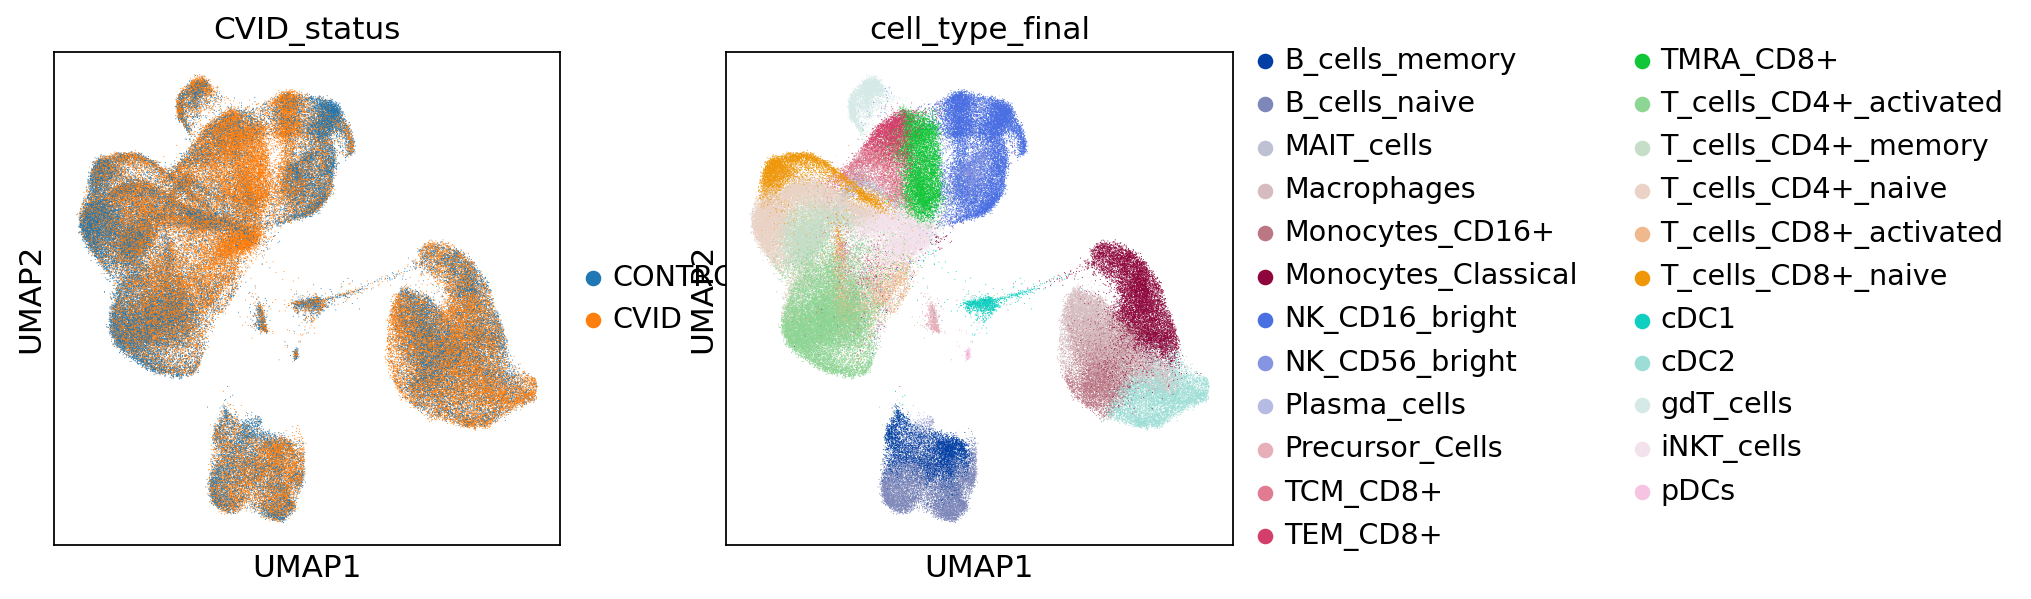

In [220]:
sc.pl.umap(adata_hvg, color=['CVID_status','cell_type_final'])

In [64]:
DE_results['pDCs']

baseMean  log2FoldChange     lfcSE      stat  \
A1BG                     10.520307       -0.808016  0.902166 -0.895640   
AAAS                      2.924603       -0.552371  1.593249 -0.346695   
AAGAB                     2.227932       -1.851631  1.917057 -0.965872   
AAMP                      3.517473       -1.300714  1.515790 -0.858110   
AASDHPPT                  1.612993        1.194131  2.141058  0.557730   
...                            ...             ...       ...       ...   
anti-c-Met               96.962159        0.209883  0.506513  0.414369   
humanCD207              128.529293        0.112292  0.492346  0.228075   
humanMac-2(Galectin-3)  395.641557       -0.747545  0.531838 -1.405588   
mouse/ratCD278(ICOS)     47.556583        0.127232  0.588547  0.216179   
mouseintegrinB7          92.599978       -0.319440  0.488806 -0.653511   

                          pvalue      padj  
A1BG                    0.370445  0.999922  
AAAS                    0.728821  0.999922  
AAGAB                   0.334108  0.999922  
AAMP                    0.390832  0.999922  
AASDHPPT                0.577029  0.999922  
...                          ...       ...  
anti-c-Met              0.678604  0.999922  
humanCD207              0.819588  0.999922  
humanMac-2(Galectin-3)  0.159847  0.999922  
mouse/ratCD278(ICOS)    0.828848  0.999922  
mouseintegrinB7         0.513427  0.999922  

[4506 rows x 6 columns]

In [66]:
len(filtered_genes['pDCs'])

4506